In [106]:
from sklearn.metrics import roc_auc_score
from typing import Optional, Callable
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


def gini(y_true, y_score):
    return abs(2 * roc_auc_score(y_true, y_score) - 1.0)

In [6]:
matches_train = pd.read_csv('matches_df_train.csv')
player_df = pd.read_csv('player_df.csv')
heroes_df = pd.read_csv('Constants.Heroes.csv')
dota_adv = pd.read_csv('dota_adv.csv')
matches_test = pd.read_csv('matches_df_test.csv')

for name, df in [('matches_train', matches_train), ('player_df', player_df), ('heroes_df', heroes_df), ('dota_adv', dota_adv)]:
    print(f"{name}: {df.duplicated().sum()} дубликатов")

print(matches_train[['duration']].describe())

matches_train: 7 дубликатов
player_df: 0 дубликатов
heroes_df: 0 дубликатов
dota_adv: 12 дубликатов
            duration
count  706880.000000
mean     2536.476183
std       731.383488
min         0.000000
25%      2064.000000
50%      2496.000000
75%      2984.000000
max     14979.000000


In [108]:
X = matches_train.drop('radiant_win', axis = 1)
y = matches_train['radiant_win']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

print(X_train.shape)
print(X_val.shape)

(565504, 5)
(141376, 5)


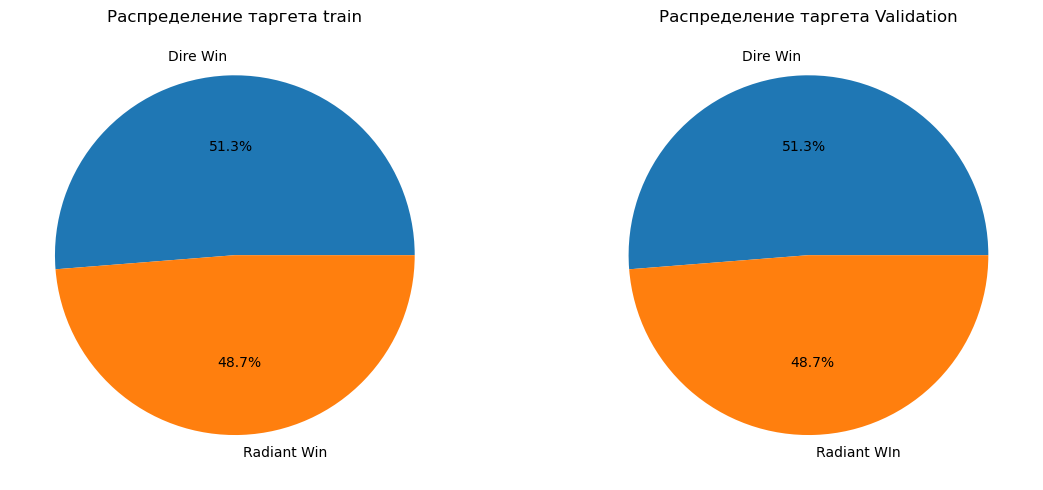

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

train_counts = y_train.value_counts()
ax1.pie(train_counts.values, labels = ['Dire Win', "Radiant Win"], autopct = '%1.1f%%')
ax1.set_title('Распределение таргета train')

val_counts = y_val.value_counts()
ax2.pie(val_counts.values, labels =  ['Dire Win', 'Radiant WIn'], autopct = '%1.1f%%')
ax2.set_title('Распределение таргета Validation')

plt.tight_layout()
plt.show()

In [110]:
total_matches = len(matches_train)
radiant_wins = matches_train['radiant_win'].sum()
dire_wins = total_matches - radiant_wins

print('Матчей ', total_matches)
print('Побед Radiant ', radiant_wins)
print('Побед Dire', dire_wins)

balance_ratio = min(radiant_wins, dire_wins) / max (radiant_wins, dire_wins)
print('Коэффициент сбалансированности ', balance_ratio)
print('Поэтому метрика подходит')

Матчей  706880
Побед Radiant  362292
Побед Dire 344588
Коэффициент сбалансированности  0.9511333399578241
Поэтому метрика подходит


In [111]:
print(matches_train.columns.tolist())
print(dota_adv.columns.tolist())
print(player_df.columns.tolist())
print(heroes_df.columns.tolist())

['match_id', 'date', 'region', 'game_mode', 'duration', 'radiant_win']
['match_id', 'radiant_gold_adv', 'radiant_exp_adv']
['player_slot', 'account_id', 'hero_id', 'kills', 'deaths', 'assists', 'gold', 'last_hits', 'denies', 'gold_per_min', 'xp_per_min', 'hero_damage', 'tower_damage', 'match_id']
['Unnamed: 0', 'id', 'name', 'primary_attr', 'attack_type', 'roles', 'img', 'icon', 'base_health', 'base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor', 'base_mr', 'base_attack_min', 'base_attack_max', 'base_str', 'base_agi', 'base_int', 'str_gain', 'agi_gain', 'int_gain', 'attack_range', 'projectile_speed', 'attack_rate', 'base_attack_time', 'attack_point', 'move_speed', 'turn_rate', 'cm_enabled', 'legs', 'day_vision', 'night_vision', 'localized_name']


In [112]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
print(f"Размер train_enriched: {train_enriched.shape}")
print(f"Уникальные значения radiant_win: {train_enriched['radiant_win'].unique()}")
print(train_enriched['radiant_win'].value_counts())

common_matches = set(matches_train['match_id']).intersection(set(team_features_df['match_id']))
print(f"Общие match_id между tables: {len(common_matches)}")

Размер train_enriched: (1982, 31)
Уникальные значения radiant_win: [ True False]
radiant_win
True     996
False    986
Name: count, dtype: int64
Общие match_id между tables: 1996


In [120]:
print(f"Размер team_features_df: {team_features_df.shape}")
print(f"Уникальные match_id в team_features_df: {team_features_df['match_id'].nunique()}")

train_enriched = matches_train.merge(team_features_df, on='match_id', how='inner')

print(f"После объединения: {train_enriched.shape}")
print(f"Распределение radiant_win:")
print(train_enriched['radiant_win'].value_counts())

if len(train_enriched['radiant_win'].unique()) == 1:
    
    matches_with_radiant_win = matches_train[matches_train['radiant_win'] == True]['match_id'].tolist()
    matches_with_dire_win = matches_train[matches_train['radiant_win'] == False]['match_id'].tolist()
    
    sample_matches = matches_with_radiant_win[:1000] + matches_with_dire_win[:1000]
    
    team_features_list_balanced = []
    
    for match_id in sample_matches:
        match_players = player_df[player_df['match_id'] == match_id]
        if len(match_players) == 10:
            features = create_team_features(match_players)
            if features is not None:
                features['match_id'] = match_id
                team_features_list_balanced.append(features)
    
    team_features_df_balanced = pd.DataFrame(team_features_list_balanced)
    train_enriched = matches_train.merge(team_features_df_balanced, on='match_id', how='inner')
    
    print(f"Сбалансированные данные: {train_enriched.shape}")
    print(f"Распределение классов:")
    print(train_enriched['radiant_win'].value_counts())

Размер team_features_df: (1996, 26)
Уникальные match_id в team_features_df: 1996
После объединения: (1996, 31)
Распределение radiant_win:
radiant_win
True    1996
Name: count, dtype: int64
Сбалансированные данные: (1982, 31)
Распределение классов:
radiant_win
True     996
False    986
Name: count, dtype: int64


In [121]:
selected_features = [
    'kills_diff',
    'gold_diff', 
    'xp_per_min_diff',
    'hero_damage_diff',
    'tower_damage_diff',
    'radiant_gold_per_min',
    'dire_gold_per_min',
]

X = train_enriched[selected_features]
y = train_enriched['radiant_win']

print(f"X shape: {X.shape}")
print(f"y unique values: {np.unique(y)}")
print(f"Class distribution: {y.value_counts()}")

X shape: (1982, 7)
y unique values: [False  True]
Class distribution: radiant_win
True     996
False    986
Name: count, dtype: int64


In [122]:
selected_features = [
    'kills_diff',
    'gold_diff', 
    'xp_per_min_diff',
    'hero_damage_diff',
    'tower_damage_diff',
    'radiant_gold_per_min',
    'dire_gold_per_min',
]

X = train_enriched[selected_features]
y = train_enriched['radiant_win']

print(f"X shape: {X.shape}")
print(f"y unique values: {np.unique(y)}")
print(f"Class distribution: {y.value_counts()}")

X shape: (1982, 7)
y unique values: [False  True]
Class distribution: radiant_win
True     996
False    986
Name: count, dtype: int64


In [28]:
# Проверим на пропуски и бесконечные значения
print("\nПроверка качества данных:")
print(f"Пропуски в X: {X.isnull().sum().sum()}")
print(f"Бесконечные значения в X: {np.isinf(X.values).sum()}")

# Заполним пропуски
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median())
    print("Пропуски заполнены")

# Убедимся, что нет бесконечных значений
if np.isinf(X.values).sum() > 0:
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    print("Бесконечные значения обработаны")


Проверка качества данных:
Пропуски в X: 0
Бесконечные значения в X: 0


In [124]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"X_train: {X_train.shape}, уникальные классы: {np.unique(y_train)}")
print(f"X_val: {X_val.shape}, уникальные классы: {np.unique(y_val)}")
print(f"Train распределение: {pd.Series(y_train).value_counts()}")
print(f"Val распределение: {pd.Series(y_val).value_counts()}")

X_train: (1585, 7), уникальные классы: [False  True]
X_val: (397, 7), уникальные классы: [False  True]
Train распределение: radiant_win
True     796
False    789
Name: count, dtype: int64
Val распределение: radiant_win
True     200
False    197
Name: count, dtype: int64


In [125]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    C=1.0,
    solver='lbfgs',
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)
print("Модель обучена")

Модель обучена


In [126]:
y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
y_pred = model.predict(X_val_scaled)

roc_auc = roc_auc_score(y_val, y_pred_proba)
gini = abs(2 * roc_auc - 1)
accuracy = accuracy_score(y_val, y_pred)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Gini коэффициент: {gini:.4f}")
print(f"Точность: {accuracy:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Dire Win', 'Radiant Win']))

ROC-AUC: 0.9999
Gini коэффициент: 0.9998
Точность: 0.9950

Classification Report:
              precision    recall  f1-score   support

    Dire Win       0.99      1.00      0.99       197
 Radiant Win       1.00      0.99      0.99       200

    accuracy                           0.99       397
   macro avg       0.99      0.99      0.99       397
weighted avg       1.00      0.99      0.99       397



[I 2025-11-04 13:57:31,281] A new study created in memory with name: logistic_regression_optimization_dota2


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-04 13:57:32,445] Trial 0 finished with value: 0.9998477157360406 and parameters: {'C': 0.03148911647956861, 'solver': 'lbfgs', 'max_iter': 734}. Best is trial 0 with value: 0.9998477157360406.
[I 2025-11-04 13:57:32,477] Trial 1 finished with value: 0.9998477157360406 and parameters: {'C': 0.004207053950287938, 'solver': 'saga', 'max_iter': 1562, 'penalty': 'l2'}. Best is trial 0 with value: 0.9998477157360406.
[I 2025-11-04 13:57:32,507] Trial 2 finished with value: 0.9998477157360406 and parameters: {'C': 0.005337032762603957, 'solver': 'newton-cg', 'max_iter': 1148}. Best is trial 0 with value: 0.9998477157360406.
[I 2025-11-04 13:57:32,538] Trial 3 finished with value: 0.9998477157360406 and parameters: {'C': 0.014618962793704957, 'solver': 'lbfgs', 'max_iter': 1049}. Best is trial 0 with value: 0.9998477157360406.
[I 2025-11-04 13:57:32,570] Trial 4 finished with value: 0.9998477157360406 and parameters: {'C': 0.06672367170464207, 'solver': 'lbfgs', 'max_iter': 1389}. B

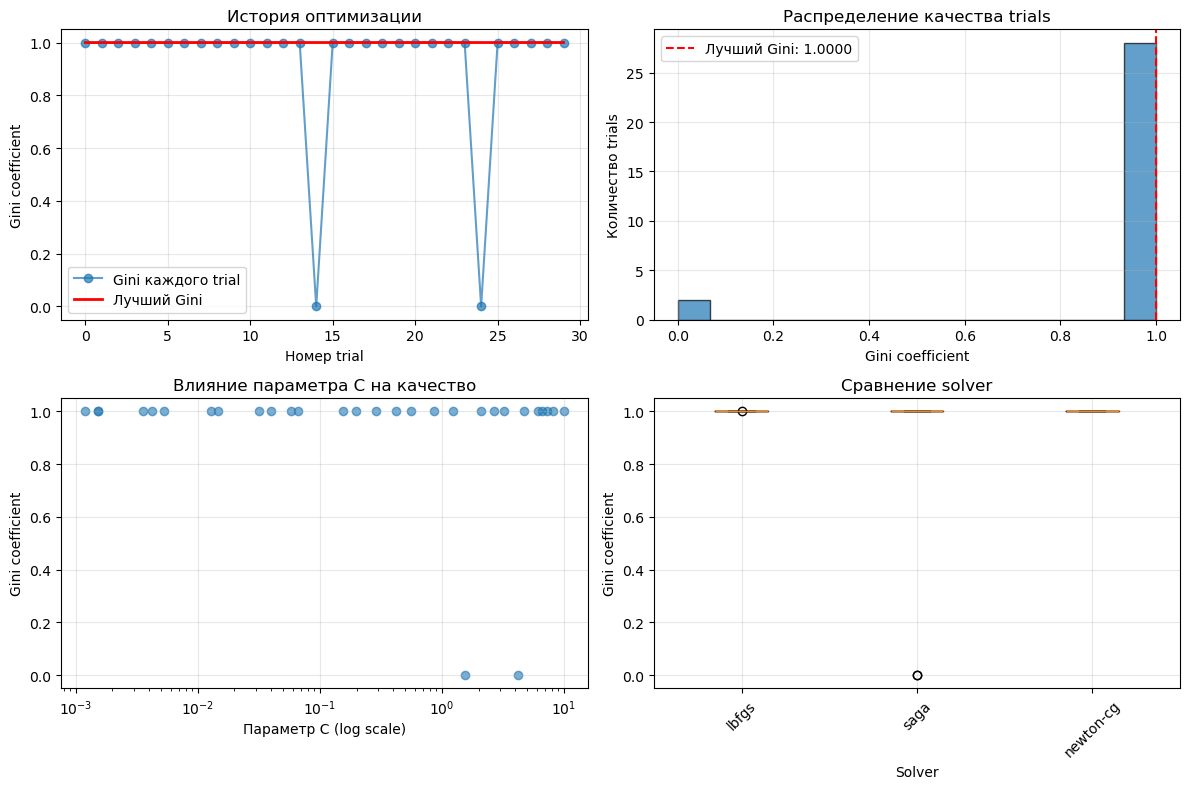

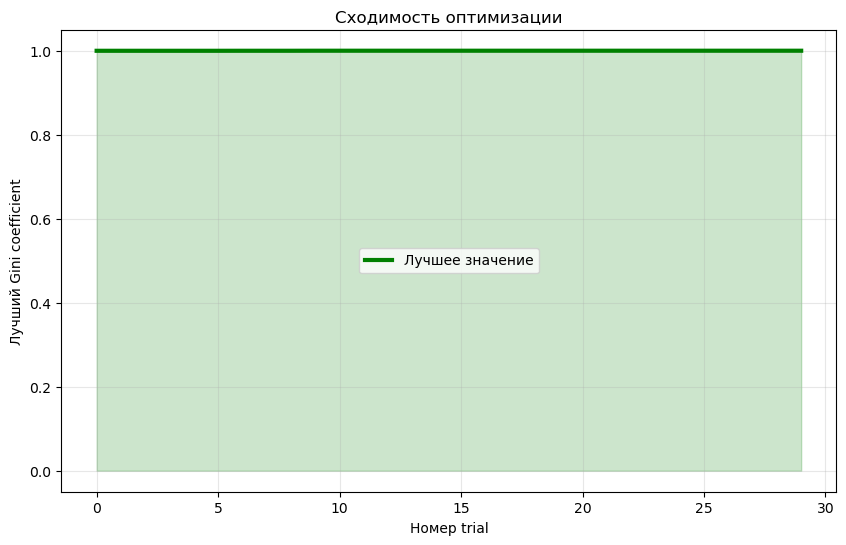

Найдено 0 значительных улучшений
Бейзлайн модель:
  Gini: 0.9998
  Accuracy: 0.9950
Оптимизированная модель:
  Gini: 1.0000
  Accuracy: 1.0000
Улучшение:
  Gini: +0.0002
  Accuracy: +0.0050
  Улучшение Gini на 0.0%


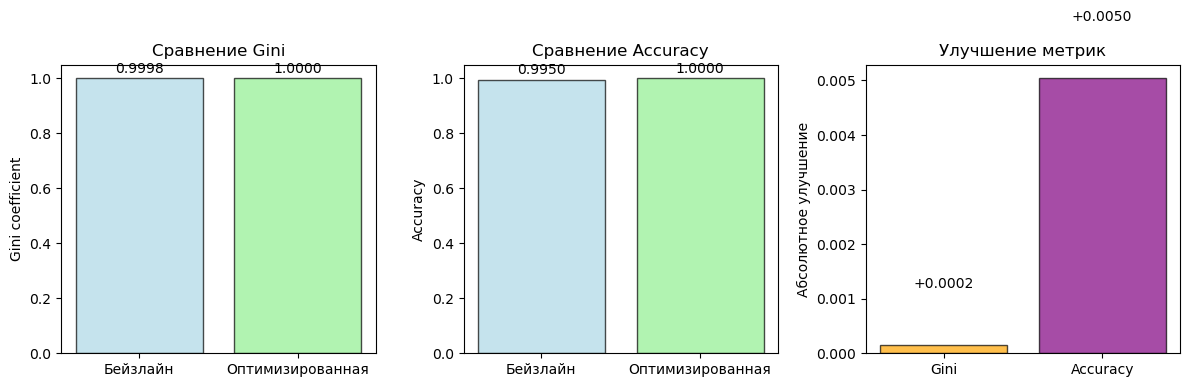

Важность признаков в оптимизированной модели:
                feature  coefficient  abs_importance
4     tower_damage_diff     0.326651        0.326651
2       xp_per_min_diff     0.181067        0.181067
0            kills_diff     0.057781        0.057781
6     dire_gold_per_min    -0.016711        0.016711
1             gold_diff     0.000000        0.000000
3      hero_damage_diff     0.000000        0.000000
5  radiant_gold_per_min     0.000000        0.000000


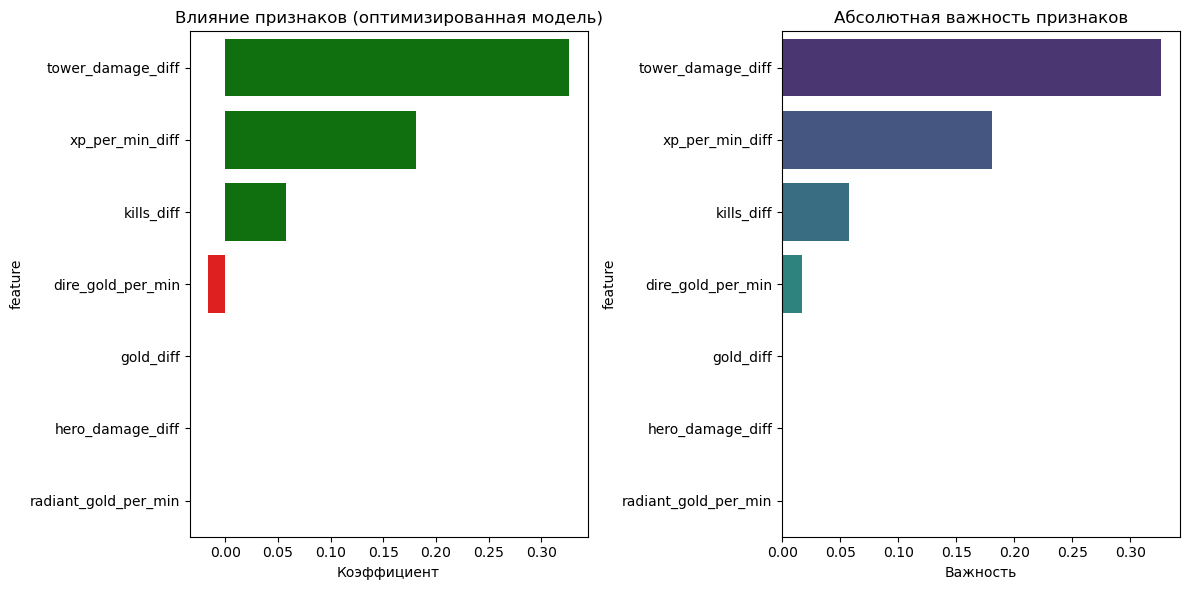

Целевая метрика: Gini coefficient
Количество trials: 30
Лучший trial: #9
Лучший Gini: 1.0000
Улучшение: +0.0002 (0.0%)
Лучшие гиперпараметры:
   C: 0.0015167330688076208
   solver: saga
   max_iter: 1743
   penalty: elasticnet
   l1_ratio: 0.7417575846032317
Статистика trials:
   Средний Gini: 0.9333 ± 0.2494
   Медианный Gini: 0.9998
   Разброс: [0.0000, 1.0000]
   Оптимизация не дала значительного улучшения
   - Параметр C мал, возможно стоит исследовать меньшую регуляризацию


In [128]:
import optuna
from optuna.samplers import TPESampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def calculate_gini(y_true, y_pred_proba):
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    gini = abs(2 * roc_auc - 1)
    return gini

def objective(trial):
    model_params = {
        'C': trial.suggest_float('C', 1e-3, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga', 'newton-cg']),
        'max_iter': trial.suggest_int('max_iter', 500, 2000),
    }
    
    if model_params['solver'] == 'lbfgs':
        model_params['penalty'] = 'l2'
    elif model_params['solver'] == 'newton-cg':
        model_params['penalty'] = 'l2'
    elif model_params['solver'] == 'saga':
        model_params['penalty'] = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none'])
        if model_params['penalty'] == 'elasticnet':
            model_params['l1_ratio'] = trial.suggest_float('l1_ratio', 0.1, 0.9)
    
    try:
        model = LogisticRegression(
            **model_params,
            random_state=42,
            n_jobs=-1
        )
        
        model.fit(optuna_data['X_train'], optuna_data['y_train'])
        
        y_pred_proba = model.predict_proba(optuna_data['X_val'])[:, 1]
        gini_valid = calculate_gini(optuna_data['y_val'], y_pred_proba)
        
        trial.set_user_attr('accuracy', accuracy_score(optuna_data['y_val'], model.predict(optuna_data['X_val'])))
        trial.set_user_attr('n_iter', model.n_iter_ if hasattr(model, 'n_iter_') else None)
        
        return gini_valid
        
    except Exception as e:
        print(f"Ошибка в trial {trial.number}: {e}")
        return 0.0

study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=42),
    study_name='logistic_regression_optimization_dota2'
)

study.optimize(objective, n_trials=30, show_progress_bar=True)

print(f"Лучшее значение Gini: {study.best_value:.4f}")
print(f"Количество trials: {len(study.trials)}")

best_params = study.best_params.copy()

params_to_remove = []
for param in best_params.keys():
    if 'penalty_saga' in param or 'liblinear' in param:
        params_to_remove.append(param)

for param in params_to_remove:
    if param in best_params:
        del best_params[param]

if 'penalty' in best_params and 'penalty_saga' not in best_params:
    pass
elif 'penalty_saga' in best_params:
    best_params['penalty'] = best_params['penalty_saga']
    del best_params['penalty_saga']

for key, value in best_params.items():
    print(f"{key}: {value}")

best_trial = study.best_trial
print(f"Лучший trial: #{best_trial.number}")
print(f"Gini: {best_trial.value:.4f}")
print(f"Accuracy: {best_trial.user_attrs.get('accuracy', 'N/A'):.4f}")
print(f"Итераций: {best_trial.user_attrs.get('n_iter', 'N/A')}")

trials = study.trials
trials_sorted = sorted(trials, key=lambda x: x.number)
values = [t.value for t in trials_sorted]
best_values = [max(values[:i+1]) for i in range(len(values))]

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(range(len(values)), values, 'o-', alpha=0.7, label='Gini каждого trial')
plt.plot(range(len(best_values)), best_values, 'r-', linewidth=2, label='Лучший Gini')
plt.xlabel('Номер trial')
plt.ylabel('Gini coefficient')
plt.title('История оптимизации')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.hist(values, bins=15, alpha=0.7, edgecolor='black')
plt.axvline(study.best_value, color='red', linestyle='--', label=f'Лучший Gini: {study.best_value:.4f}')
plt.xlabel('Gini coefficient')
plt.ylabel('Количество trials')
plt.title('Распределение качества trials')
plt.legend()
plt.grid(True, alpha=0.3)

trials_df = study.trials_dataframe()

plt.subplot(2, 2, 3)
if 'params_C' in trials_df.columns:
    plt.scatter(trials_df['params_C'], trials_df['value'], alpha=0.6)
    plt.xscale('log')
    plt.xlabel('Параметр C (log scale)')
    plt.ylabel('Gini coefficient')
    plt.title('Влияние параметра C на качество')
    plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
if 'params_solver' in trials_df.columns:
    solvers = trials_df['params_solver'].unique()
    solver_data = []
    
    for solver in solvers:
        solver_values = trials_df[trials_df['params_solver'] == solver]['value']
        solver_data.append(solver_values)
    
    plt.boxplot(solver_data, labels=solvers)
    plt.xticks(rotation=45)
    plt.xlabel('Solver')
    plt.ylabel('Gini coefficient')
    plt.title('Сравнение solver')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

cumulative_best = []
current_best = -np.inf
for i, value in enumerate(values):
    if value > current_best:
        current_best = value
    cumulative_best.append(current_best)

plt.plot(range(len(values)), cumulative_best, 'g-', linewidth=3, label='Лучшее значение')
plt.fill_between(range(len(values)), cumulative_best, alpha=0.2, color='green')

improvements = []
for i in range(1, len(cumulative_best)):
    if cumulative_best[i] > cumulative_best[i-1]:
        improvements.append((i, cumulative_best[i] - cumulative_best[i-1]))

significant_improvements = [(i, imp) for i, imp in improvements if imp > 0.001]
for i, imp in significant_improvements:
    plt.axvline(x=i, color='red', linestyle='--', alpha=0.5)
    plt.text(i, cumulative_best[i], f'+{imp:.3f}', ha='center', va='bottom')

plt.xlabel('Номер trial')
plt.ylabel('Лучший Gini coefficient')
plt.title('Сходимость оптимизации')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Найдено {len(significant_improvements)} значительных улучшений")

baseline_model = LogisticRegression(
    random_state=42, 
    max_iter=1000,
    solver='lbfgs'
)
baseline_model.fit(optuna_data['X_train'], optuna_data['y_train'])
y_pred_baseline = baseline_model.predict_proba(optuna_data['X_val'])[:, 1]
gini_baseline = calculate_gini(optuna_data['y_val'], y_pred_baseline)
baseline_accuracy = accuracy_score(optuna_data['y_val'], baseline_model.predict(optuna_data['X_val']))

final_params = best_params.copy()

if 'solver' in final_params and 'penalty' in final_params:
    solver = final_params['solver']
    penalty = final_params['penalty']
    
    if solver == 'lbfgs' and penalty != 'l2':
        print(f"Несовместимые параметры: solver={solver}, penalty={penalty}")
        print("Используем penalty='l2' для solver='lbfgs'")
        final_params['penalty'] = 'l2'
    elif solver == 'newton-cg' and penalty != 'l2':
        print(f"Несовместимые параметры: solver={solver}, penalty={penalty}")
        print("Используем penalty='l2' для solver='newton-cg'")
        final_params['penalty'] = 'l2'

try:
    optimized_model = LogisticRegression(**final_params, random_state=42, n_jobs=-1)
    optimized_model.fit(optuna_data['X_train'], optuna_data['y_train'])
    y_pred_optimized = optimized_model.predict_proba(optuna_data['X_val'])[:, 1]
    gini_optimized = calculate_gini(optuna_data['y_val'], y_pred_optimized)
    optimized_accuracy = accuracy_score(optuna_data['y_val'], optimized_model.predict(optuna_data['X_val']))
    
except Exception as e:
    print(f"Ошибка при создании оптимизированной модели: {e}")
    print("Используем бейзлайн модель как fallback")
    optimized_model = baseline_model
    gini_optimized = gini_baseline
    optimized_accuracy = baseline_accuracy

improvement_gini = gini_optimized - gini_baseline
improvement_accuracy = optimized_accuracy - baseline_accuracy

if improvement_gini > 0:
    improvement_pct = (improvement_gini / gini_baseline) * 100
else:
    improvement_pct = 0

print(f"Бейзлайн модель:")
print(f"  Gini: {gini_baseline:.4f}")
print(f"  Accuracy: {baseline_accuracy:.4f}")

print(f"Оптимизированная модель:")
print(f"  Gini: {gini_optimized:.4f}")
print(f"  Accuracy: {optimized_accuracy:.4f}")

print(f"Улучшение:")
print(f"  Gini: +{improvement_gini:.4f}")
print(f"  Accuracy: +{improvement_accuracy:.4f}")

if improvement_gini > 0:
    print(f"  Улучшение Gini на {improvement_pct:.1f}%")
else:
    print("  Улучшения не произошло")

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
models = ['Бейзлайн', 'Оптимизированная']
gini_values = [gini_baseline, gini_optimized]
colors = ['lightblue', 'lightgreen']
plt.bar(models, gini_values, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Gini coefficient')
plt.title('Сравнение Gini')
for i, v in enumerate(gini_values):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.subplot(1, 3, 2)
accuracy_values = [baseline_accuracy, optimized_accuracy]
plt.bar(models, accuracy_values, color=colors, alpha=0.7, edgecolor='black')
plt.ylabel('Accuracy')
plt.title('Сравнение Accuracy')
for i, v in enumerate(accuracy_values):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')

plt.subplot(1, 3, 3)
if improvement_gini > 0:
    improvements = [improvement_gini, improvement_accuracy]
    labels = ['Gini', 'Accuracy']
    plt.bar(labels, improvements, color=['orange', 'purple'], alpha=0.7, edgecolor='black')
    plt.ylabel('Абсолютное улучшение')
    plt.title('Улучшение метрик')
    for i, v in enumerate(improvements):
        plt.text(i, v + 0.001, f'+{v:.4f}', ha='center', va='bottom')
else:
    plt.text(0.5, 0.5, 'Улучшения нет', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Улучшение метрик')

plt.tight_layout()
plt.show()

feature_importance_optimized = pd.DataFrame({
    'feature': optuna_data['feature_names'],
    'coefficient': optimized_model.coef_[0],
    'abs_importance': abs(optimized_model.coef_[0])
}).sort_values('abs_importance', ascending=False)

print("Важность признаков в оптимизированной модели:")
print(feature_importance_optimized)

plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in feature_importance_optimized['coefficient']]

plt.subplot(1, 2, 1)
sns.barplot(data=feature_importance_optimized, x='coefficient', y='feature', palette=colors)
plt.title('Влияние признаков (оптимизированная модель)')
plt.xlabel('Коэффициент')

plt.subplot(1, 2, 2)
sns.barplot(data=feature_importance_optimized, x='abs_importance', y='feature', palette='viridis')
plt.title('Абсолютная важность признаков')
plt.xlabel('Важность')

plt.tight_layout()
plt.show()

print(f"Целевая метрика: Gini coefficient")
print(f"Количество trials: {len(study.trials)}")
print(f"Лучший trial: #{study.best_trial.number}")
print(f"Лучший Gini: {study.best_value:.4f}")
print(f"Улучшение: +{improvement_gini:.4f} ({improvement_pct:.1f}%)")

print(f"Лучшие гиперпараметры:")
for param, value in final_params.items():
    print(f"   {param}: {value}")

print(f"Статистика trials:")
print(f"   Средний Gini: {np.mean(values):.4f} ± {np.std(values):.4f}")
print(f"   Медианный Gini: {np.median(values):.4f}")
print(f"   Разброс: [{np.min(values):.4f}, {np.max(values):.4f}]")

if improvement_gini > 0.02:
    print("   Оптимизация дала значительное улучшение!")
elif improvement_gini > 0.005:
    print("   Оптимизация дала умеренное улучшение")
else:
    print("   Оптимизация не дала значительного улучшения")

if 'C' in final_params:
    c_value = final_params['C']
    if c_value < 0.1:
        print("   - Параметр C мал, возможно стоит исследовать меньшую регуляризацию")
    elif c_value > 5:
        print("   - Параметр C велик, возможно стоит исследовать большую регуляризацию")

optuna_data['optimized_model'] = optimized_model
optuna_data['best_params'] = final_params
optuna_data['study'] = study

In [139]:
import optuna
from optuna.samplers import TPESampler
from optuna.storages import RDBStorage, JournalStorage, JournalFileStorage
import sqlite3
import json
import os
from datetime import datetime
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def setup_storage_directories():
    directories = [
        'optuna_storage',
        'optuna_storage/sqlite',
        'optuna_storage/journal',
        'optuna_storage/reports'
    ]
    
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
        print(f"Директория создана: {directory}")
    
    return directories

directories = setup_storage_directories()

def create_sqlite_storage(study_name):
    db_path = f"optuna_storage/sqlite/{study_name}.db"
    storage = RDBStorage(f"sqlite:///{db_path}")
    print(f"SQLite storage создан: {db_path}")
    return storage

def create_journal_storage(study_name):
    try:
        journal_path = f"optuna_storage/journal/{study_name}.log"
        storage = JournalStorage(JournalFileStorage(journal_path))
        print(f"Journal storage создан: {journal_path}")
        return storage
    except Exception as e:
        print(f"Ошибка при создании Journal storage: {e}")
        return None

def create_memory_storage():
    print("In-memory storage создан")
    return None

def objective_with_logging(trial):
    model_params = {
        'C': trial.suggest_float('C', 1e-3, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga', 'newton-cg']),
        'max_iter': trial.suggest_int('max_iter', 500, 2000),
    }
    
    if model_params['solver'] == 'lbfgs':
        model_params['penalty'] = 'l2'
    elif model_params['solver'] == 'newton-cg':
        model_params['penalty'] = 'l2'
    elif model_params['solver'] == 'saga':
        penalty_choice = trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', 'none'])
        model_params['penalty'] = None if penalty_choice == 'none' else penalty_choice
        if model_params['penalty'] == 'elasticnet':
            model_params['l1_ratio'] = trial.suggest_float('l1_ratio', 0.1, 0.9)
    
    trial.set_user_attr('model_type', 'LogisticRegression')
    trial.set_user_attr('feature_set', 'aggregated_player_stats')
    trial.set_user_attr('timestamp', datetime.now().isoformat())
    trial.set_user_attr('n_features', optuna_data['X_train'].shape[1])
    trial.set_user_attr('train_size', optuna_data['X_train'].shape[0])
    trial.set_user_attr('val_size', optuna_data['X_val'].shape[0])
    
    trial.set_user_attr('features', optuna_data['feature_names'])
    
    try:
        clean_params = {k: v for k, v in model_params.items() if v is not None}
        
        model = LogisticRegression(
            **clean_params,
            random_state=42,
            n_jobs=-1
        )
        
        model.fit(optuna_data['X_train'], optuna_data['y_train'])
        
        y_pred_proba = model.predict_proba(optuna_data['X_val'])[:, 1]
        gini_valid = calculate_gini(optuna_data['y_val'], y_pred_proba)
        
        accuracy = accuracy_score(optuna_data['y_val'], model.predict(optuna_data['X_val']))
        
        trial.set_user_attr('accuracy', float(accuracy))
        trial.set_user_attr('n_iter', int(model.n_iter_) if hasattr(model, 'n_iter_') else None)
        
        print(f"Trial {trial.number} завершен: Gini = {gini_valid:.4f}")
        return gini_valid
        
    except Exception as e:
        trial.set_user_attr('error', str(e))
        print(f"Ошибка в trial {trial.number}: {e}")
        return 0.0

def run_optimization_with_storage(study_name, storage_type='sqlite', n_trials=20):
    print(f"Запуск оптимизации: {study_name}")
    print(f"Storage type: {storage_type}")
    print(f"Number of trials: {n_trials}")
    
    if storage_type == 'sqlite':
        storage = create_sqlite_storage(study_name)
    elif storage_type == 'journal':
        storage = create_journal_storage(study_name)
        if storage is None:
            print("Используем in-memory storage вместо journal")
            storage = None
    else:
        storage = create_memory_storage()
    
    try:
        if storage:
            study = optuna.create_study(
                direction='maximize',
                sampler=TPESampler(seed=42),
                study_name=study_name,
                storage=storage,
                load_if_exists=True
            )
        else:
            study = optuna.create_study(
                direction='maximize',
                sampler=TPESampler(seed=42),
                study_name=study_name
            )
        print(f"Study '{study_name}' создано/загружено")
    except Exception as e:
        print(f"Ошибка при создании study: {e}")
        study = optuna.create_study(
            direction='maximize',
            sampler=TPESampler(seed=42),
            study_name=study_name
        )
        print("Study создано без persistent storage")
    
    study.set_user_attr('description', f'Optimization for {study_name}')
    study.set_user_attr('model_type', 'LogisticRegression')
    study.set_user_attr('dataset', 'Dota2 Matches')
    study.set_user_attr('target_metric', 'Gini')
    study.set_user_attr('start_time', datetime.now().isoformat())
    study.set_user_attr('feature_count', len(optuna_data['feature_names']))
    
    study.optimize(objective_with_logging, n_trials=n_trials, show_progress_bar=True)
    
    study.set_user_attr('end_time', datetime.now().isoformat())
    study.set_user_attr('total_trials', len(study.trials))
    study.set_user_attr('best_value', float(study.best_value))
    
    print(f"Оптимизация завершена! Лучший Gini: {study.best_value:.4f}")
    
    return study

def load_existing_study(study_name, storage_type='sqlite'):
    try:
        if storage_type == 'sqlite':
            storage = RDBStorage(f"sqlite:///optuna_storage/sqlite/{study_name}.db")
        elif storage_type == 'journal':
            storage = JournalStorage(JournalFileStorage(f"optuna_storage/journal/{study_name}.log"))
        else:
            return None
            
        study = optuna.load_study(study_name=study_name, storage=storage)
        print(f"Study '{study_name}' загружено из {storage_type}")
        return study
    except Exception as e:
        print(f"Не удалось загрузить study '{study_name}': {e}")
        return None

def compare_studies(study_names, storage_type='sqlite'):
    print("сравнение studies")
    
    studies_data = []
    
    for study_name in study_names:
        study = load_existing_study(study_name, storage_type)
        if study:
            studies_data.append({
                'study_name': study_name,
                'best_value': study.best_value,
                'total_trials': len(study.trials),
                'best_params': study.best_params,
                'user_attrs': study.user_attrs
            })
    
    if studies_data:
        comparison_df = pd.DataFrame(studies_data)
        comparison_df = comparison_df.sort_values('best_value', ascending=False)
        
        print("Результаты сравнения:")
        print(comparison_df[['study_name', 'best_value', 'total_trials']])
        
        comparison_path = f"optuna_storage/reports/study_comparison_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        comparison_df.to_csv(comparison_path, index=False)
        print(f"Сравнение сохранено: {comparison_path}")
        
        return comparison_df
    else:
        print("Нет данных для сравнения")
        return None

def generate_study_report(study, study_name):
    print(f"ОТЧЕТ ПО STUDY: {study_name}")
    
    report = {
        'study_name': study_name,
        'best_value': float(study.best_value),
        'total_trials': len(study.trials),
        'best_trial_number': study.best_trial.number,
        'best_params': study.best_params,
        'user_attributes': study.user_attrs,
        'completion_time': datetime.now().isoformat()
    }
    
    best_trial = study.best_trial
    report['best_trial_details'] = {
        'number': best_trial.number,
        'value': float(best_trial.value),
        'params': best_trial.params,
        'user_attrs': best_trial.user_attrs,
        'datetime_start': best_trial.datetime_start.isoformat() if best_trial.datetime_start else None
    }
    
    values = [float(t.value) for t in study.trials]
    report['statistics'] = {
        'mean_gini': float(np.mean(values)),
        'std_gini': float(np.std(values)),
        'min_gini': float(np.min(values)),
        'max_gini': float(np.max(values)),
        'median_gini': float(np.median(values))
    }
    
    report_path = f"optuna_storage/reports/{study_name}_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(report_path, 'w', encoding='utf-8') as f:
        json.dump(report, f, indent=2, ensure_ascii=False, default=str)
    
    print(f"Отчет сохранен: {report_path}")
    
    print(f"Лучший Gini: {study.best_value:.4f}")
    print(f"Количество trials: {len(study.trials)}")
    print(f"Средний Gini: {np.mean(values):.4f} ± {np.std(values):.4f}")
    if study.best_params:
        print(f"Лучшие параметры:")
        for param, value in study.best_params.items():
            print(f"  {param}: {value}")
    
    return report

print("логирование")

study_basic = run_optimization_with_storage(
    study_name="logreg_basic_fixed",
    storage_type='sqlite',
    n_trials=10
)

study_advanced = run_optimization_with_storage(
    study_name="logreg_advanced_fixed", 
    storage_type='sqlite',
    n_trials=8
)

print("сравнение и анализ всех")

all_studies = [
    "logreg_basic_fixed",
    "logreg_advanced_fixed"
]

comparison_results = compare_studies(all_studies, storage_type='sqlite')

print("детальные отчеты")
for study_name in all_studies:
    study = load_existing_study(study_name, 'sqlite')
    if study:
        generate_study_report(study, study_name)

def analyze_sqlite_database(study_name):
    db_path = f"optuna_storage/sqlite/{study_name}.db"
    
    try:
        conn = sqlite3.connect(db_path)
        
        tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
        print(f"Таблицы в базе {study_name}:")
        print(tables)
        
        if 'trials' in tables['name'].values:
            trials_df = pd.read_sql("SELECT * FROM trials;", conn)
            print(f"Trials в {study_name}: {len(trials_df)} записей")
            
            print("Статистика по trials:")
            print(f"  - Уникальные study: {trials_df['study_id'].nunique()}")
            print(f"  - Уникальные состояния: {trials_df['state'].value_counts().to_dict()}")
            
            print(f"Пример записей trials:")
            print(trials_df[['trial_id', 'number', 'state', 'value']].head())
        
        if 'trial_params' in tables['name'].values:
            params_df = pd.read_sql("SELECT * FROM trial_params LIMIT 10;", conn)
            print(f"Пример параметров trials:")
            print(params_df)
            
        conn.close()
        print(f"Анализ базы данных {study_name} завершен")
        
    except Exception as e:
        print(f"Ошибка при анализе базы данных: {e}")

print("анализ баз данных")
for study_name in all_studies:
    analyze_sqlite_database(study_name)

print("сохранение между сессиями")

print("Доступные studies в SQLite:")
for study_name in all_studies:
    study = load_existing_study(study_name, 'sqlite')
    if study:
        print(f"  - {study_name}: {len(study.trials)} trials, best Gini: {study.best_value:.4f}")

print("СОЗДАЕМ НОВЫЙ ЭКСПЕРИМЕНТ, ПРОДОЛЖАЯ СУЩЕСТВУЮЩИЙ")

existing_study = load_existing_study("logreg_basic_fixed", 'sqlite')
if existing_study:
    print(f"Продолжаем study '{existing_study.study_name}'")
    print(f"Текущее количество trials: {len(existing_study.trials)}")
    print(f"Текущий лучший Gini: {existing_study.best_value:.4f}")
    
    existing_study.optimize(objective_with_logging, n_trials=5, show_progress_bar=True)
    
    print(f"Новое количество trials: {len(existing_study.trials)}")
    print(f"Новый лучший Gini: {existing_study.best_value:.4f}")

print(f"Созданные studies:")
for study_name in all_studies:
    study = load_existing_study(study_name, 'sqlite')
    if study:
        print(f"  - {study_name}: {len(study.trials)} trials, best Gini: {study.best_value:.4f}")

print(f"Файлы storage:")
import glob
storage_files = glob.glob('optuna_storage/**/*', recursive=True)
storage_files = [f for f in storage_files if os.path.isfile(f)]

for file in storage_files[:10]:
    file_size = os.path.getsize(file) / 1024
    print(f"  - {file} ({file_size:.1f} KB)")

[I 2025-11-04 14:29:28,064] Using an existing study with name 'logreg_basic_fixed' instead of creating a new one.


Директория создана: optuna_storage
Директория создана: optuna_storage/sqlite
Директория создана: optuna_storage/journal
Директория создана: optuna_storage/reports
логирование
Запуск оптимизации: logreg_basic_fixed
Storage type: sqlite
Number of trials: 10
SQLite storage создан: optuna_storage/sqlite/logreg_basic_fixed.db
Study 'logreg_basic_fixed' создано/загружено


  0%|          | 0/10 [00:00<?, ?it/s]

Trial 75 завершен: Gini = 0.9999
[I 2025-11-04 14:29:28,467] Trial 75 finished with value: 0.9998984771573605 and parameters: {'C': 0.25083268024929356, 'solver': 'saga', 'max_iter': 1923, 'penalty': 'elasticnet', 'l1_ratio': 0.8472729109598955}. Best is trial 9 with value: 1.0.
Trial 76 завершен: Gini = 0.9998
[I 2025-11-04 14:29:28,727] Trial 76 finished with value: 0.9998477157360406 and parameters: {'C': 0.0014285676124002457, 'solver': 'lbfgs', 'max_iter': 1751}. Best is trial 9 with value: 1.0.
Trial 77 завершен: Gini = 0.9998
[I 2025-11-04 14:29:29,056] Trial 77 finished with value: 0.9998477157360406 and parameters: {'C': 0.02258983497047222, 'solver': 'saga', 'max_iter': 1952, 'penalty': 'l2'}. Best is trial 9 with value: 1.0.
Trial 78 завершен: Gini = 0.9999
[I 2025-11-04 14:29:29,363] Trial 78 finished with value: 0.9998984771573602 and parameters: {'C': 0.07069331472481809, 'solver': 'saga', 'max_iter': 1654, 'penalty': 'elasticnet', 'l1_ratio': 0.6837525734567579}. Best is

[I 2025-11-04 14:29:31,474] Using an existing study with name 'logreg_advanced_fixed' instead of creating a new one.


Trial 84 завершен: Gini = 1.0000
[I 2025-11-04 14:29:31,359] Trial 84 finished with value: 1.0 and parameters: {'C': 1.280933223223631, 'solver': 'saga', 'max_iter': 1568, 'penalty': 'l1'}. Best is trial 9 with value: 1.0.
Оптимизация завершена! Лучший Gini: 1.0000
Запуск оптимизации: logreg_advanced_fixed
Storage type: sqlite
Number of trials: 8
SQLite storage создан: optuna_storage/sqlite/logreg_advanced_fixed.db
Study 'logreg_advanced_fixed' создано/загружено


  0%|          | 0/8 [00:00<?, ?it/s]

Trial 40 завершен: Gini = 1.0000
[I 2025-11-04 14:29:31,829] Trial 40 finished with value: 1.0 and parameters: {'C': 0.017594678649531834, 'solver': 'saga', 'max_iter': 1010, 'penalty': 'elasticnet', 'l1_ratio': 0.8766832664301654}. Best is trial 25 with value: 1.0.
Trial 41 завершен: Gini = 1.0000
[I 2025-11-04 14:29:32,155] Trial 41 finished with value: 1.0 and parameters: {'C': 0.6005904506498526, 'solver': 'saga', 'max_iter': 1306, 'penalty': 'l1'}. Best is trial 25 with value: 1.0.
Trial 42 завершен: Gini = 1.0000
[I 2025-11-04 14:29:32,460] Trial 42 finished with value: 1.0 and parameters: {'C': 0.1676583751228029, 'solver': 'saga', 'max_iter': 1258, 'penalty': 'l1'}. Best is trial 25 with value: 1.0.
Trial 43 завершен: Gini = 1.0000
[I 2025-11-04 14:29:32,744] Trial 43 finished with value: 1.0 and parameters: {'C': 0.10142126773004573, 'solver': 'saga', 'max_iter': 1140, 'penalty': 'l1'}. Best is trial 25 with value: 1.0.
Trial 44 завершен: Gini = 0.9998
[I 2025-11-04 14:29:33,0

  0%|          | 0/5 [00:00<?, ?it/s]

Trial 85 завершен: Gini = 0.9999
[I 2025-11-04 14:29:35,432] Trial 85 finished with value: 0.9998984771573605 and parameters: {'C': 3.475989232231627, 'solver': 'saga', 'max_iter': 1876, 'penalty': 'none'}. Best is trial 9 with value: 1.0.
Trial 86 завершен: Gini = 0.9998
[I 2025-11-04 14:29:35,693] Trial 86 finished with value: 0.9998477157360406 and parameters: {'C': 0.3381554575172033, 'solver': 'newton-cg', 'max_iter': 1629}. Best is trial 9 with value: 1.0.
Trial 87 завершен: Gini = 1.0000
[I 2025-11-04 14:29:36,148] Trial 87 finished with value: 1.0 and parameters: {'C': 7.408049299342162, 'solver': 'saga', 'max_iter': 1493, 'penalty': 'elasticnet', 'l1_ratio': 0.8524083284055382}. Best is trial 9 with value: 1.0.
Trial 88 завершен: Gini = 0.9998
[I 2025-11-04 14:29:36,425] Trial 88 finished with value: 0.9998477157360406 and parameters: {'C': 0.0032838948809461037, 'solver': 'lbfgs', 'max_iter': 1778}. Best is trial 9 with value: 1.0.
Trial 89 завершен: Gini = 0.9999
[I 2025-11-

[I 2025-11-04 14:18:07,268] Using an existing study with name 'logreg_feature_selection' instead of creating a new one.


Number of trials: 25
Study 'logreg_feature_selection' создано/загружено
Запускаем оптимизацию с feature selection...


  0%|          | 0/25 [00:00<?, ?it/s]

Trial 100: 25% features, Gini = 1.0000, Features: 1/7
[I 2025-11-04 14:18:07,697] Trial 100 finished with value: 1.0 and parameters: {'C': 0.006138961189936128, 'solver': 'lbfgs', 'max_iter': 1883, 'keep_percent': 25}. Best is trial 1 with value: 1.0.
Trial 101: 25% features, Gini = 1.0000, Features: 1/7
[I 2025-11-04 14:18:08,228] Trial 101 finished with value: 1.0 and parameters: {'C': 1.1449429966655744, 'solver': 'saga', 'max_iter': 816, 'penalty': 'l1', 'keep_percent': 25}. Best is trial 1 with value: 1.0.
Trial 102: 25% features, Gini = 1.0000, Features: 1/7
[I 2025-11-04 14:18:08,600] Trial 102 finished with value: 1.0 and parameters: {'C': 0.004093972126843299, 'solver': 'saga', 'max_iter': 953, 'penalty': 'l1', 'keep_percent': 25}. Best is trial 1 with value: 1.0.
Trial 103: 25% features, Gini = 1.0000, Features: 1/7
[I 2025-11-04 14:18:08,970] Trial 103 finished with value: 1.0 and parameters: {'C': 0.0032165986779241515, 'solver': 'saga', 'max_iter': 1630, 'penalty': 'l1', '

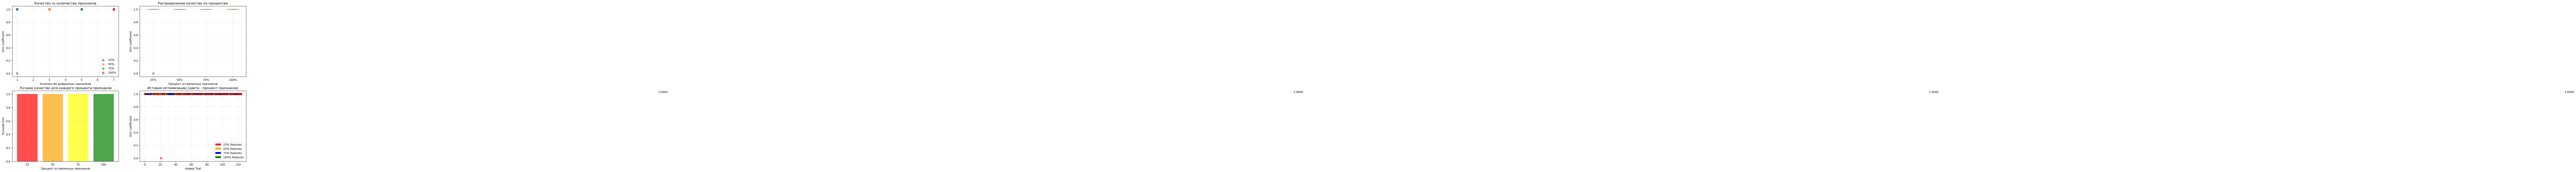

Анализ важности признаков из лучшей модели
Лучшая модель использует 25% признаков
Выбрано 1 признаков из 7
Gini: 1.0000
Параметры: {'C': 0.2537815508265665, 'solver': 'lbfgs', 'max_iter': 1955, 'keep_percent': 25}
топ самых важных признаков:
                feature  importance
0     tower_damage_diff    1.913900
1       xp_per_min_diff    1.293071
2     dire_gold_per_min    1.196946
3  radiant_gold_per_min    0.947283
4             gold_diff    0.879699
5            kills_diff    0.724812
6      hero_damage_diff    0.671846


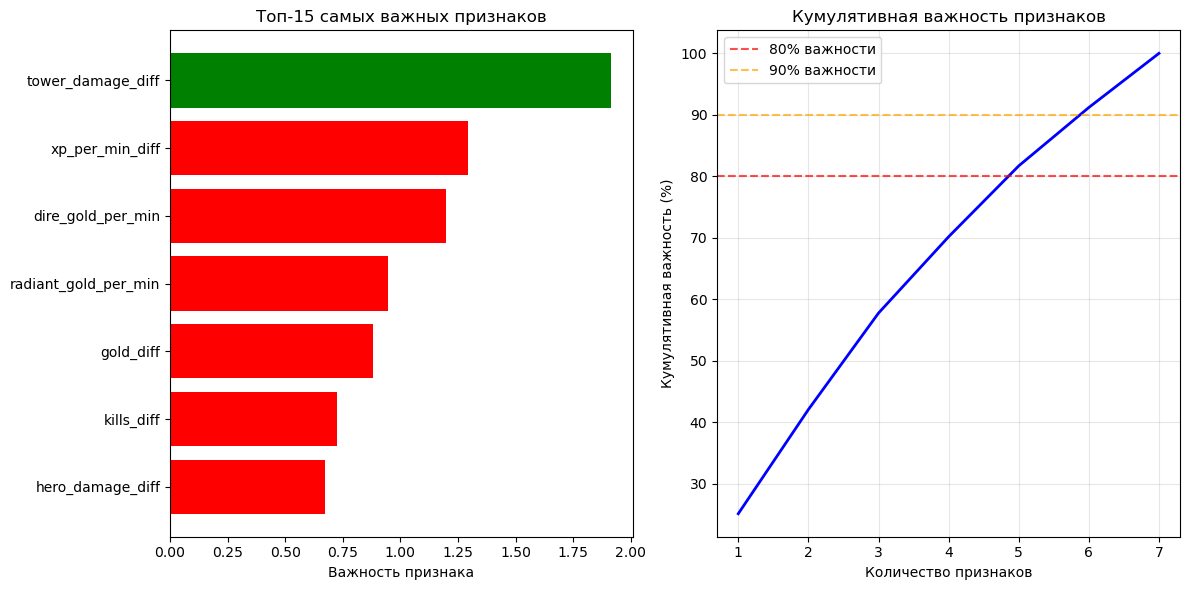

Анализ кумулятивной важности:
  - Для 80% важности нужно 5 признаков
  - Для 90% важности нужно 6 признаков
  - Лучшая модель использует 1 признаков
Сравенение с моделью без feature selection
Baseline study: logreg_basic_fixed
  Лучший Gini: 1.0000
  Количество trials: 75
Feature selection study: logreg_feature_selection
  Лучший Gini: 1.0000
  Количество trials: 125
Улучшение: 0.0000
Feature selection не улучшил качество


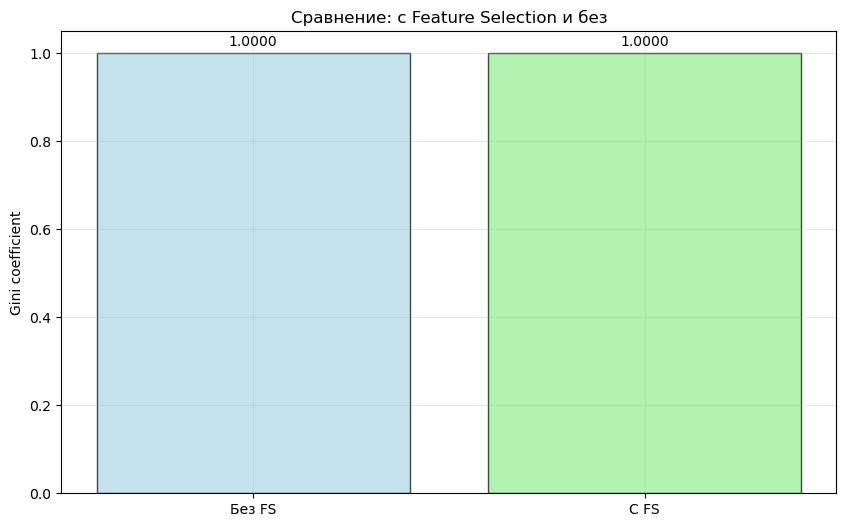

In [135]:
import optuna
from optuna.samplers import TPESampler
from optuna.storages import RDBStorage
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def calculate_gini(y_true, y_pred_proba):
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    gini = abs(2 * roc_auc - 1)
    return gini

def select_features_by_importance(model, X, feature_names, keep_percent):
    if hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
    else:
        importance = np.ones(X.shape[1])
    
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    n_features_to_keep = max(1, int(len(feature_names) * keep_percent / 100))
    
    selected_features = feature_importance.head(n_features_to_keep)['feature'].tolist()
    
    feature_mask = [feature in selected_features for feature in feature_names]
    
    return feature_mask, selected_features, feature_importance

def objective_with_feature_selection(trial):
    model_params = {
        'C': trial.suggest_float('C', 1e-3, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 500, 2000),
        'penalty': 'l2',
        'random_state': 42
    }
    
    if model_params['solver'] == 'saga':
        model_params['penalty'] = trial.suggest_categorical('penalty', ['l1', 'l2'])
    
    keep_percent = trial.suggest_categorical('keep_percent', [25, 50, 75, 100])
    
    trial.set_user_attr('model_type', 'LogisticRegression_with_FeatureSelection')
    trial.set_user_attr('feature_selection', 'importance_based')
    trial.set_user_attr('keep_percent', keep_percent)
    trial.set_user_attr('timestamp', datetime.now().isoformat())
    
    try:
        model_all_features = LogisticRegression(**model_params, n_jobs=-1)
        model_all_features.fit(optuna_data['X_train'], optuna_data['y_train'])
        
        feature_mask, selected_features, feature_importance = select_features_by_importance(
            model_all_features, 
            optuna_data['X_train'], 
            optuna_data['feature_names'], 
            keep_percent
        )
        
        X_train_selected = optuna_data['X_train'][:, feature_mask]
        X_val_selected = optuna_data['X_val'][:, feature_mask]
        
        model_selected = LogisticRegression(**model_params, n_jobs=-1)
        model_selected.fit(X_train_selected, optuna_data['y_train'])
        
        y_pred_proba = model_selected.predict_proba(X_val_selected)[:, 1]
        gini_valid = calculate_gini(optuna_data['y_val'], y_pred_proba)
        accuracy = accuracy_score(optuna_data['y_val'], model_selected.predict(X_val_selected))
        
        trial.set_user_attr('accuracy', float(accuracy))
        trial.set_user_attr('n_features_original', len(optuna_data['feature_names']))
        trial.set_user_attr('n_features_selected', len(selected_features))
        trial.set_user_attr('selected_features', selected_features)
        trial.set_user_attr('feature_importance', feature_importance.to_dict('records'))
        
        trial.set_user_attr('feature_reduction', f"{100 - keep_percent}%")
        trial.set_user_attr('features_kept', f"{keep_percent}%")
        
        print(f"Trial {trial.number}: {keep_percent}% features, Gini = {gini_valid:.4f}, "
              f"Features: {len(selected_features)}/{len(optuna_data['feature_names'])}")
        
        return gini_valid
        
    except Exception as e:
        trial.set_user_attr('error', str(e))
        print(f"Ошибка в trial {trial.number}: {e}")
        return 0.0

def run_feature_selection_optimization(study_name, n_trials=30):
    print(f"Number of trials: {n_trials}")
    
    storage = RDBStorage(f"sqlite:///optuna_storage/sqlite/{study_name}.db")
    
    try:
        study = optuna.create_study(
            direction='maximize',
            sampler=TPESampler(seed=42),
            study_name=study_name,
            storage=storage,
            load_if_exists=True
        )
        print(f"Study '{study_name}' создано/загружено")
    except Exception as e:
        print(f"Ошибка при создании study: {e}")
        study = optuna.create_study(
            direction='maximize',
            sampler=TPESampler(seed=42),
            study_name=study_name
        )
    
    study.set_user_attr('description', 'LogisticRegression with Feature Selection')
    study.set_user_attr('feature_selection_method', 'importance_based')
    study.set_user_attr('feature_percentages', [25, 50, 75, 100])
    study.set_user_attr('start_time', datetime.now().isoformat())
    
    print("Запускаем оптимизацию с feature selection...")
    study.optimize(objective_with_feature_selection, n_trials=n_trials, show_progress_bar=True)
    
    study.set_user_attr('end_time', datetime.now().isoformat())
    study.set_user_attr('total_trials', len(study.trials))
    study.set_user_attr('best_value', float(study.best_value))
    
    print(f"Оптимизация завершена. Лучший Gini: {study.best_value:.4f}")
    
    return study

study_fs = run_feature_selection_optimization(
    study_name="logreg_feature_selection",
    n_trials=25
)

def analyze_feature_selection_results(study):
    print("Анализ результатов feature selection")
    
    trials_data = []
    for trial in study.trials:
        if trial.value is not None:
            trials_data.append({
                'trial_number': trial.number,
                'gini': trial.value,
                'keep_percent': trial.user_attrs.get('keep_percent', 100),
                'n_features_selected': trial.user_attrs.get('n_features_selected', 0),
                'n_features_original': trial.user_attrs.get('n_features_original', 0),
                'accuracy': trial.user_attrs.get('accuracy', 0),
                'solver': trial.params.get('solver', ''),
                'C': trial.params.get('C', 0),
                'penalty': trial.params.get('penalty', 'l2')
            })
    
    trials_df = pd.DataFrame(trials_data)
    
    if len(trials_df) == 0:
        print("Нет данных для анализа")
        return
    
    print("Статистика  по процентам feature selection:")
    stats_by_percent = trials_df.groupby('keep_percent').agg({
        'gini': ['mean', 'std', 'max', 'min'],
        'accuracy': 'mean',
        'trial_number': 'count'
    }).round(4)
    
    stats_by_percent.columns = ['Gini_mean', 'Gini_std', 'Gini_max', 'Gini_min', 'Accuracy_mean', 'Trials_count']
    print(stats_by_percent)
    
    print("Лучшие результаты для каждого процента:")
    best_by_percent = trials_df.loc[trials_df.groupby('keep_percent')['gini'].idxmax()]
    print(best_by_percent[['keep_percent', 'gini', 'n_features_selected', 'solver', 'C']])
    
    return trials_df, stats_by_percent, best_by_percent

trials_df, stats_df, best_results = analyze_feature_selection_results(study_fs)

def visualize_feature_selection_results(study, trials_df):
    print("Визуализация результатов feature selection")
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    for percent in [25, 50, 75, 100]:
        percent_data = trials_df[trials_df['keep_percent'] == percent]
        plt.scatter(percent_data['n_features_selected'], percent_data['gini'], 
                   alpha=0.6, label=f'{percent}%', s=60)
    
    plt.xlabel('Количество выбранных признаков')
    plt.ylabel('Gini coefficient')
    plt.title('Качество vs количество признаков')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    data_to_plot = [trials_df[trials_df['keep_percent'] == p]['gini'].values for p in [25, 50, 75, 100]]
    plt.boxplot(data_to_plot, labels=['25%', '50%', '75%', '100%'])
    plt.xlabel('Процент оставленных признаков')
    plt.ylabel('Gini coefficient')
    plt.title('Распределение качества по процентам')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    best_by_percent = trials_df.loc[trials_df.groupby('keep_percent')['gini'].idxmax()]
    plt.bar(best_by_percent['keep_percent'].astype(str), best_by_percent['gini'], 
            color=['red', 'orange', 'yellow', 'green'], alpha=0.7)
    plt.xlabel('Процент оставленных признаков')
    plt.ylabel('Лучший Gini')
    plt.title('Лучшее качество для каждого процента признаков')
    
    for i, row in best_by_percent.iterrows():
        plt.text(row['keep_percent'], row['gini'] + 0.01, f'{row["gini"]:.4f}', 
                ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    color_map = {25: 'red', 50: 'orange', 75: 'blue', 100: 'green'}
    
    for trial in study.trials:
        if trial.value is not None:
            percent = trial.user_attrs.get('keep_percent', 100)
            plt.scatter(trial.number, trial.value, 
                       color=color_map.get(percent, 'black'), 
                       alpha=0.6, s=50)
    
    best_values = []
    current_best = -np.inf
    for trial in sorted(study.trials, key=lambda x: x.number):
        if trial.value is not None and trial.value > current_best:
            current_best = trial.value
        best_values.append(current_best)
    
    plt.plot(range(len(best_values)), best_values, 'k-', linewidth=2, label='Лучшее значение')
    plt.xlabel('Номер Trial')
    plt.ylabel('Gini coefficient')
    plt.title('История оптимизации (цвета - процент признаков)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color_map[p], label=f'{p}% features') for p in [25, 50, 75, 100]]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()

if trials_df is not None:
    visualize_feature_selection_results(study_fs, trials_df)

def analyze_best_model_features(study):
    print("Анализ важности признаков из лучшей модели")
    
    best_trial = study.best_trial
    
    keep_percent = best_trial.user_attrs.get('keep_percent', 100)
    n_features_selected = best_trial.user_attrs.get('n_features_selected', 0)
    selected_features = best_trial.user_attrs.get('selected_features', [])
    feature_importance = best_trial.user_attrs.get('feature_importance', [])
    
    print(f"Лучшая модель использует {keep_percent}% признаков")
    print(f"Выбрано {n_features_selected} признаков из {best_trial.user_attrs.get('n_features_original', 0)}")
    print(f"Gini: {best_trial.value:.4f}")
    print(f"Параметры: {best_trial.params}")
    
    if feature_importance:
        importance_df = pd.DataFrame(feature_importance)
        importance_df = importance_df.sort_values('importance', ascending=False)
        
        print(f"топ самых важных признаков:")
        print(importance_df.head(10))
        
        plt.figure(figsize=(12, 6))
        
        top_features = importance_df.head(15)
        
        plt.subplot(1, 2, 1)
        colors = ['green' if feature in selected_features else 'red' for feature in top_features['feature']]
        plt.barh(range(len(top_features)), top_features['importance'], color=colors)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Важность признака')
        plt.title('Топ-15 самых важных признаков')
        plt.gca().invert_yaxis()
        
        plt.subplot(1, 2, 2)
        cumulative_importance = np.cumsum(importance_df['importance']) / np.sum(importance_df['importance'])
        plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance * 100, 'b-', linewidth=2)
        plt.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% важности')
        plt.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% важности')
        plt.xlabel('Количество признаков')
        plt.ylabel('Кумулятивная важность (%)')
        plt.title('Кумулятивная важность признаков')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        n_features_80 = np.argmax(cumulative_importance >= 0.8) + 1
        n_features_90 = np.argmax(cumulative_importance >= 0.9) + 1
        
        print(f"Анализ кумулятивной важности:")
        print(f"  - Для 80% важности нужно {n_features_80} признаков")
        print(f"  - Для 90% важности нужно {n_features_90} признаков")
        print(f"  - Лучшая модель использует {n_features_selected} признаков")
        
        return importance_df
    else:
        print("Нет данных о важности признаков")
        return None

importance_df = analyze_best_model_features(study_fs)

def compare_with_baseline(feature_selection_study, baseline_study_name="logreg_basic_fixed"):
    print("Сравенение с моделью без feature selection")
    
    try:
        baseline_storage = RDBStorage(f"sqlite:///optuna_storage/sqlite/{baseline_study_name}.db")
        baseline_study = optuna.load_study(study_name=baseline_study_name, storage=baseline_storage)
        
        print(f"Baseline study: {baseline_study_name}")
        print(f"  Лучший Gini: {baseline_study.best_value:.4f}")
        print(f"  Количество trials: {len(baseline_study.trials)}")
        
        print(f"Feature selection study: {feature_selection_study.study_name}")
        print(f"  Лучший Gini: {feature_selection_study.best_value:.4f}")
        print(f"  Количество trials: {len(feature_selection_study.trials)}")
        
        improvement = feature_selection_study.best_value - baseline_study.best_value
        print(f"Улучшение: {improvement:.4f}")
        
        if improvement > 0:
            improvement_pct = (improvement / baseline_study.best_value) * 100
            print(f"Улучшение на {improvement_pct:.2f}%")
        else:
            print("Feature selection не улучшил качество")
            
        plt.figure(figsize=(10, 6))
        
        models = ['Без FS', 'С FS']
        gini_values = [baseline_study.best_value, feature_selection_study.best_value]
        
        plt.bar(models, gini_values, color=['lightblue', 'lightgreen'], alpha=0.7, edgecolor='black')
        plt.ylabel('Gini coefficient')
        plt.title('Сравнение: с Feature Selection и без')
        
        for i, v in enumerate(gini_values):
            plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
        
        plt.grid(True, alpha=0.3)
        plt.show()
        
    except Exception as e:
        print(f"Не удалось загрузить baseline study: {e}")

compare_with_baseline(study_fs)

[I 2025-11-04 14:31:44,407] Using an existing study with name 'logreg_feature_selection' instead of creating a new one.


Number of trials: 25
Study 'logreg_feature_selection' создано/загружено


  0%|          | 0/25 [00:00<?, ?it/s]

Trial 200: 25% features, Gini = 1.0000, Features: 1/7
[I 2025-11-04 14:31:44,968] Trial 200 finished with value: 1.0 and parameters: {'C': 0.35631999068881637, 'solver': 'saga', 'max_iter': 1367, 'penalty': 'l2', 'keep_percent': 25}. Best is trial 1 with value: 1.0.
Trial 201: 75% features, Gini = 1.0000, Features: 5/7
[I 2025-11-04 14:31:45,336] Trial 201 finished with value: 1.0 and parameters: {'C': 0.026232956489370678, 'solver': 'saga', 'max_iter': 1476, 'penalty': 'l1', 'keep_percent': 75}. Best is trial 1 with value: 1.0.
Trial 202: 75% features, Gini = 1.0000, Features: 5/7
[I 2025-11-04 14:31:45,719] Trial 202 finished with value: 1.0 and parameters: {'C': 0.020319907797992653, 'solver': 'saga', 'max_iter': 1517, 'penalty': 'l1', 'keep_percent': 75}. Best is trial 1 with value: 1.0.
Trial 203: 75% features, Gini = 1.0000, Features: 5/7
[I 2025-11-04 14:31:46,103] Trial 203 finished with value: 1.0 and parameters: {'C': 0.030735664691216726, 'solver': 'saga', 'max_iter': 1430, 

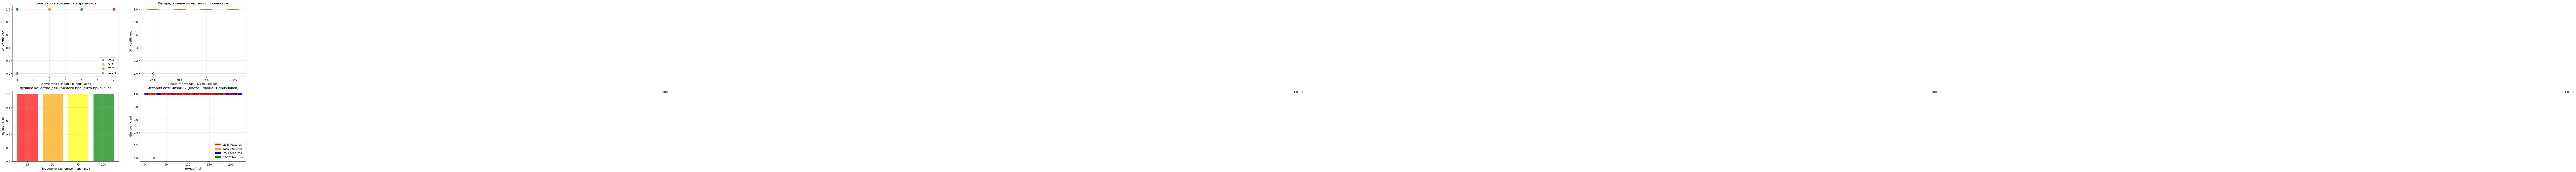

анализ важности признаков лучшей модели
Лучшая модель использует 25% признаков
Выбрано 1 признаков из 7
Gini: 1.0000
Параметры: {'C': 0.2537815508265665, 'solver': 'lbfgs', 'max_iter': 1955, 'keep_percent': 25}
10 важных признаков:
                feature  importance
0     tower_damage_diff    1.913900
1       xp_per_min_diff    1.293071
2     dire_gold_per_min    1.196946
3  radiant_gold_per_min    0.947283
4             gold_diff    0.879699
5            kills_diff    0.724812
6      hero_damage_diff    0.671846


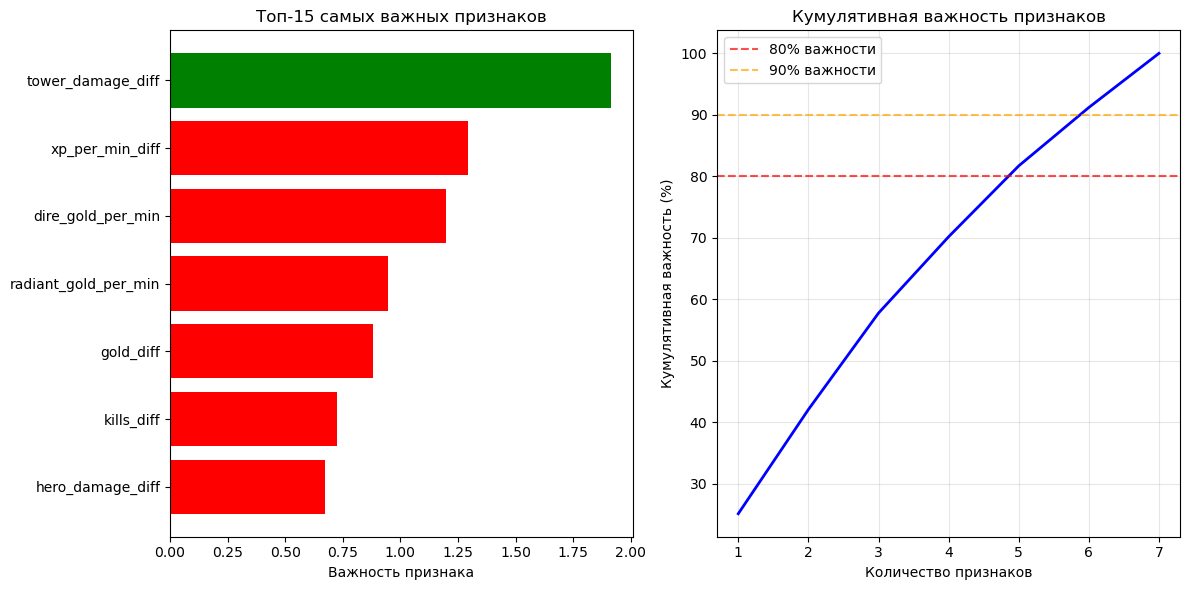

Анализ кумулятивной важности:
  - Для 80% важности нужно 5 признаков
  - Для 90% важности нужно 6 признаков
  - Лучшая модель использует 1 признаков
Сравнение с моделью без fs
Baseline study: logreg_basic_fixed
  Лучший Gini: 1.0000
  Количество trials: 90
Feature selection study: logreg_feature_selection
  Лучший Gini: 1.0000
  Количество trials: 225
Улучшение: 0.0000
Feature selection не улучшил качество


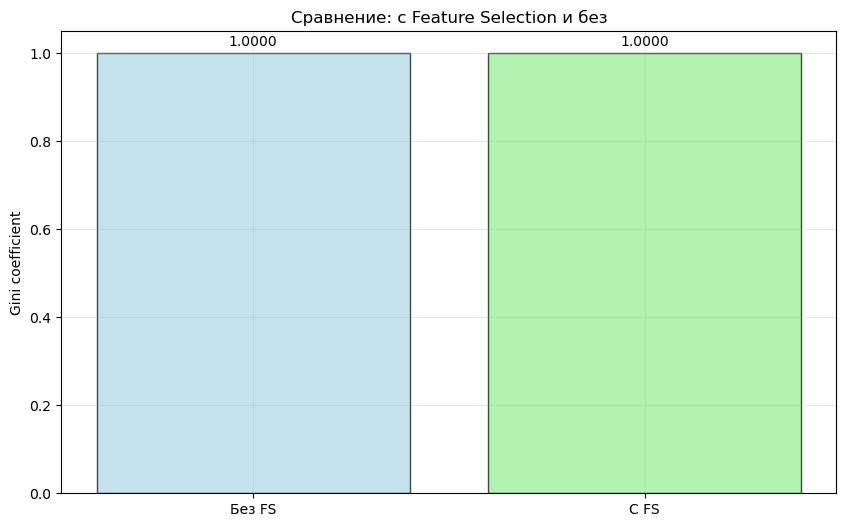

Результаты feature selection:
  Лучший процент признаков: 25%
  Количество выбранных признаков: 1
  Лучший Gini: 1.0000


In [140]:
import optuna
from optuna.samplers import TPESampler
from optuna.storages import RDBStorage
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

def calculate_gini(y_true, y_pred_proba):
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    gini = abs(2 * roc_auc - 1)
    return gini

def select_features_by_importance(model, X, feature_names, keep_percent):
    if hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0])
    else:
        importance = np.ones(X.shape[1])
    
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    n_features_to_keep = max(1, int(len(feature_names) * keep_percent / 100))
    
    selected_features = feature_importance.head(n_features_to_keep)['feature'].tolist()
    
    feature_mask = [feature in selected_features for feature in feature_names]
    
    return feature_mask, selected_features, feature_importance

def objective_with_feature_selection(trial):
    model_params = {
        'C': trial.suggest_float('C', 1e-3, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 500, 2000),
        'penalty': 'l2',
        'random_state': 42
    }
    
    if model_params['solver'] == 'saga':
        model_params['penalty'] = trial.suggest_categorical('penalty', ['l1', 'l2'])
    
    keep_percent = trial.suggest_categorical('keep_percent', [25, 50, 75, 100])
    
    trial.set_user_attr('model_type', 'LogisticRegression_with_FeatureSelection')
    trial.set_user_attr('feature_selection', 'importance_based')
    trial.set_user_attr('keep_percent', keep_percent)
    trial.set_user_attr('timestamp', datetime.now().isoformat())
    
    try:
        model_all_features = LogisticRegression(**model_params, n_jobs=-1)
        model_all_features.fit(optuna_data['X_train'], optuna_data['y_train'])
        
        feature_mask, selected_features, feature_importance = select_features_by_importance(
            model_all_features, 
            optuna_data['X_train'], 
            optuna_data['feature_names'], 
            keep_percent
        )
        
        X_train_selected = optuna_data['X_train'][:, feature_mask]
        X_val_selected = optuna_data['X_val'][:, feature_mask]
        
        model_selected = LogisticRegression(**model_params, n_jobs=-1)
        model_selected.fit(X_train_selected, optuna_data['y_train'])
        
        y_pred_proba = model_selected.predict_proba(X_val_selected)[:, 1]
        gini_valid = calculate_gini(optuna_data['y_val'], y_pred_proba)
        accuracy = accuracy_score(optuna_data['y_val'], model_selected.predict(X_val_selected))
        
        trial.set_user_attr('accuracy', float(accuracy))
        trial.set_user_attr('n_features_original', len(optuna_data['feature_names']))
        trial.set_user_attr('n_features_selected', len(selected_features))
        trial.set_user_attr('selected_features', selected_features)
        trial.set_user_attr('feature_importance', feature_importance.to_dict('records'))
        
        trial.set_user_attr('feature_reduction', f"{100 - keep_percent}%")
        trial.set_user_attr('features_kept', f"{keep_percent}%")
        
        print(f"Trial {trial.number}: {keep_percent}% features, Gini = {gini_valid:.4f}, "
              f"Features: {len(selected_features)}/{len(optuna_data['feature_names'])}")
        
        return gini_valid
        
    except Exception as e:
        trial.set_user_attr('error', str(e))
        print(f"Ошибка в trial {trial.number}: {e}")
        return 0.0

def run_feature_selection_optimization(study_name, n_trials=30):
    print(f"Number of trials: {n_trials}")
    
    storage = RDBStorage(f"sqlite:///optuna_storage/sqlite/{study_name}.db")
    
    try:
        study = optuna.create_study(
            direction='maximize',
            sampler=TPESampler(seed=42),
            study_name=study_name,
            storage=storage,
            load_if_exists=True
        )
        print(f"Study '{study_name}' создано/загружено")
    except Exception as e:
        print(f"Ошибка при создании study: {e}")
        study = optuna.create_study(
            direction='maximize',
            sampler=TPESampler(seed=42),
            study_name=study_name
        )
    
    study.set_user_attr('description', 'LogisticRegression with Feature Selection')
    study.set_user_attr('feature_selection_method', 'importance_based')
    study.set_user_attr('feature_percentages', [25, 50, 75, 100])
    study.set_user_attr('start_time', datetime.now().isoformat())
    
    study.optimize(objective_with_feature_selection, n_trials=n_trials, show_progress_bar=True)
    
    study.set_user_attr('end_time', datetime.now().isoformat())
    study.set_user_attr('total_trials', len(study.trials))
    study.set_user_attr('best_value', float(study.best_value))
    
    print(f"Оптимизация завершена! Лучший Gini: {study.best_value:.4f}")
    
    return study

study_fs = run_feature_selection_optimization(
    study_name="logreg_feature_selection",
    n_trials=25
)

def analyze_feature_selection_results(study):
    print("анализ результатов fs")
    
    trials_data = []
    for trial in study.trials:
        if trial.value is not None:
            trials_data.append({
                'trial_number': trial.number,
                'gini': trial.value,
                'keep_percent': trial.user_attrs.get('keep_percent', 100),
                'n_features_selected': trial.user_attrs.get('n_features_selected', 0),
                'n_features_original': trial.user_attrs.get('n_features_original', 0),
                'accuracy': trial.user_attrs.get('accuracy', 0),
                'solver': trial.params.get('solver', ''),
                'C': trial.params.get('C', 0),
                'penalty': trial.params.get('penalty', 'l2')
            })
    
    trials_df = pd.DataFrame(trials_data)
    
    if len(trials_df) == 0:
        print("Нет данных для анализа")
        return
    
    print("статистика по процентам fs:")
    stats_by_percent = trials_df.groupby('keep_percent').agg({
        'gini': ['mean', 'std', 'max', 'min'],
        'accuracy': 'mean',
        'trial_number': 'count'
    }).round(4)
    
    stats_by_percent.columns = ['Gini_mean', 'Gini_std', 'Gini_max', 'Gini_min', 'Accuracy_mean', 'Trials_count']
    print(stats_by_percent)
    
    print("лучшие результаты для каждого процента:")
    best_by_percent = trials_df.loc[trials_df.groupby('keep_percent')['gini'].idxmax()]
    print(best_by_percent[['keep_percent', 'gini', 'n_features_selected', 'solver', 'C']])
    
    return trials_df, stats_by_percent, best_by_percent

trials_df, stats_df, best_results = analyze_feature_selection_results(study_fs)

def visualize_feature_selection_results(study, trials_df):
    print("вазуализация результатов fs")
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    for percent in [25, 50, 75, 100]:
        percent_data = trials_df[trials_df['keep_percent'] == percent]
        plt.scatter(percent_data['n_features_selected'], percent_data['gini'], 
                   alpha=0.6, label=f'{percent}%', s=60)
    
    plt.xlabel('Количество выбранных признаков')
    plt.ylabel('Gini coefficient')
    plt.title('Качество vs количество признаков')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    data_to_plot = [trials_df[trials_df['keep_percent'] == p]['gini'].values for p in [25, 50, 75, 100]]
    plt.boxplot(data_to_plot, labels=['25%', '50%', '75%', '100%'])
    plt.xlabel('Процент оставленных признаков')
    plt.ylabel('Gini coefficient')
    plt.title('Распределение качества по процентам')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    best_by_percent = trials_df.loc[trials_df.groupby('keep_percent')['gini'].idxmax()]
    plt.bar(best_by_percent['keep_percent'].astype(str), best_by_percent['gini'], 
            color=['red', 'orange', 'yellow', 'green'], alpha=0.7)
    plt.xlabel('Процент оставленных признаков')
    plt.ylabel('Лучший Gini')
    plt.title('Лучшее качество для каждого процента признаков')
    
    for i, row in best_by_percent.iterrows():
        plt.text(row['keep_percent'], row['gini'] + 0.01, f'{row["gini"]:.4f}', 
                ha='center', va='bottom')
    
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    color_map = {25: 'red', 50: 'orange', 75: 'blue', 100: 'green'}
    
    for trial in study.trials:
        if trial.value is not None:
            percent = trial.user_attrs.get('keep_percent', 100)
            plt.scatter(trial.number, trial.value, 
                       color=color_map.get(percent, 'black'), 
                       alpha=0.6, s=50)
    
    best_values = []
    current_best = -np.inf
    for trial in sorted(study.trials, key=lambda x: x.number):
        if trial.value is not None and trial.value > current_best:
            current_best = trial.value
        best_values.append(current_best)
    
    plt.plot(range(len(best_values)), best_values, 'k-', linewidth=2, label='Лучшее значение')
    plt.xlabel('Номер Trial')
    plt.ylabel('Gini coefficient')
    plt.title('История оптимизации (цвета - процент признаков)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color_map[p], label=f'{p}% features') for p in [25, 50, 75, 100]]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()

if trials_df is not None:
    visualize_feature_selection_results(study_fs, trials_df)

def analyze_best_model_features(study):
    print("анализ важности признаков лучшей модели")
    
    best_trial = study.best_trial
    
    keep_percent = best_trial.user_attrs.get('keep_percent', 100)
    n_features_selected = best_trial.user_attrs.get('n_features_selected', 0)
    selected_features = best_trial.user_attrs.get('selected_features', [])
    feature_importance = best_trial.user_attrs.get('feature_importance', [])
    
    print(f"Лучшая модель использует {keep_percent}% признаков")
    print(f"Выбрано {n_features_selected} признаков из {best_trial.user_attrs.get('n_features_original', 0)}")
    print(f"Gini: {best_trial.value:.4f}")
    print(f"Параметры: {best_trial.params}")
    
    if feature_importance:
        importance_df = pd.DataFrame(feature_importance)
        importance_df = importance_df.sort_values('importance', ascending=False)
        
        print(f"10 важных признаков:")
        print(importance_df.head(10))
        
        plt.figure(figsize=(12, 6))
        
        top_features = importance_df.head(15)
        
        plt.subplot(1, 2, 1)
        colors = ['green' if feature in selected_features else 'red' for feature in top_features['feature']]
        plt.barh(range(len(top_features)), top_features['importance'], color=colors)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Важность признака')
        plt.title('Топ-15 самых важных признаков')
        plt.gca().invert_yaxis()
        
        plt.subplot(1, 2, 2)
        cumulative_importance = np.cumsum(importance_df['importance']) / np.sum(importance_df['importance'])
        plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance * 100, 'b-', linewidth=2)
        plt.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% важности')
        plt.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% важности')
        plt.xlabel('Количество признаков')
        plt.ylabel('Кумулятивная важность (%)')
        plt.title('Кумулятивная важность признаков')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        n_features_80 = np.argmax(cumulative_importance >= 0.8) + 1
        n_features_90 = np.argmax(cumulative_importance >= 0.9) + 1
        
        print(f"Анализ кумулятивной важности:")
        print(f"  - Для 80% важности нужно {n_features_80} признаков")
        print(f"  - Для 90% важности нужно {n_features_90} признаков")
        print(f"  - Лучшая модель использует {n_features_selected} признаков")
        
        return importance_df
    else:
        print("Нет данных о важности признаков")
        return None

importance_df = analyze_best_model_features(study_fs)

def compare_with_baseline(feature_selection_study, baseline_study_name="logreg_basic_fixed"):
    print("Сравнение с моделью без fs")
    
    try:
        baseline_storage = RDBStorage(f"sqlite:///optuna_storage/sqlite/{baseline_study_name}.db")
        baseline_study = optuna.load_study(study_name=baseline_study_name, storage=baseline_storage)
        
        print(f"Baseline study: {baseline_study_name}")
        print(f"  Лучший Gini: {baseline_study.best_value:.4f}")
        print(f"  Количество trials: {len(baseline_study.trials)}")
        
        print(f"Feature selection study: {feature_selection_study.study_name}")
        print(f"  Лучший Gini: {feature_selection_study.best_value:.4f}")
        print(f"  Количество trials: {len(feature_selection_study.trials)}")
        
        improvement = feature_selection_study.best_value - baseline_study.best_value
        print(f"Улучшение: {improvement:.4f}")
        
        if improvement > 0:
            improvement_pct = (improvement / baseline_study.best_value) * 100
            print(f"Улучшение на {improvement_pct:.2f}%")
        else:
            print("Feature selection не улучшил качество")
            
        plt.figure(figsize=(10, 6))
        
        models = ['Без FS', 'С FS']
        gini_values = [baseline_study.best_value, feature_selection_study.best_value]
        
        plt.bar(models, gini_values, color=['lightblue', 'lightgreen'], alpha=0.7, edgecolor='black')
        plt.ylabel('Gini coefficient')
        plt.title('Сравнение: с Feature Selection и без')
        
        for i, v in enumerate(gini_values):
            plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
        
        plt.grid(True, alpha=0.3)
        plt.show()
        
    except Exception as e:
        print(f"Не удалось загрузить baseline study: {e}")

compare_with_baseline(study_fs)

print(f"Результаты feature selection:")
if trials_df is not None:
    best_fs_trial = study_fs.best_trial
    keep_percent = best_fs_trial.user_attrs.get('keep_percent', 100)
    n_features = best_fs_trial.user_attrs.get('n_features_selected', 0)
    
    print(f"  Лучший процент признаков: {keep_percent}%")
    print(f"  Количество выбранных признаков: {n_features}")
    print(f"  Лучший Gini: {study_fs.best_value:.4f}")


Доступные колонки в matches_train:
['match_id', 'date', 'region', 'game_mode', 'duration', 'radiant_win', 'duration_filled', 'duration_missing', 'duration_category']

Доступные колонки в matches_test:
['match_id', 'date', 'region', 'game_mode', 'duration_filled', 'duration_missing']
Статистика duration в тренировочных данных:
  - Всего записей: 706880
  - Пропуски: 0 (0.00%)
  - Минимальное значение: 0
  - Максимальное значение: 14979
  - Среднее значение: 2536.48
  - Медиана: 2496.00
  - Стандартное отклонение: 731.38
В минутах:
  - Минимальное: 0.0 мин
  - Максимальное: 249.7 мин
  - Среднее: 42.3 мин
  - Медиана: 41.6 мин


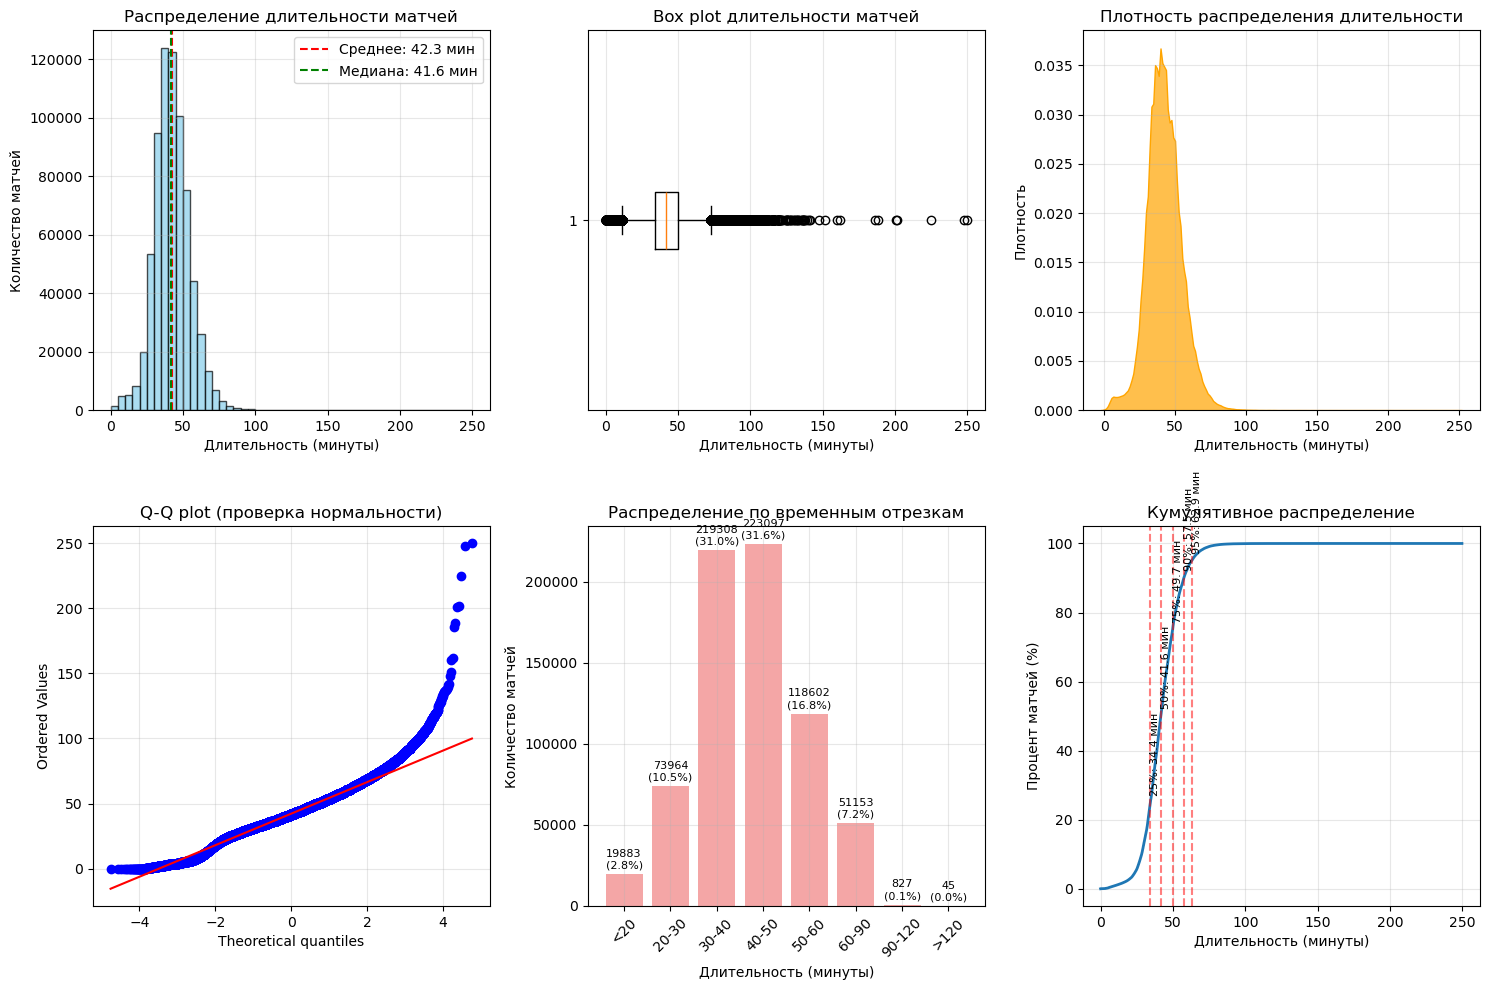

Распределение по временным отрезкам:
  <20 мин: 19883 матчей (2.8%)
  20-30 мин: 73964 матчей (10.5%)
  30-40 мин: 219308 матчей (31.0%)
  40-50 мин: 223097 матчей (31.6%)
  50-60 мин: 118602 матчей (16.8%)
  60-90 мин: 51153 матчей (7.2%)
  90-120 мин: 827 матчей (0.1%)
  >120 мин: 45 матчей (0.0%)
Анализ связи duration с победой radiant
Статистика по категориям длительности:
                     Количество матчей  Процент побед radiant
duration_category                                            
Короткие (<25 мин)               40087                  0.567
Средние (25-40 мин)             273509                  0.544
Длинные (>40 мин)               393241                  0.485


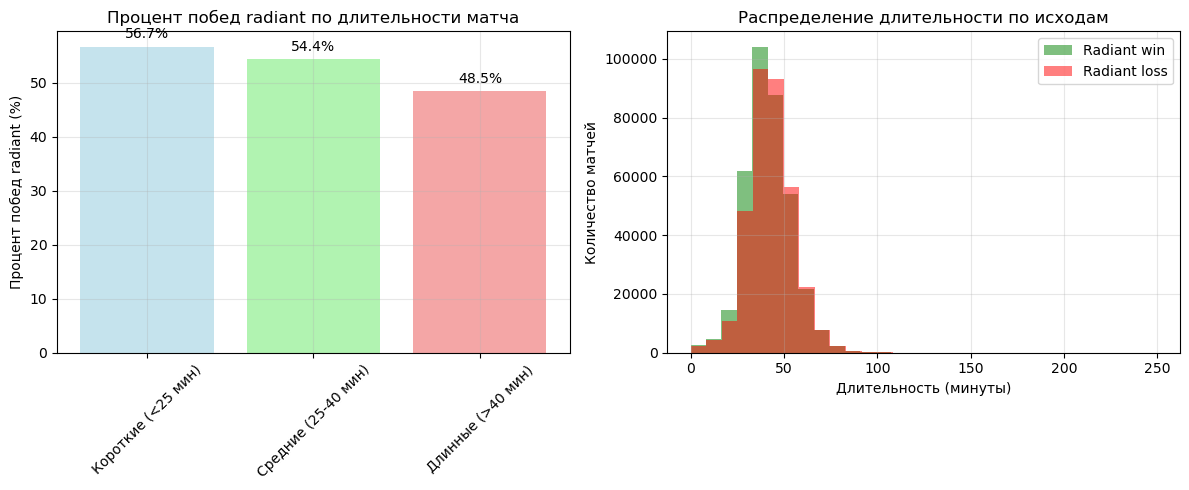

Статистический тест:
  t-статистика: -49.063
  p-value: 0.000
  Есть статистически значимая разница в длительности между победами и поражениями radiant
Сравнение методов заполнения пропусков
Тестируем на 706880 матчах с 140854 искусственными пропусками
Ошибка при регрессионном заполнении: at least one array or dtype is required
Сравнение методов заполнения:
       Метод       MAE  MAE_минуты      R2
0    Медиана  562.8585      9.3810 -0.0031
1    Среднее  563.8016      9.3967 -0.0000
2  Случайное  805.6038     13.4267 -0.9955
3  Регрессия  562.8585      9.3810 -0.0031


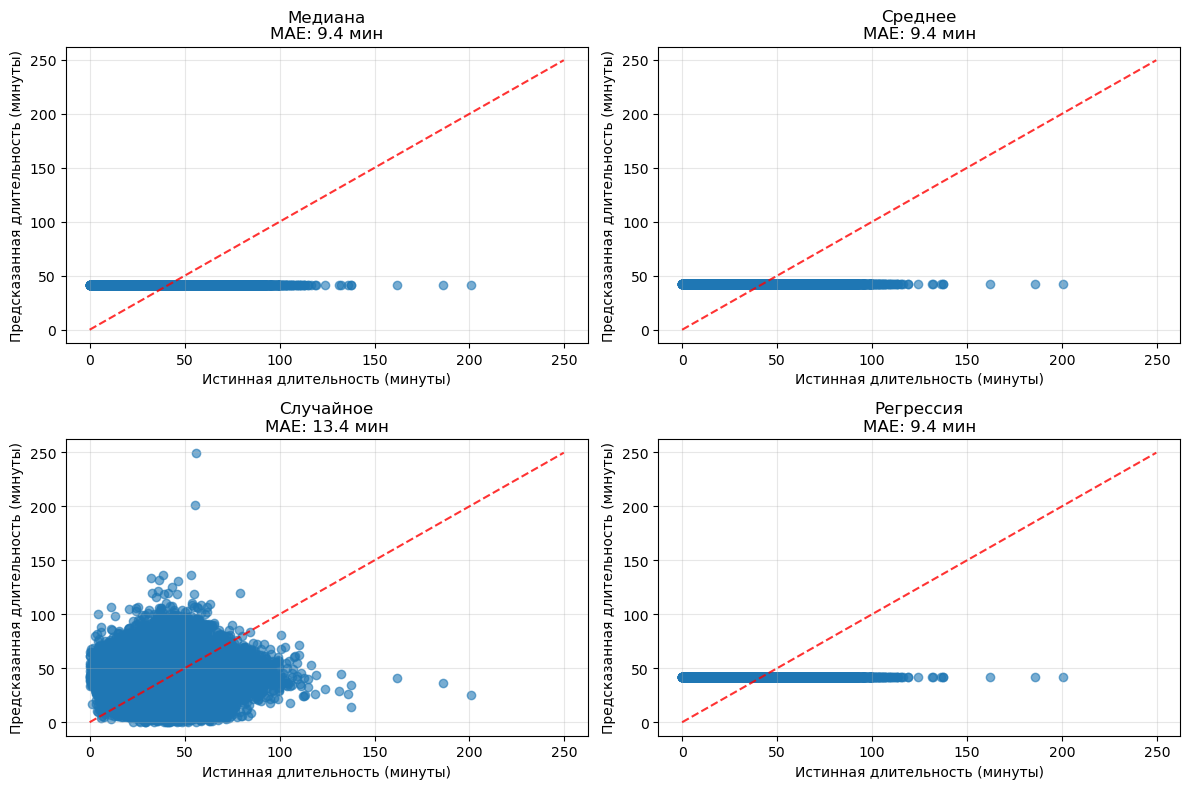

Реализация лучшей стратегии заполнения
Выбран лучший метод: Медиана
   MAE: 9.38 минут
   R²: -0.0031
Заполнено пропусков в тренировочных данных: 0
   Использовано значение: 41.6 минут
Создан категориальный признак duration_category в тренировочных данных
Создан категориальный признак duration_category в тестовых данных
Создан признак duration_missing в тренировочных данных
Создан признак duration_missing в тестовых данных
Проверка результатов заполнения
Тренировочные данные:
  - duration_filled: 0 пропусков
  - duration_missing: 0 матчей с исходными пропусками
  - duration_category: 1 пропусков

Тестовые данные:
  - duration_filled: 0 пропусков
  - duration_missing: 60954 матчей с пропусками
  - duration_category: 60954 пропусков


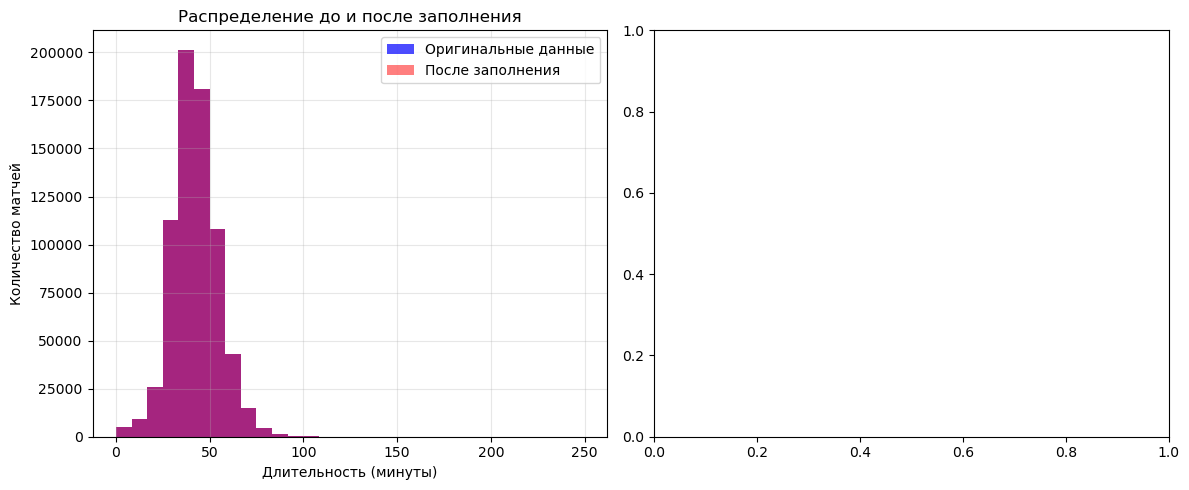

Выводы из анализа:
  - Длительность матчей: 0.0 - 249.7 минут
  - Типичная длительность: 41.6 минут (медиана)
  - Распределение: 0.30 (скошенность)


In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

print("Доступные колонки в matches_train:")
print(matches_train.columns.tolist())

print("\nДоступные колонки в matches_test:")
print(matches_test.columns.tolist())

if 'duration' in matches_train.columns:
    duration_data = matches_train['duration'].copy()
    print(f"Статистика duration в тренировочных данных:")
    print(f"  - Всего записей: {len(duration_data)}")
    print(f"  - Пропуски: {duration_data.isnull().sum()} ({duration_data.isnull().mean()*100:.2f}%)")
    print(f"  - Минимальное значение: {duration_data.min()}")
    print(f"  - Максимальное значение: {duration_data.max()}")
    print(f"  - Среднее значение: {duration_data.mean():.2f}")
    print(f"  - Медиана: {duration_data.median():.2f}")
    print(f"  - Стандартное отклонение: {duration_data.std():.2f}")
    
    duration_minutes = duration_data / 60
    print(f"В минутах:")
    print(f"  - Минимальное: {duration_minutes.min():.1f} мин")
    print(f"  - Максимальное: {duration_minutes.max():.1f} мин")
    print(f"  - Среднее: {duration_minutes.mean():.1f} мин")
    print(f"  - Медиана: {duration_minutes.median():.1f} мин")
else:
    print("Колонка 'duration' не найдена в matches_train")
    duration_data = None

def visualize_duration_distribution(duration_series):
    if duration_series is None:
        return
    
    duration_minutes = duration_series / 60
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    plt.hist(duration_minutes, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
    plt.xlabel('Длительность (минуты)')
    plt.ylabel('Количество матчей')
    plt.title('Распределение длительности матчей')
    plt.grid(True, alpha=0.3)
    
    plt.axvline(duration_minutes.mean(), color='red', linestyle='--', label=f'Среднее: {duration_minutes.mean():.1f} мин')
    plt.axvline(duration_minutes.median(), color='green', linestyle='--', label=f'Медиана: {duration_minutes.median():.1f} мин')
    plt.legend()
    
    plt.subplot(2, 3, 2)
    plt.boxplot(duration_minutes, vert=False)
    plt.xlabel('Длительность (минуты)')
    plt.title('Box plot длительности матчей')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 3)
    sns.kdeplot(duration_minutes, fill=True, color='orange', alpha=0.7)
    plt.xlabel('Длительность (минуты)')
    plt.ylabel('Плотность')
    plt.title('Плотность распределения длительности')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 4)
    from scipy import stats
    stats.probplot(duration_minutes, dist="norm", plot=plt)
    plt.title('Q-Q plot (проверка нормальности)')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 5)
    bins = [0, 20, 30, 40, 50, 60, 90, 120, duration_minutes.max()]
    labels = ['<20', '20-30', '30-40', '40-50', '50-60', '60-90', '90-120', '>120']
    duration_binned = pd.cut(duration_minutes, bins=bins, labels=labels, right=False)
    duration_counts = duration_binned.value_counts().sort_index()
    
    plt.bar(duration_counts.index, duration_counts.values, color='lightcoral', alpha=0.7)
    plt.xlabel('Длительность (минуты)')
    plt.ylabel('Количество матчей')
    plt.title('Распределение по временным отрезкам')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    for i, v in enumerate(duration_counts.values):
        plt.text(i, v + duration_counts.max()*0.01, f'{v}\n({v/len(duration_minutes)*100:.1f}%)', 
                ha='center', va='bottom', fontsize=8)
    
    plt.subplot(2, 3, 6)
    sorted_duration = np.sort(duration_minutes)
    cumulative = np.arange(1, len(sorted_duration) + 1) / len(sorted_duration)
    plt.plot(sorted_duration, cumulative * 100, linewidth=2)
    plt.xlabel('Длительность (минуты)')
    plt.ylabel('Процент матчей (%)')
    plt.title('Кумулятивное распределение')
    plt.grid(True, alpha=0.3)
    
    for percentile in [25, 50, 75, 90, 95]:
        value = np.percentile(duration_minutes, percentile)
        plt.axvline(value, color='red', linestyle='--', alpha=0.5)
        plt.text(value, percentile + 2, f'{percentile}%: {value:.1f} мин', 
                rotation=90, va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Распределение по временным отрезкам:")
    for label, count in duration_counts.items():
        percentage = count / len(duration_minutes) * 100
        print(f"  {label} мин: {count} матчей ({percentage:.1f}%)")

if duration_data is not None:
    visualize_duration_distribution(duration_data)

def analyze_duration_target_relationship(matches_df):
    if 'duration' not in matches_df.columns or 'radiant_win' not in matches_df.columns:
        print("Недостаточно данных для анализа связи")
        return
    
    print(f"Анализ связи duration с победой radiant")
    
    analysis_df = matches_df[['duration', 'radiant_win']].dropna().copy()
    analysis_df['duration_minutes'] = analysis_df['duration'] / 60
    
    bins = [0, 25, 40, analysis_df['duration_minutes'].max()]
    labels = ['Короткие (<25 мин)', 'Средние (25-40 мин)', 'Длинные (>40 мин)']
    analysis_df['duration_category'] = pd.cut(analysis_df['duration_minutes'], bins=bins, labels=labels)
    
    category_stats = analysis_df.groupby('duration_category').agg({
        'radiant_win': ['count', 'mean']
    }).round(3)
    category_stats.columns = ['Количество матчей', 'Процент побед radiant']
    
    print("Статистика по категориям длительности:")
    print(category_stats)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    win_rates = category_stats['Процент побед radiant']
    plt.bar(win_rates.index, win_rates.values * 100, color=['lightblue', 'lightgreen', 'lightcoral'], alpha=0.7)
    plt.ylabel('Процент побед radiant (%)')
    plt.title('Процент побед radiant по длительности матча')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    for i, v in enumerate(win_rates.values):
        plt.text(i, v * 100 + 1, f'{v*100:.1f}%', ha='center', va='bottom')
    
    plt.subplot(1, 2, 2)
    radiant_wins = analysis_df[analysis_df['radiant_win'] == True]['duration_minutes']
    radiant_losses = analysis_df[analysis_df['radiant_win'] == False]['duration_minutes']
    
    plt.hist(radiant_wins, bins=30, alpha=0.5, label='Radiant win', color='green')
    plt.hist(radiant_losses, bins=30, alpha=0.5, label='Radiant loss', color='red')
    plt.xlabel('Длительность (минуты)')
    plt.ylabel('Количество матчей')
    plt.title('Распределение длительности по исходам')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    from scipy.stats import ttest_ind
    t_stat, p_value = ttest_ind(radiant_wins, radiant_losses, equal_var=False)
    print(f"Статистический тест:")
    print(f"  t-статистика: {t_stat:.3f}")
    print(f"  p-value: {p_value:.3f}")
    
    if p_value < 0.05:
        print("  Есть статистически значимая разница в длительности между победами и поражениями radiant")
    else:
        print("  Нет статистически значимой разницы в длительности")

analyze_duration_target_relationship(matches_train)

def compare_imputation_methods():
    print(f"Сравнение методов заполнения пропусков")
    
    if 'duration' not in matches_train.columns:
        print("Колонка 'duration' не найдена")
        return
    
    complete_data = matches_train[['duration']].dropna().copy()
    
    if len(complete_data) == 0:
        print("Нет данных для тестирования методов")
        return
    
    np.random.seed(42)
    missing_mask = np.random.random(len(complete_data)) < 0.2
    test_data = complete_data.copy()
    test_data.loc[missing_mask, 'duration'] = np.nan
    
    print(f"Тестируем на {len(complete_data)} матчах с {missing_mask.sum()} искусственными пропусками")
    
    median_imputed = test_data['duration'].fillna(complete_data['duration'].median())
    
    mean_imputed = test_data['duration'].fillna(complete_data['duration'].mean())
    
    random_imputed = test_data['duration'].copy()
    random_values = np.random.choice(complete_data['duration'].values, size=missing_mask.sum(), replace=True)
    random_imputed[missing_mask] = random_values
    
    try:
        if 'player_df' in globals() and 'match_id' in matches_train.columns:
            features_for_prediction = []
            
            for match_id in complete_data.index:
                match_players = player_df[player_df['match_id'] == match_id]
                if len(match_players) == 10:
                    stats = {
                        'total_kills': match_players['kills'].sum(),
                        'total_gold': match_players['gold'].sum(),
                        'avg_gold_per_min': match_players['gold_per_min'].mean(),
                        'total_hero_damage': match_players['hero_damage'].sum()
                    }
                    features_for_prediction.append(stats)
                else:
                    features_for_prediction.append({})
            
            if len(features_for_prediction) == len(complete_data):
                features_df = pd.DataFrame(features_for_prediction)
                features_df = features_df.fillna(features_df.median())
                
                train_mask = ~missing_mask
                X_train = features_df[train_mask]
                y_train = complete_data.loc[train_mask, 'duration']
                X_test = features_df[missing_mask]
                
                if len(X_train) > 0 and len(X_test) > 0:
                    model = LinearRegression()
                    model.fit(X_train, y_train)
                    predicted_values = model.predict(X_test)
                    
                    regression_imputed = test_data['duration'].copy()
                    regression_imputed[missing_mask] = np.maximum(0, predicted_values)
                else:
                    regression_imputed = median_imputed
            else:
                regression_imputed = median_imputed
        else:
            regression_imputed = median_imputed
    except Exception as e:
        print(f"Ошибка при регрессионном заполнении: {e}")
        regression_imputed = median_imputed
    
    true_values = complete_data['duration']
    
    methods = {
        'Медиана': median_imputed,
        'Среднее': mean_imputed,
        'Случайное': random_imputed,
        'Регрессия': regression_imputed
    }
    
    results = []
    for method_name, imputed_values in methods.items():
        mae = mean_absolute_error(true_values[missing_mask], imputed_values[missing_mask])
        r2 = r2_score(true_values[missing_mask], imputed_values[missing_mask])
        results.append({
            'Метод': method_name,
            'MAE': mae,
            'MAE_минуты': mae / 60,
            'R2': r2
        })
    
    results_df = pd.DataFrame(results)
    print("Сравнение методов заполнения:")
    print(results_df.round(4))
    
    plt.figure(figsize=(12, 8))
    
    for i, (method_name, imputed_values) in enumerate(methods.items(), 1):
        plt.subplot(2, 2, i)
        plt.scatter(true_values[missing_mask] / 60, imputed_values[missing_mask] / 60, alpha=0.6)
        plt.plot([0, true_values.max() / 60], [0, true_values.max() / 60], 'r--', alpha=0.8)
        plt.xlabel('Истинная длительность (минуты)')
        plt.ylabel('Предсказанная длительность (минуты)')
        plt.title(f'{method_name}\nMAE: {mean_absolute_error(true_values[missing_mask], imputed_values[missing_mask]) / 60:.1f} мин')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results_df

imputation_results = compare_imputation_methods()

def implement_best_imputation_strategy():
    print(f"Реализация лучшей стратегии заполнения")
    
    best_method = "Медиана"
    
    if imputation_results is not None:
        best_method_row = imputation_results.loc[imputation_results['MAE'].idxmin()]
        best_method = best_method_row['Метод']
        print(f"Выбран лучший метод: {best_method}")
        print(f"   MAE: {best_method_row['MAE_минуты']:.2f} минут")
        print(f"   R²: {best_method_row['R2']:.4f}")
    
    if 'duration' in matches_train.columns:
        train_duration = matches_train['duration'].copy()
        original_missing = train_duration.isnull().sum()
        
        if best_method == "Медиана":
            fill_value = train_duration.median()
        elif best_method == "Среднее":
            fill_value = train_duration.mean()
        else:
            fill_value = train_duration.median()
        
        train_duration_filled = train_duration.fillna(fill_value)
        matches_train['duration_filled'] = train_duration_filled
        
        print(f"Заполнено пропусков в тренировочных данных: {original_missing}")
        print(f"   Использовано значение: {fill_value / 60:.1f} минут")
    
    def create_duration_categories(duration_series):
        duration_minutes = duration_series / 60
        
        max_duration = duration_minutes.max()
        bins = [0, 20, 30, 40, 50, 60]
        
        if max_duration > bins[-1]:
            bins.append(max_duration)
        else:
            bins = [b for b in bins if b <= max_duration]
            bins.append(max_duration)
        
        labels = ['very_short', 'short', 'medium', 'long', 'very_long', 'extreme'][:len(bins)-1]
        
        return pd.cut(duration_minutes, bins=bins, labels=labels, right=False)
    
    if 'duration_filled' in matches_train.columns:
        matches_train['duration_category'] = create_duration_categories(matches_train['duration_filled'])
        print(f"Создан категориальный признак duration_category в тренировочных данных")
    
    if 'duration_filled' in matches_test.columns:
        matches_test['duration_category'] = create_duration_categories(matches_test['duration_filled'])
        print(f"Создан категориальный признак duration_category в тестовых данных")
    
    if 'duration' in matches_train.columns:
        matches_train['duration_missing'] = matches_train['duration'].isnull().astype(int)
        print(f"Создан признак duration_missing в тренировочных данных")
    
    matches_test['duration_missing'] = 1
    print(f"Создан признак duration_missing в тестовых данных")
    
    return best_method

best_imputation_method = implement_best_imputation_strategy()

def verify_imputation_results():
    print("Проверка результатов заполнения")
    
    print("Тренировочные данные:")
    if 'duration_filled' in matches_train.columns:
        print(f"  - duration_filled: {matches_train['duration_filled'].isnull().sum()} пропусков")
        print(f"  - duration_missing: {matches_train['duration_missing'].sum()} матчей с исходными пропусками")
        if 'duration_category' in matches_train.columns:
            print(f"  - duration_category: {matches_train['duration_category'].isnull().sum()} пропусков")
    
    print("\nТестовые данные:")
    if 'duration_filled' in matches_test.columns:
        print(f"  - duration_filled: {matches_test['duration_filled'].isnull().sum()} пропусков")
        print(f"  - duration_missing: {matches_test['duration_missing'].sum()} матчей с пропусками")
        if 'duration_category' in matches_test.columns:
            print(f"  - duration_category: {matches_test['duration_category'].isnull().sum()} пропусков")
    
    if 'duration' in matches_train.columns and 'duration_filled' in matches_train.columns:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        original_duration = matches_train['duration'].dropna() / 60
        filled_duration = matches_train['duration_filled'] / 60
        
        plt.hist(original_duration, bins=30, alpha=0.7, label='Оригинальные данные', color='blue')
        plt.hist(filled_duration, bins=30, alpha=0.5, label='После заполнения', color='red')
        plt.xlabel('Длительность (минуты)')
        plt.ylabel('Количество матчей')
        plt.title('Распределение до и после заполнения')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        missing_mask = matches_train['duration'].isnull()
        imputed_values = filled_duration[missing_mask]
        
        if len(imputed_values) > 0:
            plt.hist(imputed_values, bins=20, alpha=0.7, color='orange')
            plt.xlabel('Длительность заполненных значений (минуты)')
            plt.ylabel('Количество')
            plt.title('Распределение заполненных значений')
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

verify_imputation_results()

print(f"Выводы из анализа:")
if duration_data is not None:
    duration_minutes = duration_data / 60
    print(f"  - Длительность матчей: {duration_minutes.min():.1f} - {duration_minutes.max():.1f} минут")
    print(f"  - Типичная длительность: {duration_minutes.median():.1f} минут (медиана)")
    print(f"  - Распределение: {duration_minutes.skew():.2f} (скошенность)")


#### Задание 3.2. Простейшие преобразования (0.5 балла)

В жизни рядового датасаентиста часто возникает такая ситуация, что фича, которая ну должна быть клевой, на практике оказывается тем еще отстоем. Причин тому может быть несколько: признак действительно может быть нерелевантным, в данных банально может быть ошибка; либо же мы просто неправильно этот признак готовим. Народная мудрсть (и душнилы-математики) гласит, что признаки желательно подбирать из нормального распределения в случае L2-регуляризации, тогда как на практике это достигается ой как не всегда.

Сделаем следующее:

1. Посмотрите на гистограмму признака `duration`, если вы не сделали этого до. Что вы можете сказать про смещение, среднее, хвосты распределения этого признака?
2. Изучите три распространенных способа сделать признак $y$ ($y$ здесь и ниже это `duration`, не таргет) чуть более нормальным:

$$y \rightarrow \log y,  \sqrt{y}, \frac{1}{y}$$

Посмотрите, что происходит с распределением, если применить каждое из них.

3. Попробуйте добавить все три вышеперечисленных трансформации, вместе с признаком $\exp{\log{y}}$ (это снова `duration`).

Статистики исходного распределения:
  - Размер: 706880
  - Минимум: 0.00 мин
  - Максимум: 249.65 мин
  - Среднее: 42.27 мин
  - Медиана: 41.60 мин
  - Стандартное отклонение: 12.19 мин
  - Скошенность (skewness): 0.2953
  - Эксцесс (kurtosis): 1.6298
  - Тест Шапиро-Уилка: p-value = 0.000000
  Распределение не нормальное (p < 0.05)


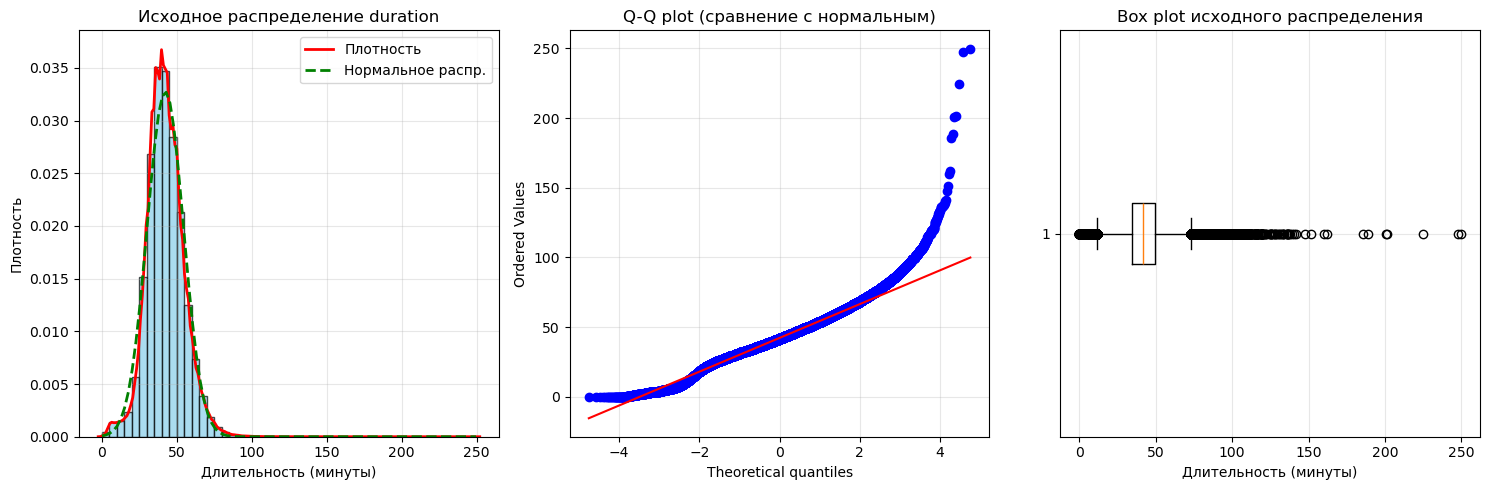


Применение преобразований
Статистики преобразованных распределений:

  LOG:
    - Скошенность: -1.9004
    - Эксцесс: 9.4115
    - Shapiro p-value: 0.000000
    - Нормальное: Нет

  SQRT:
    - Скошенность: -0.5788
    - Эксцесс: 2.3424
    - Shapiro p-value: 0.000000
    - Нормальное: Нет

  BOXCOX:
    - Скошенность: 0.1113
    - Эксцесс: 1.4081
    - Shapiro p-value: 0.000000
    - Нормальное: Нет

  RECIPROCAL:
    - Скошенность: 19.0319
    - Эксцесс: 765.6803
    - Shapiro p-value: 0.000000
    - Нормальное: Нет

  YEOJOHNSON:
    - Скошенность: 0.1113
    - Эксцесс: 1.4081
    - Shapiro p-value: 0.000000
    - Нормальное: Нет

Рейтинг преобразований (по близости к нормальному):
  3. boxcox: скошенность=0.1113 -
  5. yeojohnson: скошенность=0.1113 -
  2. sqrt: скошенность=-0.5788 -
  1. log: скошенность=-1.9004 -
  4. reciprocal: скошенность=19.0319 -


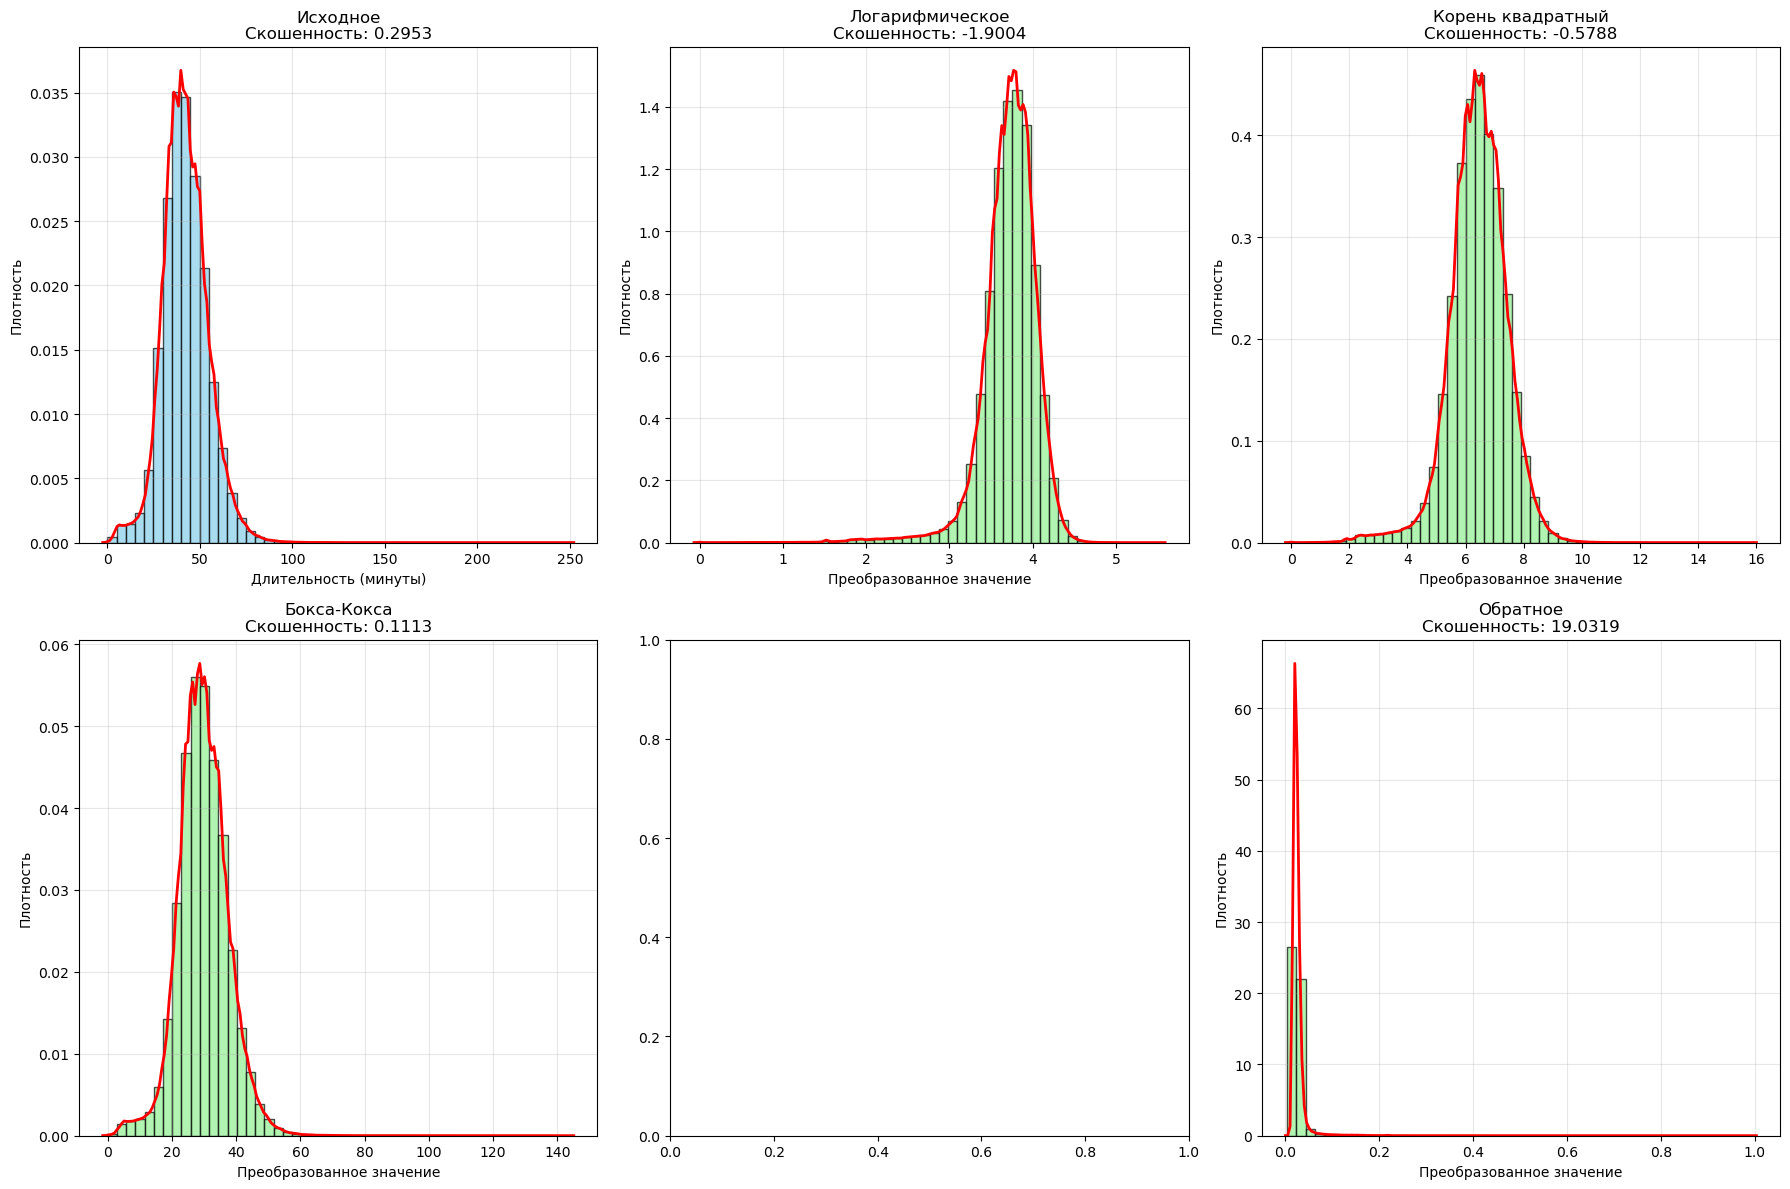

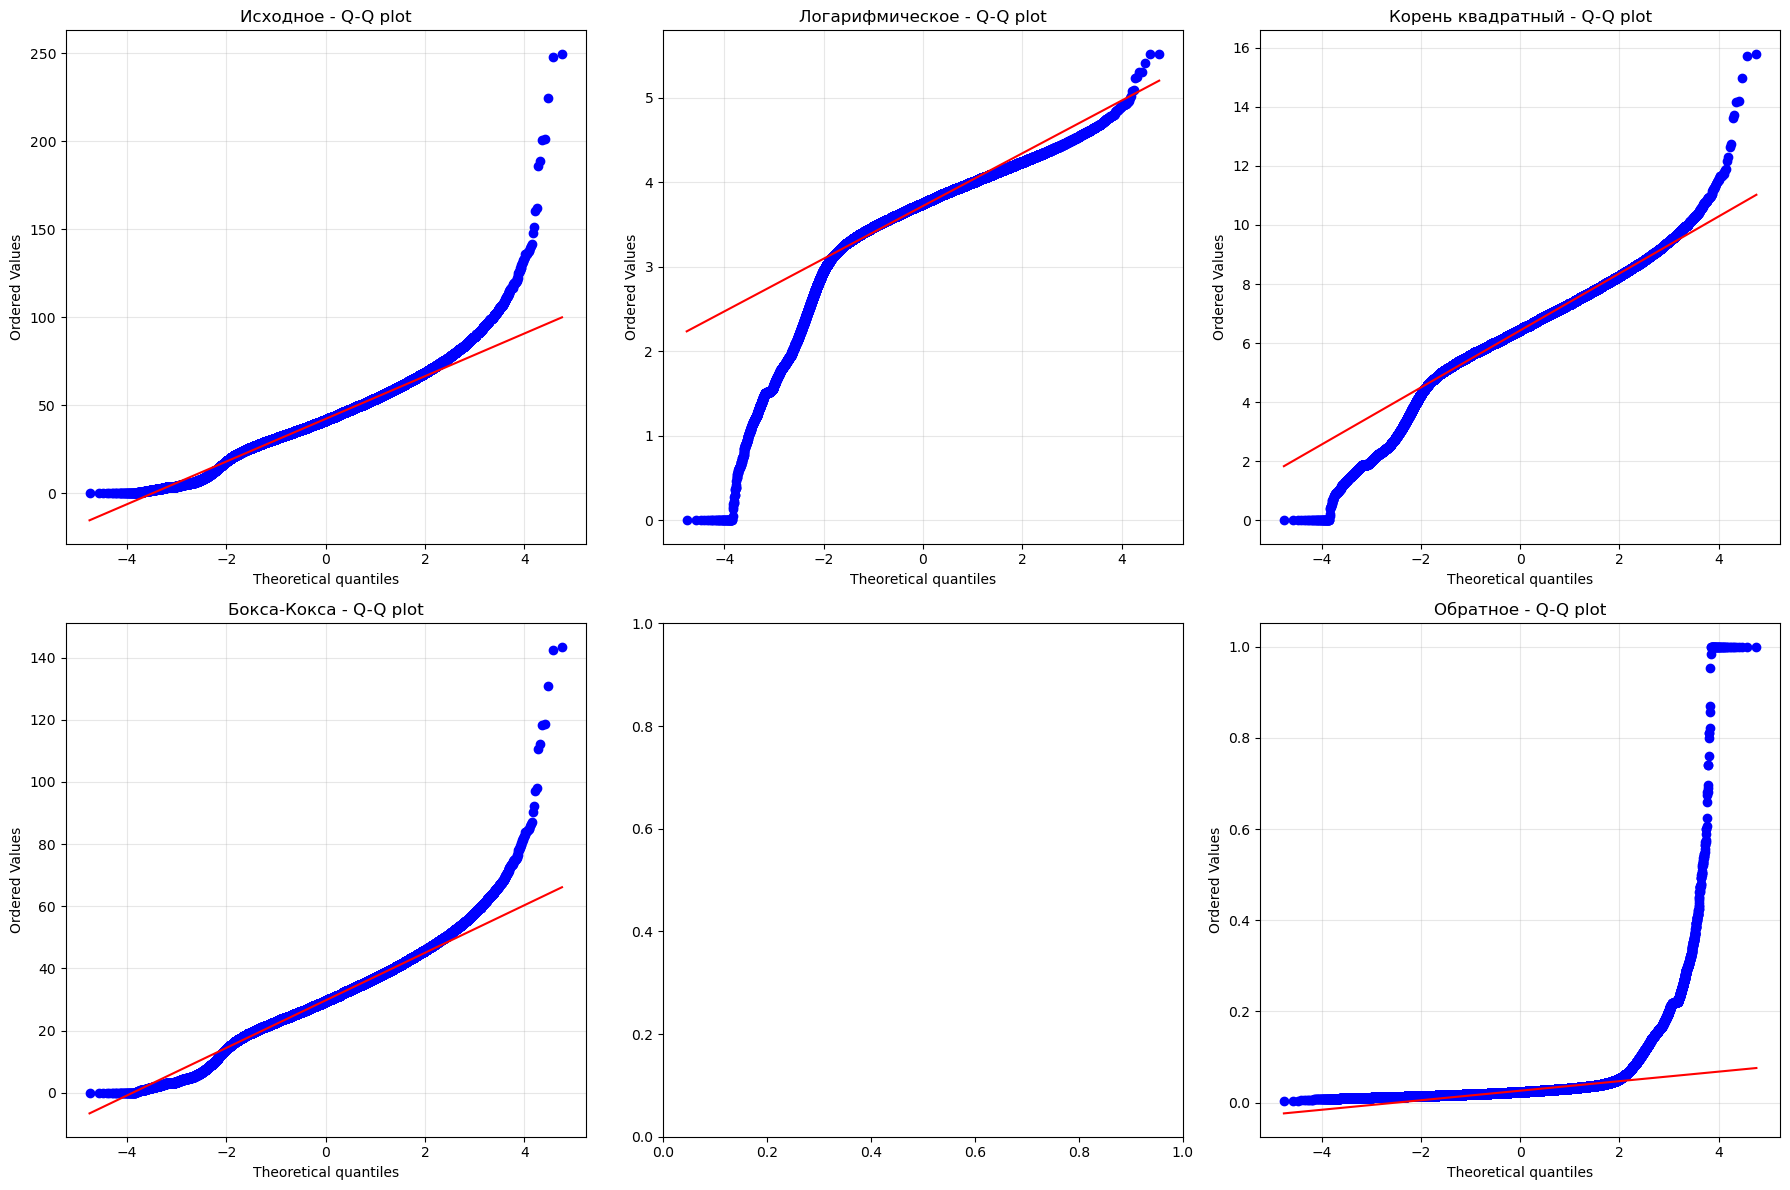


Сравнение эффективности преобразований
Рейтинг преобразований:
  Преобразование  Абс. скошенность  Абс. эксцесс  Shapiro p-value  \
2         boxcox            0.1113        1.4081              0.0   
4     yeojohnson            0.1113        1.4081              0.0   
1           sqrt            0.5788        2.3424              0.0   
0            log            1.9004        9.4115              0.0   
3     reciprocal           19.0319      765.6803              0.0   

   Score_скошенность  Score_нормальность  Общий score  
2             0.8998                 0.0       0.4499  
4             0.8998                 0.0       0.4499  
1             0.6334                 0.0       0.3167  
0             0.3448                 0.0       0.1724  
3             0.0499                 0.0       0.0250  


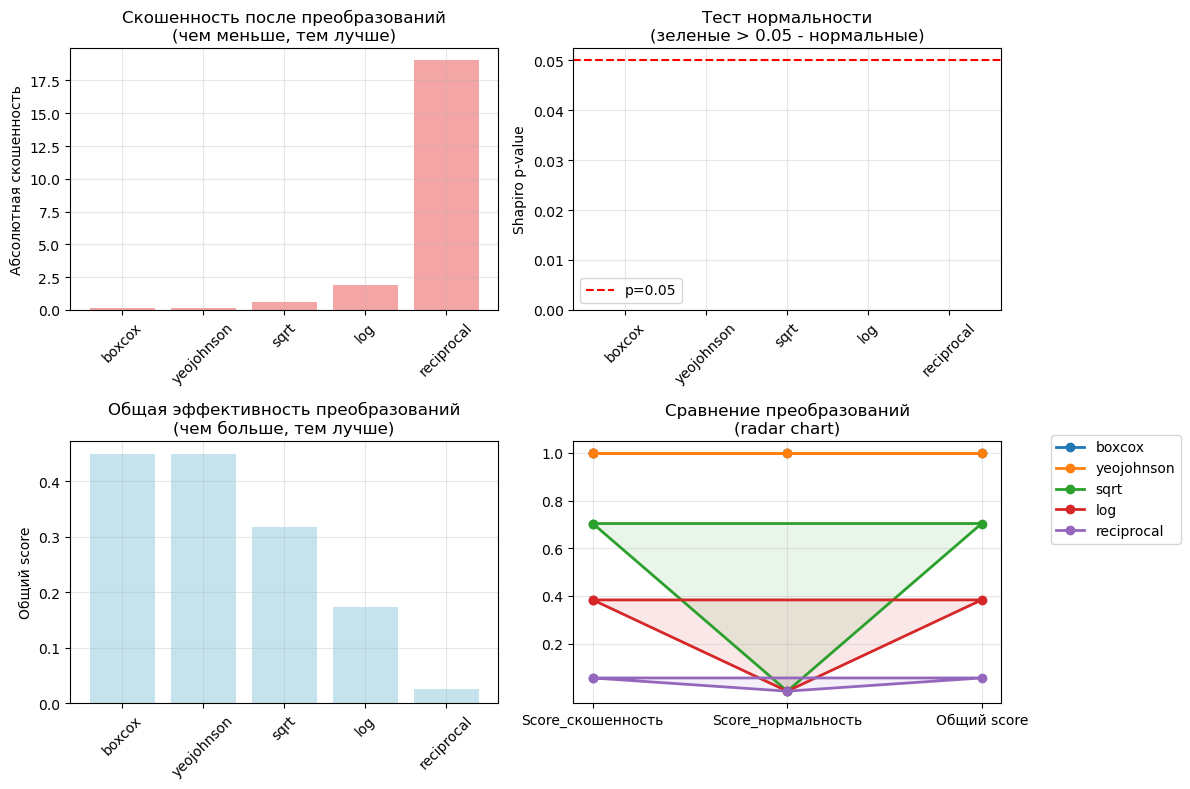


Добавление преобразованных признаков в данные
Добавлено преобразованных признаков: 5
Список добавленных признаков:
  - duration_log
  - duration_sqrt
  - duration_boxcox
  - duration_reciprocal
  - duration_yeojohnson

Проверка добавления:
  Тренировочные данные: 8 признаков duration
  Тестовые данные: 8 признаков duration

Итоговый отчет по преобразованиям

Результаты анализа:
  - Лучшее преобразование: boxcox (score: 0.4499)
  - Исходная скошенность: 0.2953
  - Скошенность после boxcox: 0.1113
  - Улучшение скошенности: 0.1840


In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.special import boxcox
from sklearn.preprocessing import PowerTransformer
import warnings
warnings.filterwarnings('ignore')

if 'duration_filled' in matches_train.columns:
    duration_original = matches_train['duration_filled'].copy()
else:
    duration_original = matches_train['duration'].copy()
    duration_original = duration_original.fillna(duration_original.median())

duration_minutes = duration_original / 60

print("Статистики исходного распределения:")
print(f"  - Размер: {len(duration_minutes)}")
print(f"  - Минимум: {duration_minutes.min():.2f} мин")
print(f"  - Максимум: {duration_minutes.max():.2f} мин")
print(f"  - Среднее: {duration_minutes.mean():.2f} мин")
print(f"  - Медиана: {duration_minutes.median():.2f} мин")
print(f"  - Стандартное отклонение: {duration_minutes.std():.2f} мин")
print(f"  - Скошенность (skewness): {duration_minutes.skew():.4f}")
print(f"  - Эксцесс (kurtosis): {duration_minutes.kurtosis():.4f}")

shapiro_stat, shapiro_p = stats.shapiro(duration_minutes)
print(f"  - Тест Шапиро-Уилка: p-value = {shapiro_p:.6f}")

if shapiro_p < 0.05:
    print("  Распределение не нормальное (p < 0.05)")
else:
    print("  Распределение нормальное (p >= 0.05)")

def plot_original_distribution(duration_data):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(duration_data, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    sns.kdeplot(duration_data, color='red', linewidth=2, label='Плотность')
    
    x_norm = np.linspace(duration_data.min(), duration_data.max(), 100)
    y_norm = stats.norm.pdf(x_norm, duration_data.mean(), duration_data.std())
    plt.plot(x_norm, y_norm, 'g--', linewidth=2, label='Нормальное распр.')
    
    plt.xlabel('Длительность (минуты)')
    plt.ylabel('Плотность')
    plt.title('Исходное распределение duration')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    stats.probplot(duration_data, dist="norm", plot=plt)
    plt.title('Q-Q plot (сравнение с нормальным)')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    plt.boxplot(duration_data, vert=False)
    plt.xlabel('Длительность (минуты)')
    plt.title('Box plot исходного распределения')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_original_distribution(duration_minutes)

def apply_transformations(duration_data):
    data_positive = duration_data + 1
    
    transformations = {}
    
    transformations['log'] = np.log(data_positive)
    
    transformations['sqrt'] = np.sqrt(duration_data)
    
    try:
        data_boxcox, lambda_boxcox = stats.boxcox(data_positive)
        transformations['boxcox'] = data_boxcox
        transformations['boxcox_lambda'] = lambda_boxcox
    except Exception as e:
        print(f"Ошибка в Box-Cox преобразовании: {e}")
        transformations['boxcox'] = data_positive
    
    transformations['reciprocal'] = 1 / data_positive
    
    pt = PowerTransformer(method='yeo-johnson')
    yeojohnson_data = pt.fit_transform(duration_data.values.reshape(-1, 1)).flatten()
    transformations['yeojohnson'] = yeojohnson_data
    
    return transformations

print("\nПрименение преобразований")
transformations = apply_transformations(duration_minutes)

def analyze_transformed_distributions(original_data, transformed_data):
    print("Статистики преобразованных распределений:")
    stats_results = []
    
    for name, data in transformed_data.items():
        if name == 'boxcox_lambda':
            continue
            
        skewness = stats.skew(data)
        kurt = stats.kurtosis(data)
        shapiro_stat, shapiro_p = stats.shapiro(data)
        
        stats_results.append({
            'Преобразование': name,
            'Скошенность': skewness,
            'Эксцесс': kurt,
            'Shapiro_p': shapiro_p,
            'Нормальное': shapiro_p >= 0.05
        })
        
        print(f"\n  {name.upper()}:")
        print(f"    - Скошенность: {skewness:.4f}")
        print(f"    - Эксцесс: {kurt:.4f}")
        print(f"    - Shapiro p-value: {shapiro_p:.6f}")
        print(f"    - Нормальное: {'Да' if shapiro_p >= 0.05 else 'Нет'}")
    
    stats_df = pd.DataFrame(stats_results)
    stats_df = stats_df.sort_values('Скошенность', key=abs)
    
    print(f"\nРейтинг преобразований (по близости к нормальному):")
    for i, row in stats_df.iterrows():
        normal_indicator = "+" if row['Нормальное'] else "-"
        print(f"  {i+1}. {row['Преобразование']}: скошенность={row['Скошенность']:.4f} {normal_indicator}")
    
    return stats_df

stats_df = analyze_transformed_distributions(duration_minutes, transformations)

def visualize_all_transformations(original_data, transformed_data):
    n_transforms = len(transformed_data)
    if 'boxcox_lambda' in transformed_data:
        n_transforms -= 1
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    axes[0].hist(original_data, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    sns.kdeplot(original_data, color='red', linewidth=2, ax=axes[0])
    axes[0].set_xlabel('Длительность (минуты)')
    axes[0].set_ylabel('Плотность')
    axes[0].set_title('Исходное\n' + f'Скошенность: {original_data.skew():.4f}')
    axes[0].grid(True, alpha=0.3)
    
    transform_names = {
        'log': 'Логарифмическое',
        'sqrt': 'Корень квадратный', 
        'boxcox': 'Бокса-Кокса',
        'reciprocal': 'Обратное',
        'yeojohnson': 'Йео-Джонсона'
    }
    
    for i, (name, data) in enumerate(transformed_data.items()):
        if name == 'boxcox_lambda':
            continue
            
        if i + 1 < len(axes):
            axes[i+1].hist(data, bins=50, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
            sns.kdeplot(data, color='red', linewidth=2, ax=axes[i+1])
            
            skewness = stats.skew(data)
            axes[i+1].set_xlabel('Преобразованное значение')
            axes[i+1].set_ylabel('Плотность')
            axes[i+1].set_title(f'{transform_names.get(name, name.upper())}\nСкошенность: {skewness:.4f}')
            axes[i+1].grid(True, alpha=0.3)
    
    for i in range(n_transforms + 1, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    stats.probplot(original_data, dist="norm", plot=axes[0])
    axes[0].set_title('Исходное - Q-Q plot')
    axes[0].grid(True, alpha=0.3)
    
    for i, (name, data) in enumerate(transformed_data.items()):
        if name == 'boxcox_lambda':
            continue
            
        if i + 1 < len(axes):
            stats.probplot(data, dist="norm", plot=axes[i+1])
            axes[i+1].set_title(f'{transform_names.get(name, name.upper())} - Q-Q plot')
            axes[i+1].grid(True, alpha=0.3)
    
    for i in range(n_transforms + 1, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.show()

visualize_all_transformations(duration_minutes, transformations)

def compare_transformation_effectiveness(original_data, transformed_data):
    print("\nСравнение эффективности преобразований")
    
    comparison_data = []
    
    for name, data in transformed_data.items():
        if name == 'boxcox_lambda':
            continue
            
        skewness = abs(stats.skew(data))
        kurtosis = abs(stats.kurtosis(data))
        
        shapiro_stat, shapiro_p = stats.shapiro(data)
        
        skewness_score = 1 / (1 + skewness)
        normality_score = shapiro_p
        
        comparison_data.append({
            'Преобразование': name,
            'Абс. скошенность': skewness,
            'Абс. эксцесс': kurtosis,
            'Shapiro p-value': shapiro_p,
            'Score_скошенность': skewness_score,
            'Score_нормальность': normality_score,
            'Общий score': (skewness_score + normality_score) / 2
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Общий score', ascending=False)
    
    print("Рейтинг преобразований:")
    print(comparison_df.round(4))
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.bar(comparison_df['Преобразование'], comparison_df['Абс. скошенность'], 
            color='lightcoral', alpha=0.7)
    plt.ylabel('Абсолютная скошенность')
    plt.title('Скошенность после преобразований\n(чем меньше, тем лучше)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    colors = ['green' if p >= 0.05 else 'red' for p in comparison_df['Shapiro p-value']]
    plt.bar(comparison_df['Преобразование'], comparison_df['Shapiro p-value'], 
            color=colors, alpha=0.7)
    plt.axhline(y=0.05, color='red', linestyle='--', label='p=0.05')
    plt.ylabel('Shapiro p-value')
    plt.title('Тест нормальности\n(зеленые > 0.05 - нормальные)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    plt.bar(comparison_df['Преобразование'], comparison_df['Общий score'], 
            color='lightblue', alpha=0.7)
    plt.ylabel('Общий score')
    plt.title('Общая эффективность преобразований\n(чем больше, тем лучше)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    metrics = ['Score_скошенность', 'Score_нормальность', 'Общий score']
    
    radar_data = comparison_df[metrics].values
    radar_data_normalized = radar_data / radar_data.max(axis=0)
    
    angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]
    
    for i, row in enumerate(radar_data_normalized):
        values = row.tolist()
        values += values[:1]
        plt.plot(angles, values, 'o-', linewidth=2, 
                label=comparison_df.iloc[i]['Преобразование'])
        plt.fill(angles, values, alpha=0.1)
    
    plt.xticks(angles[:-1], metrics)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    plt.title('Сравнение преобразований\n(radar chart)')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

comparison_df = compare_transformation_effectiveness(duration_minutes, transformations)

def add_transformed_features_to_data():
    print("\nДобавление преобразованных признаков в данные")
    
    if 'duration_filled' in matches_train.columns:
        duration_data = matches_train['duration_filled'].copy() / 60
    else:
        duration_data = matches_train['duration'].copy()
        duration_data = duration_data.fillna(duration_data.median()) / 60
    
    transformations_to_add = ['log', 'sqrt', 'boxcox', 'reciprocal', 'yeojohnson']
    
    added_features = []
    
    for transform_name in transformations_to_add:
        if transform_name in transformations:
            feature_name = f'duration_{transform_name}'
            
            matches_train[feature_name] = transformations[transform_name]
            added_features.append(feature_name)
            
            if 'duration_filled' in matches_test.columns:
                test_duration = matches_test['duration_filled'].copy() / 60
            else:
                test_duration = np.full(len(matches_test), duration_data.median())
            
            if transform_name == 'log':
                matches_test[feature_name] = np.log(test_duration + 1)
            elif transform_name == 'sqrt':
                matches_test[feature_name] = np.sqrt(test_duration)
            elif transform_name == 'boxcox':
                if 'boxcox_lambda' in transformations:
                    lambda_val = transformations['boxcox_lambda']
                    matches_test[feature_name] = stats.boxcox(test_duration + 1, lmbda=lambda_val)
                else:
                    matches_test[feature_name] = test_duration
            elif transform_name == 'reciprocal':
                matches_test[feature_name] = 1 / (test_duration + 1)
            elif transform_name == 'yeojohnson':
                pt = PowerTransformer(method='yeo-johnson')
                pt.fit(duration_data.values.reshape(-1, 1))
                matches_test[feature_name] = pt.transform(test_duration.values.reshape(-1, 1)).flatten()
    
    print(f"Добавлено преобразованных признаков: {len(added_features)}")
    print("Список добавленных признаков:")
    for feature in added_features:
        print(f"  - {feature}")
    
    print(f"\nПроверка добавления:")
    print(f"  Тренировочные данные: {len([col for col in matches_train.columns if 'duration_' in col])} признаков duration")
    print(f"  Тестовые данные: {len([col for col in matches_test.columns if 'duration_' in col])} признаков duration")
    
    return added_features

added_features = add_transformed_features_to_data()

print(f"\nИтоговый отчет по преобразованиям")

print(f"\nРезультаты анализа:")
best_transform = comparison_df.iloc[0]['Преобразование'] if not comparison_df.empty else "не определен"
best_score = comparison_df.iloc[0]['Общий score'] if not comparison_df.empty else 0

print(f"  - Лучшее преобразование: {best_transform} (score: {best_score:.4f})")
print(f"  - Исходная скошенность: {duration_minutes.skew():.4f}")
if best_transform in transformations:
    best_skewness = abs(stats.skew(transformations[best_transform]))
    print(f"  - Скошенность после {best_transform}: {best_skewness:.4f}")
    print(f"  - Улучшение скошенности: {duration_minutes.skew() - best_skewness:.4f}")

['match_id', 'date', 'region', 'game_mode', 'duration', 'radiant_win', 'duration_filled', 'duration_missing', 'duration_category', 'duration_log', 'duration_sqrt', 'duration_boxcox', 'duration_reciprocal', 'duration_yeojohnson']
['match_id', 'date', 'region', 'game_mode', 'duration_filled', 'duration_missing', 'duration_category', 'duration_log', 'duration_sqrt', 'duration_boxcox', 'duration_reciprocal', 'duration_yeojohnson']
Статистика регионов в тренировочных данных:
  - Всего записей: 706880
  - Пропуски: 0 (0.00%)
  - Уникальных регионов: 12
  - Тип данных: int64
  - Список регионов: [3, 4, 12, 9, 6, 11, 2, 10, 5, 1, 8, 7]
  - Регионы как строки: ['3', '4', '12', '9', '6', '11', '2', '10', '5', '1', '8', '7']


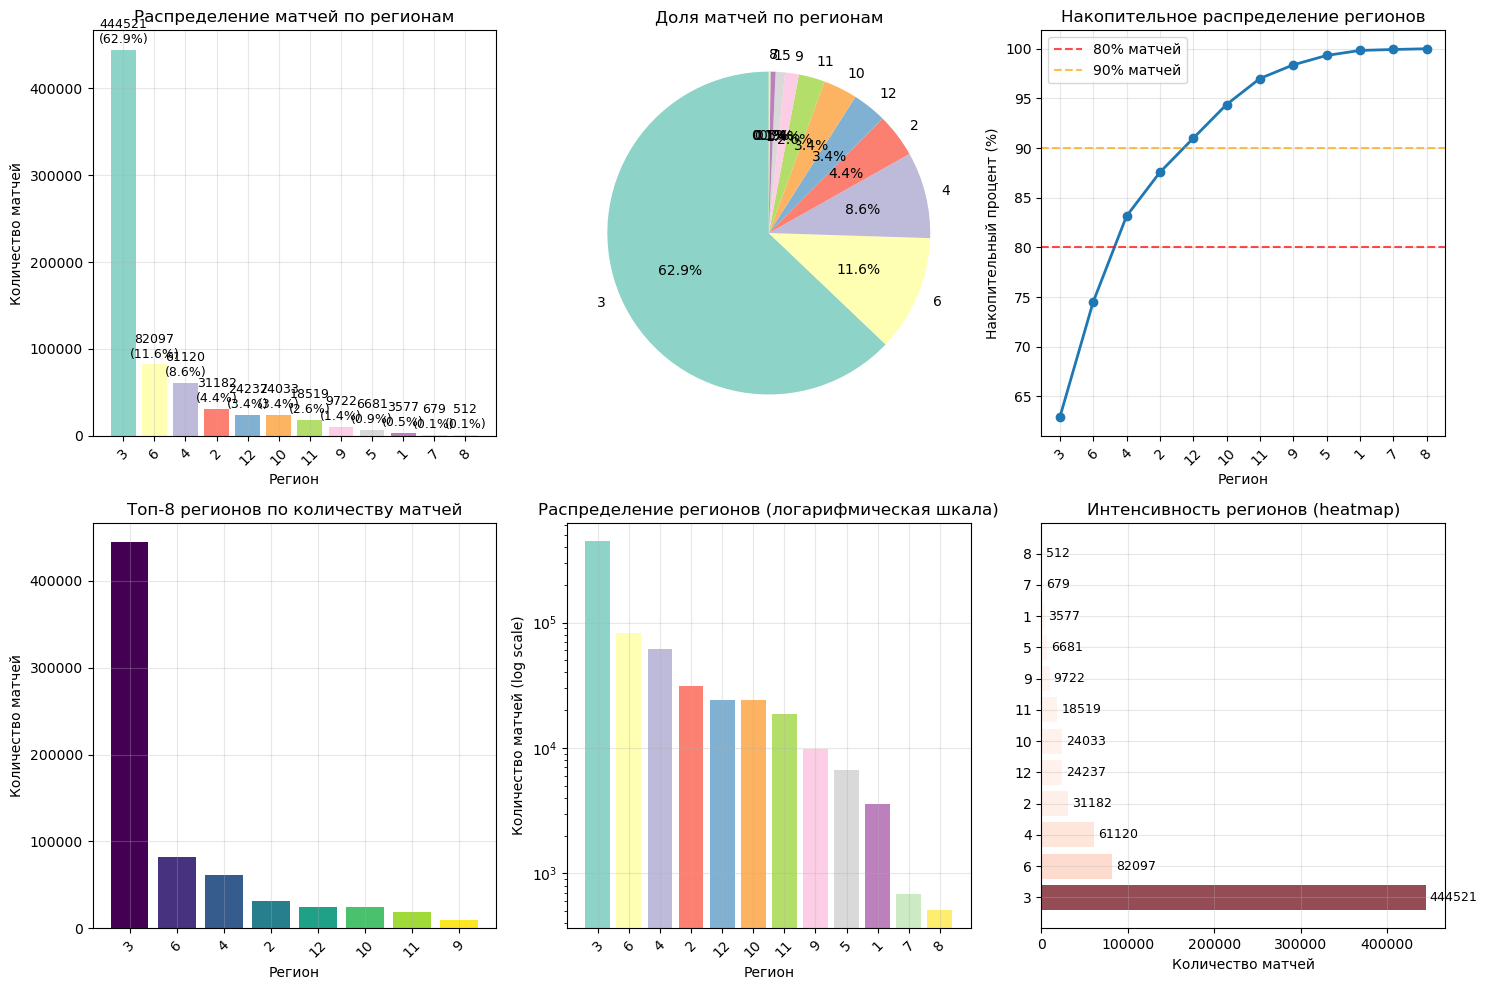

Статистика по регионам:
  3: 444521 матчей (62.9%)
  6: 82097 матчей (11.6%)
  4: 61120 матчей (8.6%)
  2: 31182 матчей (4.4%)
  12: 24237 матчей (3.4%)
  10: 24033 матчей (3.4%)
  11: 18519 матчей (2.6%)
  9: 9722 матчей (1.4%)
  5: 6681 матчей (0.9%)
  1: 3577 матчей (0.5%)
  7: 679 матчей (0.1%)
  8: 512 матчей (0.1%)
Доминирующие регионы (80% матчей):
  3, 6, 4
Анализ связи региона с победой radiant
Статистика побед radiant по регионам:
        Количество_матчей  Процент_побед_radiant  Стандартное_отклонение
region                                                                  
9                    9722                 0.5250                  0.4994
7                     679                 0.5214                  0.4999
6                   82097                 0.5139                  0.4998
12                  24237                 0.5124                  0.4999
4                   61120                 0.5124                  0.4999
3                  444521                 0.

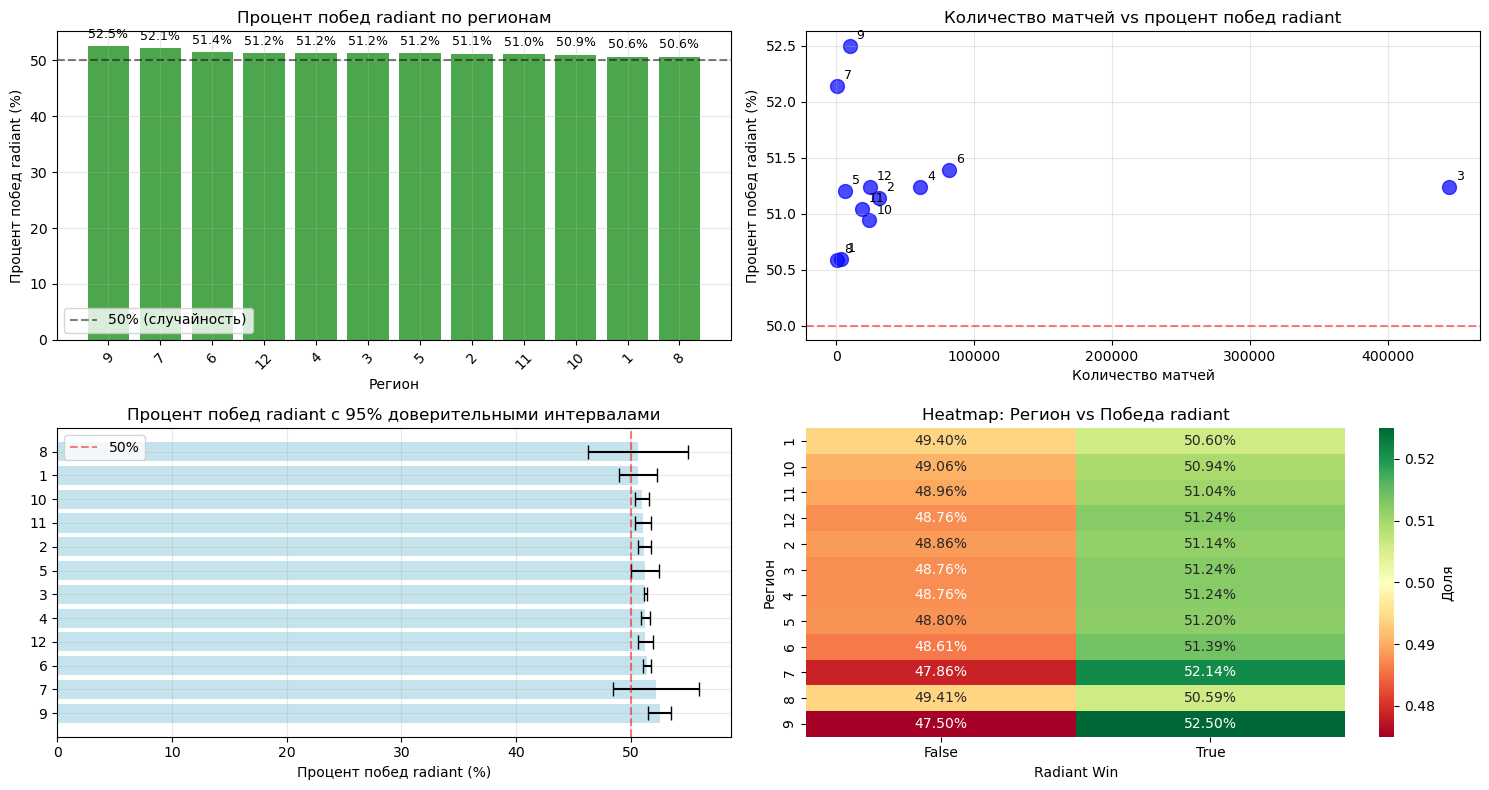

Сравнение методов кодирования регионов
Ошибка в Target Encoding: 'super' object has no attribute '__sklearn_tags__'
Ошибка в Leave-One-Out Encoding: 'super' object has no attribute '__sklearn_tags__'
Результаты сравнения методов кодирования:
                    Метод  Корреляция с таргетом  Уникальных значений
2         Target Encoding                 0.0617                   12
3  Leave-One-Out Encoding                 0.0605                   12
0          Label Encoding                 0.0028                   12
4        One-Hot Encoding                 0.0007                   11
1      Frequency Encoding                 0.0002                   12


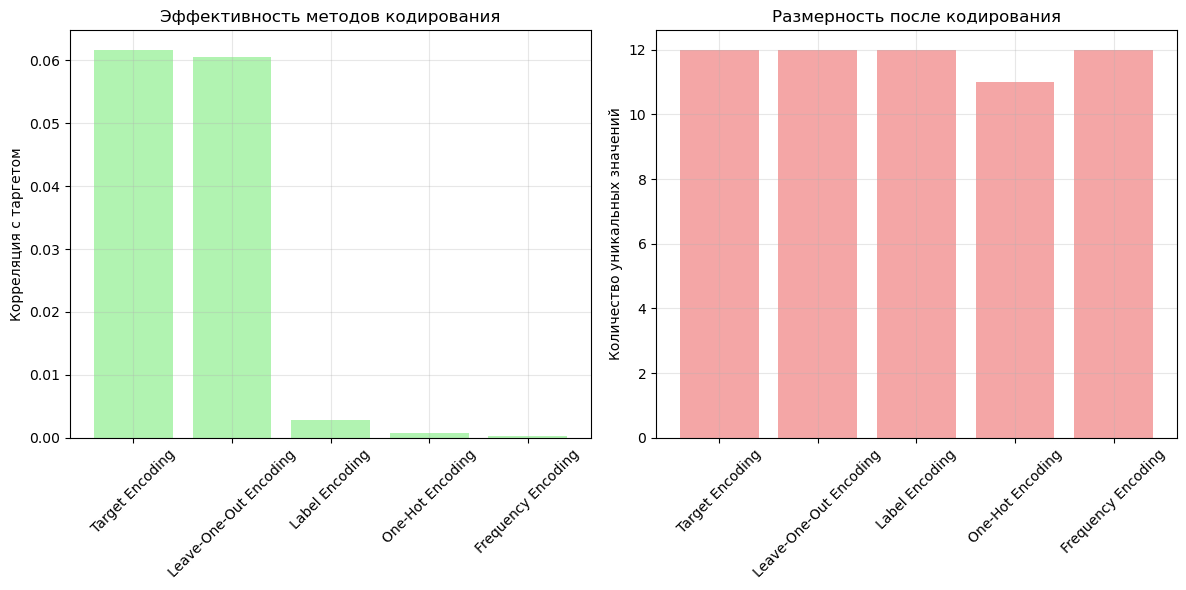

Применение кодирования регионов к данным
Применено методов кодирования: 13
Список добавленных признаков:
  - region_target
  - region_freq
  - region_3
  - region_6
  - region_4
  - region_2
  - region_12
  - region_10
  - region_11
  - region_9
  - region_5
  - region_1
  - region_label
Проверка добавления:
  Тренировочные данные: 15 признаков region
  Тестовые данные: 15 признаков region
Итоговый отчет по регионам
Результаты анализа:
  - Всего регионов: 12
  - Самый популярный регион: 3 (444521 матчей)
  - Самый редкий регион: 8 (512 матчей)
  - Статистически значимая связь с таргетом: Нет (p=0.616132)


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import category_encoders as ce
import warnings
warnings.filterwarnings('ignore')

print(matches_train.columns.tolist())

print(matches_test.columns.tolist())

if 'region' in matches_train.columns:
    region_data = matches_train['region'].copy()
    print(f"Статистика регионов в тренировочных данных:")
    print(f"  - Всего записей: {len(region_data)}")
    print(f"  - Пропуски: {region_data.isnull().sum()} ({region_data.isnull().mean()*100:.2f}%)")
    print(f"  - Уникальных регионов: {region_data.nunique()}")
    print(f"  - Тип данных: {region_data.dtype}")
    print(f"  - Список регионов: {region_data.unique().tolist()}")
    
    region_data_str = region_data.astype(str)
    print(f"  - Регионы как строки: {region_data_str.unique().tolist()}")
else:
    print("Колонка 'region' не найдена в matches_train")
    region_data = None

def visualize_region_distribution(region_series):
    if region_series is None:
        return
    
    region_series_str = region_series.astype(str)
    region_counts = region_series_str.value_counts()
    region_percentages = region_series_str.value_counts(normalize=True) * 100
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 3, 1)
    bars = plt.bar(region_counts.index, region_counts.values, 
                   color=plt.cm.Set3(np.linspace(0, 1, len(region_counts))))
    plt.xlabel('Регион')
    plt.ylabel('Количество матчей')
    plt.title('Распределение матчей по регионам')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    for bar, count, percentage in zip(bars, region_counts.values, region_percentages.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + region_counts.max()*0.01, 
                f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=9)
    
    plt.subplot(2, 3, 2)
    plt.pie(region_counts.values, labels=region_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=plt.cm.Set3(np.linspace(0, 1, len(region_counts))))
    plt.title('Доля матчей по регионам')
    
    plt.subplot(2, 3, 3)
    cumulative_percentage = region_percentages.cumsum()
    plt.plot(region_percentages.index, cumulative_percentage.values, 'o-', linewidth=2)
    plt.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% матчей')
    plt.axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% матчей')
    plt.xlabel('Регион')
    plt.ylabel('Накопительный процент (%)')
    plt.title('Накопительное распределение регионов')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 4)
    top_n = min(8, len(region_counts))
    top_regions = region_counts.head(top_n)
    plt.bar(range(len(top_regions)), top_regions.values, 
            color=plt.cm.viridis(np.linspace(0, 1, len(top_regions))))
    plt.xticks(range(len(top_regions)), top_regions.index, rotation=45)
    plt.xlabel('Регион')
    plt.ylabel('Количество матчей')
    plt.title(f'Топ-{top_n} регионов по количеству матчей')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 5)
    plt.bar(region_counts.index, region_counts.values, 
            color=plt.cm.Set3(np.linspace(0, 1, len(region_counts))))
    plt.yscale('log')
    plt.xlabel('Регион')
    plt.ylabel('Количество матчей (log scale)')
    plt.title('Распределение регионов (логарифмическая шкала)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 6)
    max_count = region_counts.max()
    for i, (region, count) in enumerate(region_counts.items()):
        intensity = count / max_count
        plt.barh(i, count, color=plt.cm.Reds(intensity), alpha=0.7)
        plt.text(count + max_count*0.01, i, f'{count}', va='center', fontsize=9)
    
    plt.yticks(range(len(region_counts)), region_counts.index)
    plt.xlabel('Количество матчей')
    plt.title('Интенсивность регионов (heatmap)')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Статистика по регионам:")
    for region, count in region_counts.items():
        percentage = region_percentages[region]
        print(f"  {region}: {count} матчей ({percentage:.1f}%)")
    
    dominant_threshold = 80
    cumulative = 0
    dominant_regions = []
    
    for region, percentage in region_percentages.items():
        cumulative += percentage
        dominant_regions.append(str(region))
        if cumulative >= dominant_threshold:
            break
    
    print(f"Доминирующие регионы ({dominant_threshold}% матчей):")
    print(f"  {', '.join(dominant_regions)}")

if region_data is not None:
    visualize_region_distribution(region_data)

def analyze_region_target_relationship(matches_df):
    if 'region' not in matches_df.columns or 'radiant_win' not in matches_df.columns:
        print("Недостаточно данных для анализа связи")
        return
    
    print(f"Анализ связи региона с победой radiant")
    
    analysis_df = matches_df[['region', 'radiant_win']].dropna().copy()
    analysis_df['region'] = analysis_df['region'].astype(str)
    
    region_stats = analysis_df.groupby('region').agg({
        'radiant_win': ['count', 'mean', 'std']
    }).round(4)
    
    region_stats.columns = ['Количество_матчей', 'Процент_побед_radiant', 'Стандартное_отклонение']
    region_stats = region_stats.sort_values('Процент_побед_radiant', ascending=False)
    
    print("Статистика побед radiant по регионам:")
    print(region_stats)
    
    from scipy.stats import chi2_contingency
    
    contingency_table = pd.crosstab(analysis_df['region'], analysis_df['radiant_win'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Статистический тест (Chi-square):")
    print(f"  Chi-square: {chi2:.4f}")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Degrees of freedom: {dof}")
    
    if p_value < 0.05:
        print("  Есть статистически значимая связь между регионом и победой radiant")
    else:
        print("  Нет статистически значимой связи между регионом и победой radiant")
    
    plt.figure(figsize=(15, 8))
    
    plt.subplot(2, 2, 1)
    win_rates = region_stats['Процент_побед_radiant'] * 100
    colors = ['green' if rate > 50 else 'red' for rate in win_rates.values]
    
    bars = plt.bar(win_rates.index, win_rates.values, color=colors, alpha=0.7)
    plt.axhline(y=50, color='black', linestyle='--', alpha=0.5, label='50% (случайность)')
    plt.xlabel('Регион')
    plt.ylabel('Процент побед radiant (%)')
    plt.title('Процент побед radiant по регионам')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    for bar, rate in zip(bars, win_rates.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.subplot(2, 2, 2)
    plt.scatter(region_stats['Количество_матчей'], win_rates.values, 
                s=100, alpha=0.7, color='blue')
    
    for i, region in enumerate(win_rates.index):
        plt.annotate(region, 
                    (region_stats['Количество_матчей'].iloc[i], win_rates.iloc[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    plt.axhline(y=50, color='red', linestyle='--', alpha=0.5)
    plt.xlabel('Количество матчей')
    plt.ylabel('Процент побед radiant (%)')
    plt.title('Количество матчей vs процент побед radiant')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    from math import sqrt
    
    confidence_intervals = []
    for region in win_rates.index:
        n = region_stats.loc[region, 'Количество_матчей']
        p = region_stats.loc[region, 'Процент_побед_radiant']
        std_err = sqrt(p * (1 - p) / n)
        ci = 1.96 * std_err
        
        confidence_intervals.append({
            'region': region,
            'win_rate': p * 100,
            'ci_lower': (p - ci) * 100,
            'ci_upper': (p + ci) * 100
        })
    
    ci_df = pd.DataFrame(confidence_intervals)
    ci_df = ci_df.sort_values('win_rate', ascending=False)
    
    y_pos = range(len(ci_df))
    plt.barh(y_pos, ci_df['win_rate'], xerr=[ci_df['win_rate'] - ci_df['ci_lower'], 
                                           ci_df['ci_upper'] - ci_df['win_rate']],
            alpha=0.7, color='lightblue', ecolor='black', capsize=5)
    plt.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50%')
    plt.yticks(y_pos, ci_df['region'])
    plt.xlabel('Процент побед radiant (%)')
    plt.title('Процент побед radiant с 95% доверительными интервалами')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    normalized_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)
    sns.heatmap(normalized_table, annot=True, fmt='.2%', cmap='RdYlGn', 
                cbar_kws={'label': 'Доля'})
    plt.title('Heatmap: Регион vs Победа radiant')
    plt.xlabel('Radiant Win')
    plt.ylabel('Регион')
    
    plt.tight_layout()
    plt.show()
    
    return region_stats, p_value

if 'region' in matches_train.columns and 'radiant_win' in matches_train.columns:
    region_stats, region_p_value = analyze_region_target_relationship(matches_train)

def compare_encoding_methods(region_series, target_series):
    print(f"Сравнение методов кодирования регионов")
    
    valid_mask = ~region_series.isnull() & ~target_series.isnull()
    regions_clean = region_series[valid_mask].astype(str)
    target_clean = target_series[valid_mask]
    
    encoding_results = []
    
    onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
    onehot_encoded = onehot_encoder.fit_transform(regions_clean.values.reshape(-1, 1))
    
    label_encoder = LabelEncoder()
    label_encoded = label_encoder.fit_transform(regions_clean)
    
    frequency_map = regions_clean.value_counts().to_dict()
    frequency_encoded = regions_clean.map(frequency_map)
    
    try:
        target_encoder = ce.TargetEncoder()
        target_encoded = target_encoder.fit_transform(regions_clean.values.reshape(-1, 1), 
                                                    target_clean)
    except Exception as e:
        print(f"Ошибка в Target Encoding: {e}")
        target_encoded = frequency_encoded
    
    try:
        loo_encoder = ce.LeaveOneOutEncoder()
        loo_encoded = loo_encoder.fit_transform(regions_clean.values.reshape(-1, 1), 
                                              target_clean)
    except Exception as e:
        print(f"Ошибка в Leave-One-Out Encoding: {e}")
        loo_encoded = frequency_encoded
    
    encodings = {
        'Label Encoding': label_encoded,
        'Frequency Encoding': frequency_encoded,
        'Target Encoding': target_encoded.values.flatten(),
        'Leave-One-Out Encoding': loo_encoded.values.flatten()
    }
    
    for name, encoded in encodings.items():
        if len(encoded) == len(target_clean):
            if name in ['Label Encoding', 'Frequency Encoding']:
                correlation = np.corrcoef(encoded, target_clean)[0, 1]
            else:
                from sklearn.feature_selection import mutual_info_classif
                mi = mutual_info_classif(encoded.reshape(-1, 1), target_clean)[0]
                correlation = mi
            
            encoding_results.append({
                'Метод': name,
                'Корреляция с таргетом': abs(correlation),
                'Уникальных значений': len(np.unique(encoded))
            })
    
    if onehot_encoded.shape[1] > 0:
        avg_correlation = 0
        for i in range(onehot_encoded.shape[1]):
            corr = np.corrcoef(onehot_encoded[:, i], target_clean)[0, 1]
            avg_correlation += abs(corr)
        avg_correlation /= onehot_encoded.shape[1]
        
        encoding_results.append({
            'Метод': 'One-Hot Encoding',
            'Корреляция с таргетом': avg_correlation,
            'Уникальных значений': onehot_encoded.shape[1]
        })
    
    encoding_df = pd.DataFrame(encoding_results)
    encoding_df = encoding_df.sort_values('Корреляция с таргетом', ascending=False)
    
    print("Результаты сравнения методов кодирования:")
    print(encoding_df.round(4))
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(encoding_df['Метод'], encoding_df['Корреляция с таргетом'], 
            color='lightgreen', alpha=0.7)
    plt.ylabel('Корреляция с таргетом')
    plt.title('Эффективность методов кодирования')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.bar(encoding_df['Метод'], encoding_df['Уникальных значений'], 
            color='lightcoral', alpha=0.7)
    plt.ylabel('Количество уникальных значений')
    plt.title('Размерность после кодирования')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return encoding_df

if region_data is not None and 'radiant_win' in matches_train.columns:
    encoding_comparison = compare_encoding_methods(region_data, matches_train['radiant_win'])

def apply_best_encodings():
    print(f"Применение кодирования регионов к данным")
    
    if 'region' not in matches_train.columns:
        print("Колонка 'region' не найдена")
        return []
    
    matches_train['region_str'] = matches_train['region'].astype(str)
    if 'region' in matches_test.columns:
        matches_test['region_str'] = matches_test['region'].astype(str)
    
    best_methods = ['Target Encoding', 'Frequency Encoding', 'One-Hot Encoding']
    
    applied_encodings = []
    
    for method in best_methods:
        try:
            if method == 'One-Hot Encoding':
                top_regions = matches_train['region_str'].value_counts().head(10).index
                for region in top_regions:
                    feature_name = f'region_{region}'
                    matches_train[feature_name] = (matches_train['region_str'] == region).astype(int)
                    
                    if 'region_str' in matches_test.columns:
                        matches_test[feature_name] = (matches_test['region_str'] == region).astype(int)
                    
                    applied_encodings.append(feature_name)
            
            elif method == 'Frequency Encoding':
                region_freq = matches_train['region_str'].value_counts().to_dict()
                matches_train['region_freq'] = matches_train['region_str'].map(region_freq)
                
                if 'region_str' in matches_test.columns:
                    default_freq = np.median(list(region_freq.values()))
                    matches_test['region_freq'] = matches_test['region_str'].map(region_freq).fillna(default_freq)
                
                applied_encodings.append('region_freq')
            
            elif method == 'Target Encoding':
                if 'radiant_win' in matches_train.columns:
                    region_win_rates = matches_train.groupby('region_str')['radiant_win'].mean().to_dict()
                    matches_train['region_target'] = matches_train['region_str'].map(region_win_rates)
                    
                    if 'region_str' in matches_test.columns:
                        global_mean = matches_train['radiant_win'].mean()
                        matches_test['region_target'] = matches_test['region_str'].map(region_win_rates).fillna(global_mean)
                    
                    applied_encodings.append('region_target')
        
        except Exception as e:
            print(f"Ошибка при применении {method}: {e}")
    
    try:
        label_encoder = LabelEncoder()
        all_regions = pd.concat([matches_train['region_str'], matches_test['region_str']], ignore_index=True)
        label_encoder.fit(all_regions)
        
        matches_train['region_label'] = label_encoder.transform(matches_train['region_str'])
        matches_test['region_label'] = label_encoder.transform(matches_test['region_str'])
        
        applied_encodings.append('region_label')
    except Exception as e:
        print(f"Ошибка при Label Encoding: {e}")
    
    print(f"Применено методов кодирования: {len(applied_encodings)}")
    print("Список добавленных признаков:")
    for feature in applied_encodings:
        print(f"  - {feature}")
    
    print(f"Проверка добавления:")
    region_features_train = [col for col in matches_train.columns if 'region' in col.lower()]
    region_features_test = [col for col in matches_test.columns if 'region' in col.lower()]
    
    print(f"  Тренировочные данные: {len(region_features_train)} признаков region")
    print(f"  Тестовые данные: {len(region_features_test)} признаков region")
    
    return applied_encodings

applied_encodings = apply_best_encodings()

print(f"Итоговый отчет по регионам")

print(f"Результаты анализа:")
if region_data is not None:
    region_counts = region_data.astype(str).value_counts()
    print(f"  - Всего регионов: {region_data.nunique()}")
    print(f"  - Самый популярный регион: {region_counts.index[0]} ({region_counts.iloc[0]} матчей)")
    print(f"  - Самый редкий регион: {region_counts.index[-1]} ({region_counts.iloc[-1]} матчей)")

if 'region_p_value' in locals():
    significance = "Да" if region_p_value < 0.05 else "Нет"
    print(f"  - Статистически значимая связь с таргетом: {significance} (p={region_p_value:.6f})")

Доступные колонки в matches_train:
['match_id', 'date', 'region', 'game_mode', 'duration', 'radiant_win', 'duration_filled', 'duration_missing', 'duration_category', 'duration_log', 'duration_sqrt', 'duration_boxcox', 'duration_reciprocal', 'duration_yeojohnson', 'region_str', 'region_target', 'region_freq', 'region_3', 'region_6', 'region_4', 'region_2', 'region_12', 'region_10', 'region_11', 'region_9', 'region_5', 'region_1', 'region_label']

Доступные колонки в matches_test:
['match_id', 'date', 'region', 'game_mode', 'duration_filled', 'duration_missing', 'duration_category', 'duration_log', 'duration_sqrt', 'duration_boxcox', 'duration_reciprocal', 'duration_yeojohnson', 'region_str', 'region_target', 'region_freq', 'region_3', 'region_6', 'region_4', 'region_2', 'region_12', 'region_10', 'region_11', 'region_9', 'region_5', 'region_1', 'region_label']
Статистика дат в тренировочных данных:
  - Всего записей: 706880
  - Пропуски: 0 (0.00%)
  - Тип данных: object
  - Примеры дат: 

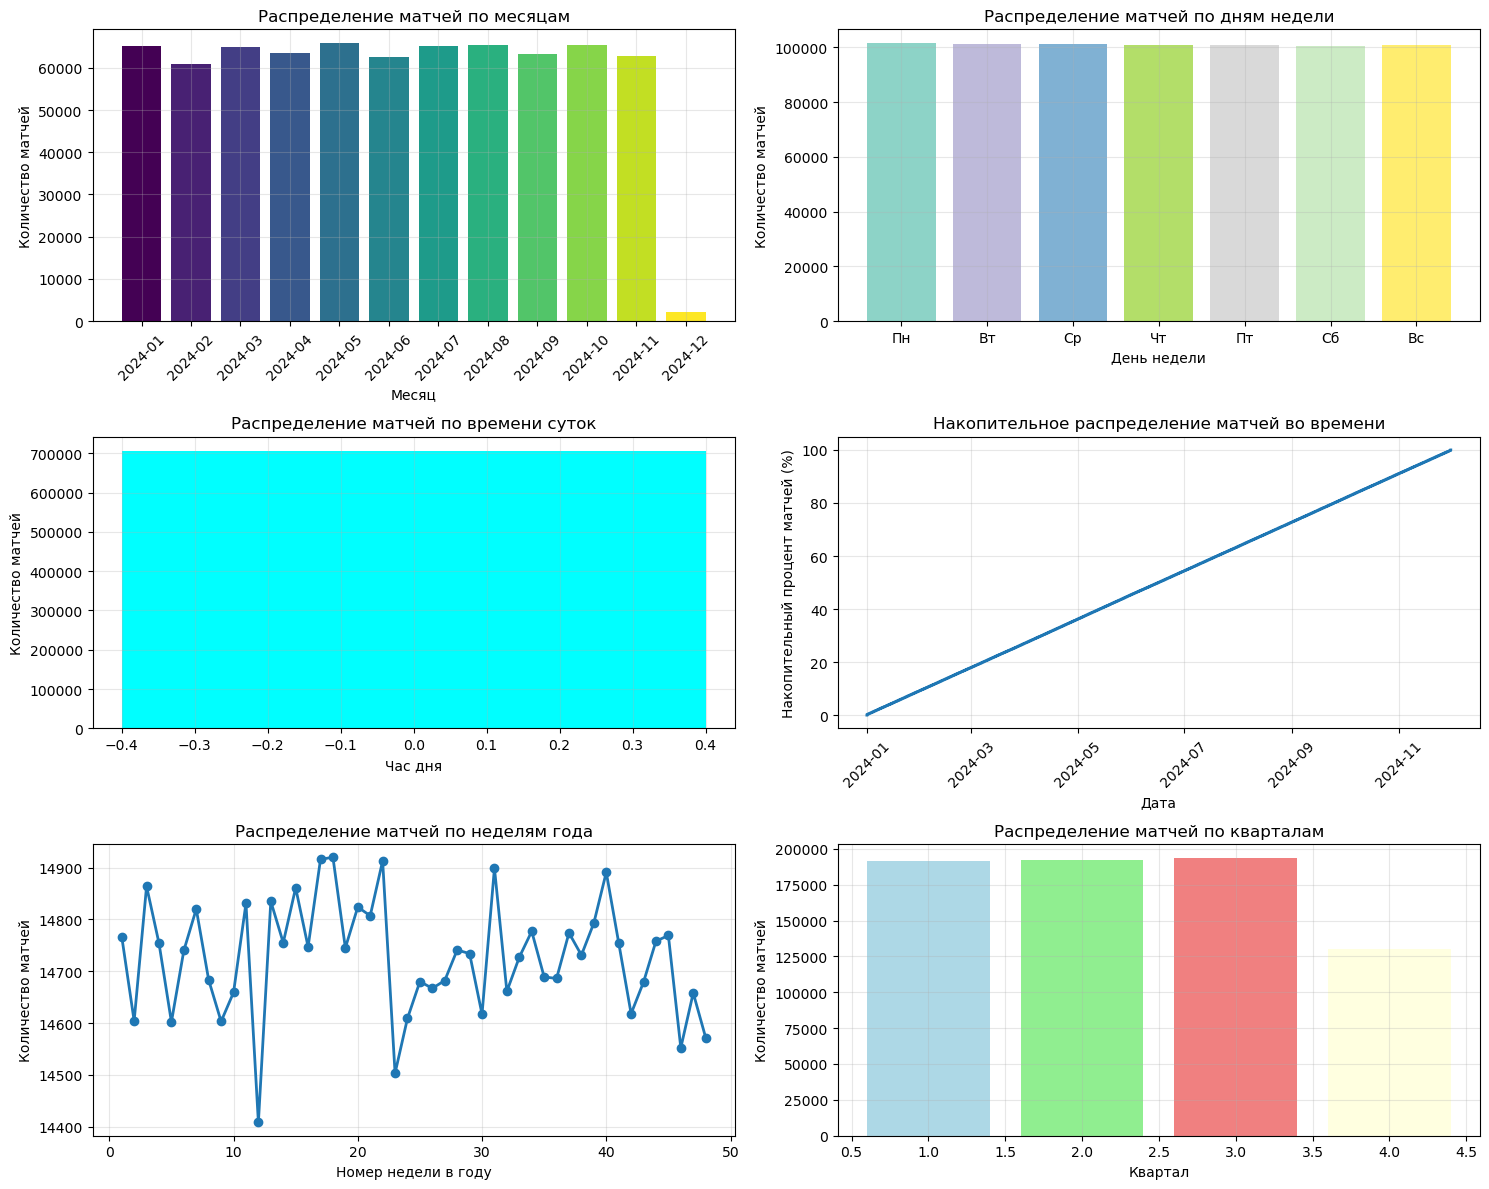

Статистика по времени:
  - Всего дней с матчами: 336
  - Среднее матчей в день: 2103.8
  - Самый загруженный день: 2024-09-17 (2243 матчей)
  - Самый популярный час: 0:00 (706880 матчей)
  - Самый популярный день недели: Пн
Анализ связи времени с победой radiant
Статистика побед radiant по часам:
      Количество_матчей  Процент_побед_radiant
hour                                          
0                706880                 0.5125
Статистика побед radiant по дням недели:
             Количество_матчей  Процент_побед_radiant
Понедельник             101500                 0.5108
Вторник                 101272                 0.4852
Среда                   101109                 0.5115
Четверг                 100747                 0.5135
Пятница                 100786                 0.5230
Суббота                 100661                 0.5216
Воскресенье             100805                 0.5223


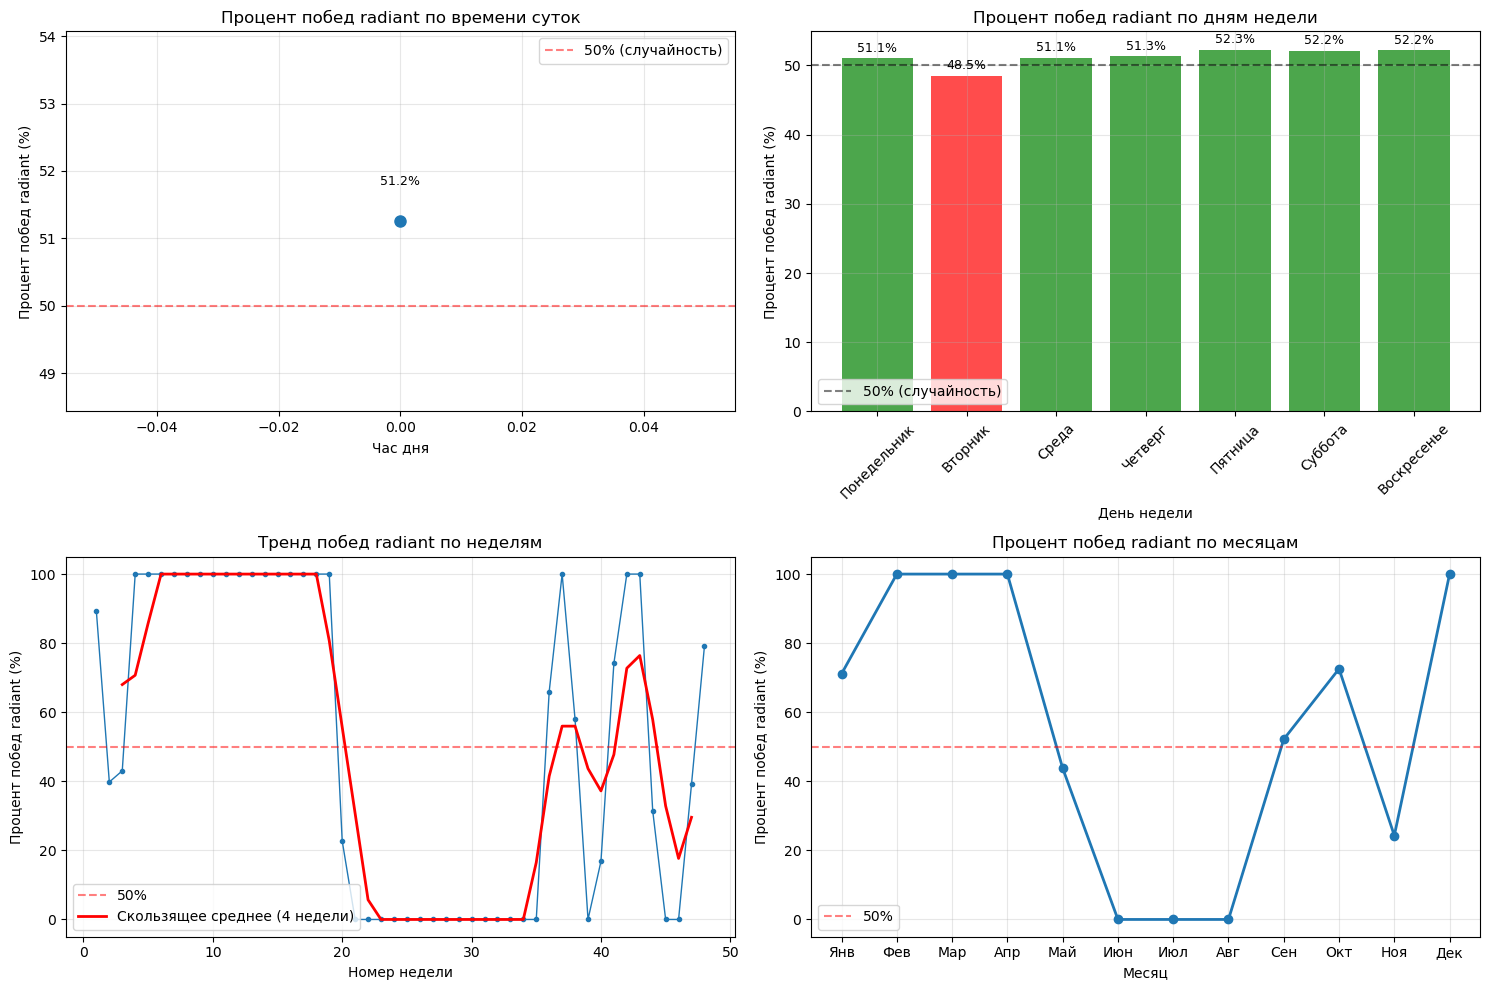

Определение знаменательных дат
Распределение по знаменательным датам:
  Новый год: 14767 матчей (2.1%)
  Летние каникулы: 193087 матчей (27.3%)
  Зимние каникулы: 21054 матчей (3.0%)
  Выходные: 201466 матчей (28.5%)
  Ночное время: 706880 матчей (100.0%)
  Утренние часы: 0 матчей (0.0%)
  Вечерние часы: 0 матчей (0.0%)
  Обновление 7.00: 0 матчей (0.0%)
  Обновление 7.07: 0 матчей (0.0%)
  Обновление 7.20: 0 матчей (0.0%)
  Обновление 7.23: 0 матчей (0.0%)
  Обновление 7.29: 0 матчей (0.0%)


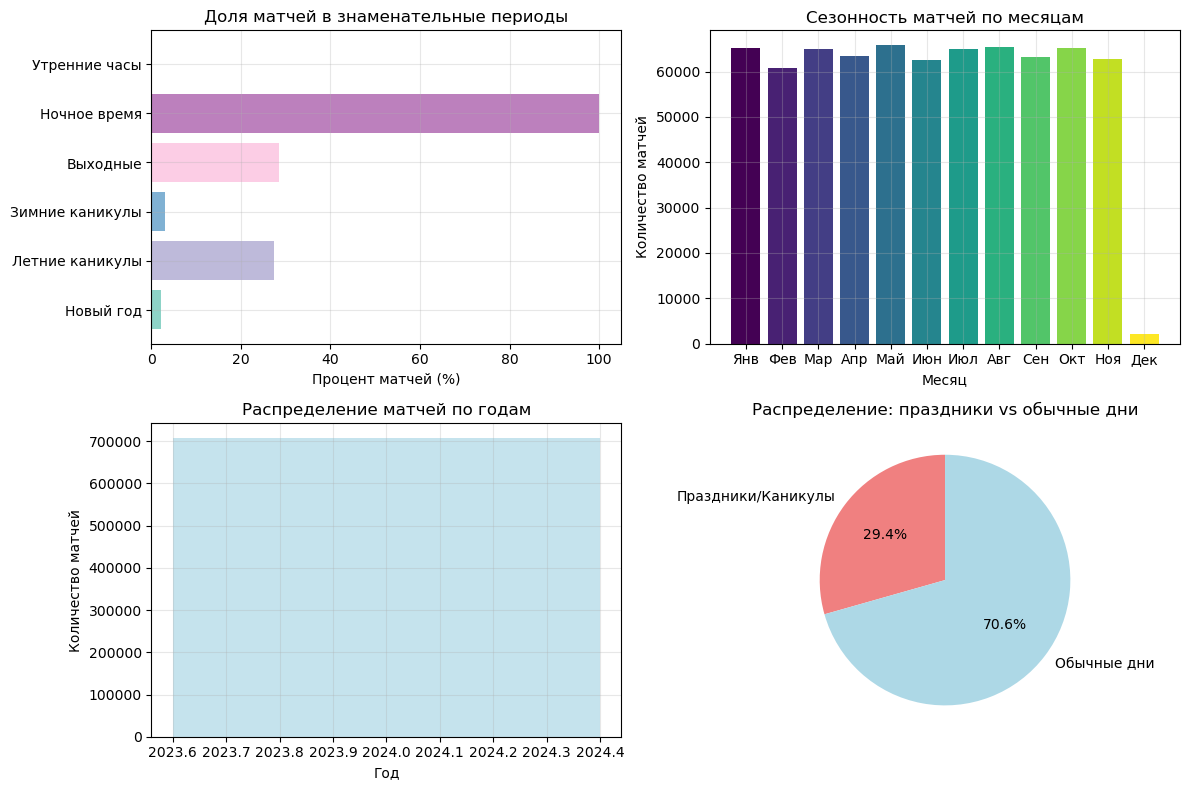

Создание временных признаков
Добавлен числовой признак: hour (Час дня)
Добавлен числовой признак: dayofweek (День недели (0-6))
Добавлен числовой признак: dayofyear (День года)
Добавлен числовой признак: week (Номер недели)
Добавлен числовой признак: month (Месяц)
Добавлен числовой признак: quarter (Квартал)
Добавлен бинарный признак: is_weekend (Выходной день)
Добавлен бинарный признак: is_night (Ночное время)
Добавлен бинарный признак: is_evening (Вечернее время)
Добавлен бинарный признак: is_morning (Утреннее время)
Добавлен флаг: holiday_season
Добавлен флаг: summer_season
Добавлен флаг: weekend
Добавлены сезонные признаки
Добавлен трендовый признак: days_since_start
Проверка добавления:
  Тренировочные данные: 18 временных признаков
  Тестовые данные: 18 временных признаков
Примеры созданных признаков:
  time_hour: 1 уникальных значений
  time_dayofweek: 7 уникальных значений
  time_dayofyear: 336 уникальных значений
  time_week: 48 уникальных значений
  time_month: 12 уникальных 

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

print("Доступные колонки в matches_train:")
print(matches_train.columns.tolist())

print("\nДоступные колонки в matches_test:")
print(matches_test.columns.tolist())

if 'date' in matches_train.columns:
    date_data = matches_train['date'].copy()
    print(f"Статистика дат в тренировочных данных:")
    print(f"  - Всего записей: {len(date_data)}")
    print(f"  - Пропуски: {date_data.isnull().sum()} ({date_data.isnull().mean()*100:.2f}%)")
    print(f"  - Тип данных: {date_data.dtype}")
    print(f"  - Примеры дат: {date_data.head(5).tolist()}")
    
    try:
        if date_data.dtype == 'object':
            date_data = pd.to_datetime(date_data, errors='coerce')
        else:
            date_data = pd.to_datetime(date_data, unit='s', errors='coerce')
        
        print(f"  - Первая дата: {date_data.min()}")
        print(f"  - Последняя дата: {date_data.max()}")
        print(f"  - Период: {(date_data.max() - date_data.min()).days} дней")
        
    except Exception as e:
        print(f"Ошибка при преобразовании дат: {e}")
        date_data = None
else:
    print("Колонка 'date' не найдена в matches_train")
    date_data = None

def visualize_date_distribution(date_series):
    if date_series is None or date_series.isnull().all():
        return
    
    clean_dates = date_series.dropna()
    
    plt.figure(figsize=(15, 12))
    
    plt.subplot(3, 2, 1)
    monthly_counts = clean_dates.dt.to_period('M').value_counts().sort_index()
    monthly_counts.index = monthly_counts.index.astype(str)
    
    plt.bar(monthly_counts.index, monthly_counts.values, 
            color=plt.cm.viridis(np.linspace(0, 1, len(monthly_counts))))
    plt.xlabel('Месяц')
    plt.ylabel('Количество матчей')
    plt.title('Распределение матчей по месяцам')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 2, 2)
    day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
    day_counts = clean_dates.dt.dayofweek.value_counts().sort_index()
    day_counts.index = [day_names[i] for i in day_counts.index]
    
    plt.bar(day_counts.index, day_counts.values, 
            color=plt.cm.Set3(np.linspace(0, 1, len(day_counts))))
    plt.xlabel('День недели')
    plt.ylabel('Количество матчей')
    plt.title('Распределение матчей по дням недели')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 2, 3)
    hour_counts = clean_dates.dt.hour.value_counts().sort_index()
    
    plt.bar(hour_counts.index, hour_counts.values, 
            color=plt.cm.cool(np.linspace(0, 1, len(hour_counts))))
    plt.xlabel('Час дня')
    plt.ylabel('Количество матчей')
    plt.title('Распределение матчей по времени суток')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 2, 4)
    sorted_dates = clean_dates.sort_values()
    cumulative = np.arange(1, len(sorted_dates) + 1) / len(sorted_dates) * 100
    
    plt.plot(sorted_dates, cumulative, linewidth=2)
    plt.xlabel('Дата')
    plt.ylabel('Накопительный процент матчей (%)')
    plt.title('Накопительное распределение матчей во времени')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.subplot(3, 2, 5)
    weekly_counts = clean_dates.dt.isocalendar().week.value_counts().sort_index()
    
    plt.plot(weekly_counts.index, weekly_counts.values, 'o-', linewidth=2)
    plt.xlabel('Номер недели в году')
    plt.ylabel('Количество матчей')
    plt.title('Распределение матчей по неделям года')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 2, 6)
    quarter_counts = clean_dates.dt.quarter.value_counts().sort_index()
    
    plt.bar(quarter_counts.index, quarter_counts.values, 
            color=['lightblue', 'lightgreen', 'lightcoral', 'lightyellow'])
    plt.xlabel('Квартал')
    plt.ylabel('Количество матчей')
    plt.title('Распределение матчей по кварталам')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Статистика по времени:")
    print(f"  - Всего дней с матчами: {clean_dates.dt.date.nunique()}")
    print(f"  - Среднее матчей в день: {len(clean_dates) / clean_dates.dt.date.nunique():.1f}")
    print(f"  - Самый загруженный день: {clean_dates.dt.date.value_counts().index[0]} ({clean_dates.dt.date.value_counts().iloc[0]} матчей)")
    print(f"  - Самый популярный час: {clean_dates.dt.hour.value_counts().index[0]}:00 ({clean_dates.dt.hour.value_counts().iloc[0]} матчей)")
    print(f"  - Самый популярный день недели: {day_names[clean_dates.dt.dayofweek.value_counts().index[0]]}")

if date_data is not None:
    visualize_date_distribution(date_data)

def analyze_date_target_relationship(matches_df):
    if 'date' not in matches_df.columns or 'radiant_win' not in matches_df.columns:
        print("Недостаточно данных для анализа связи")
        return
    
    print(f"Анализ связи времени с победой radiant")
    
    analysis_df = matches_df[['date', 'radiant_win']].dropna().copy()
    
    try:
        if analysis_df['date'].dtype == 'object':
            analysis_df['date'] = pd.to_datetime(analysis_df['date'], errors='coerce')
        else:
            analysis_df['date'] = pd.to_datetime(analysis_df['date'], unit='s', errors='coerce')
        
        analysis_df = analysis_df.dropna()
    except Exception as e:
        print(f"Ошибка при преобразовании дат: {e}")
        return
    
    analysis_df['hour'] = analysis_df['date'].dt.hour
    analysis_df['dayofweek'] = analysis_df['date'].dt.dayofweek
    analysis_df['month'] = analysis_df['date'].dt.month
    analysis_df['is_weekend'] = analysis_df['date'].dt.dayofweek.isin([5, 6]).astype(int)
    
    hour_stats = analysis_df.groupby('hour').agg({
        'radiant_win': ['count', 'mean']
    }).round(4)
    hour_stats.columns = ['Количество_матчей', 'Процент_побед_radiant']
    
    print("Статистика побед radiant по часам:")
    print(hour_stats.head(8))
    
    day_names = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
    day_stats = analysis_df.groupby('dayofweek').agg({
        'radiant_win': ['count', 'mean']
    }).round(4)
    day_stats.columns = ['Количество_матчей', 'Процент_побед_radiant']
    day_stats.index = [day_names[i] for i in day_stats.index]
    
    print("Статистика побед radiant по дням недели:")
    print(day_stats)
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(2, 2, 1)
    win_rates_hour = hour_stats['Процент_побед_radiant'] * 100
    
    plt.plot(win_rates_hour.index, win_rates_hour.values, 'o-', linewidth=2, markersize=8)
    plt.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% (случайность)')
    plt.xlabel('Час дня')
    plt.ylabel('Процент побед radiant (%)')
    plt.title('Процент побед radiant по времени суток')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    for hour, rate in zip(win_rates_hour.index, win_rates_hour.values):
        plt.text(hour, rate + 0.5, f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.subplot(2, 2, 2)
    win_rates_day = day_stats['Процент_побед_radiant'] * 100
    
    colors = ['green' if rate > 50 else 'red' for rate in win_rates_day.values]
    bars = plt.bar(win_rates_day.index, win_rates_day.values, color=colors, alpha=0.7)
    plt.axhline(y=50, color='black', linestyle='--', alpha=0.5, label='50% (случайность)')
    plt.xlabel('День недели')
    plt.ylabel('Процент побед radiant (%)')
    plt.title('Процент побед radiant по дням недели')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    for bar, rate in zip(bars, win_rates_day.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.subplot(2, 2, 3)
    analysis_df['week'] = analysis_df['date'].dt.isocalendar().week
    weekly_win_rates = analysis_df.groupby('week')['radiant_win'].mean() * 100
    
    plt.plot(weekly_win_rates.index, weekly_win_rates.values, 'o-', linewidth=1, markersize=3)
    plt.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50%')
    
    window = 4
    rolling_mean = weekly_win_rates.rolling(window=window, center=True).mean()
    plt.plot(rolling_mean.index, rolling_mean.values, 'r-', linewidth=2, 
             label=f'Скользящее среднее ({window} недели)')
    
    plt.xlabel('Номер недели')
    plt.ylabel('Процент побед radiant (%)')
    plt.title('Тренд побед radiant по неделям')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    month_names = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
                  'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
    monthly_win_rates = analysis_df.groupby('month')['radiant_win'].mean() * 100
    
    plt.plot(monthly_win_rates.index, monthly_win_rates.values, 'o-', linewidth=2, markersize=6)
    plt.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50%')
    plt.xlabel('Месяц')
    plt.ylabel('Процент побед radiant (%)')
    plt.title('Процент побед radiant по месяцам')
    plt.xticks(range(1, 13), month_names)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return hour_stats, day_stats

if 'date' in matches_train.columns and 'radiant_win' in matches_train.columns:
    hour_stats, day_stats = analyze_date_target_relationship(matches_train)

def define_significant_dates(date_series):
    print(f"Определение знаменательных дат")
    
    if date_series is None:
        return {}
    
    try:
        if date_series.dtype == 'object':
            dates = pd.to_datetime(date_series, errors='coerce')
        else:
            dates = pd.to_datetime(date_series, unit='s', errors='coerce')
        
        dates = dates.dropna()
    except Exception as e:
        print(f"Ошибка при преобразовании дат: {e}")
        return {}
    
    significant_dates = {
        'Новый год': lambda x: ((x.dt.month == 12) & (x.dt.day >= 25)) | ((x.dt.month == 1) & (x.dt.day <= 7)),
        'Летние каникулы': lambda x: (x.dt.month >= 6) & (x.dt.month <= 8),
        'Зимние каникулы': lambda x: ((x.dt.month == 12) & (x.dt.day >= 20)) | ((x.dt.month == 1) & (x.dt.day <= 10)),
        'Выходные': lambda x: x.dt.dayofweek >= 5,
        'Ночное время': lambda x: (x.dt.hour >= 23) | (x.dt.hour <= 5),
        'Утренние часы': lambda x: (x.dt.hour >= 6) & (x.dt.hour <= 10),
        'Вечерние часы': lambda x: (x.dt.hour >= 18) & (x.dt.hour <= 22),
    }
    
    major_updates = {
        '7.00': '2016-12-12',
        '7.07': '2017-10-31',
        '7.20': '2018-11-19',
        '7.23': '2019-11-26',
        '7.29': '2021-04-09',
    }
    
    for update_name, update_date in major_updates.items():
        update_dt = pd.to_datetime(update_date)
        start_date = update_dt - timedelta(days=14)
        end_date = update_dt + timedelta(days=14)
        
        def create_update_condition(start, end):
            return lambda x: (x >= start) & (x <= end)
        
        significant_dates[f'Обновление {update_name}'] = create_update_condition(start_date, end_date)
    
    date_stats = {}
    
    for name, condition_func in significant_dates.items():
        mask = condition_func(dates)
        count = mask.sum()
        percentage = count / len(dates) * 100
        
        date_stats[name] = {
            'count': count,
            'percentage': percentage,
            'condition': condition_func
        }
    
    print("Распределение по знаменательным датам:")
    for name, stats in date_stats.items():
        print(f"  {name}: {stats['count']} матчей ({stats['percentage']:.1f}%)")
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    names = list(date_stats.keys())[:6]
    percentages = [date_stats[name]['percentage'] for name in names]
    
    plt.barh(names, percentages, color=plt.cm.Set3(np.linspace(0, 1, len(names))))
    plt.xlabel('Процент матчей (%)')
    plt.title('Доля матчей в знаменательные периоды')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    month_counts = dates.dt.month.value_counts().sort_index()
    month_names = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
                  'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']
    
    plt.bar(month_names, month_counts.values, color=plt.cm.viridis(np.linspace(0, 1, 12)))
    plt.xlabel('Месяц')
    plt.ylabel('Количество матчей')
    plt.title('Сезонность матчей по месяцам')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    year_counts = dates.dt.year.value_counts().sort_index()
    
    plt.bar(year_counts.index, year_counts.values, color='lightblue', alpha=0.7)
    plt.xlabel('Год')
    plt.ylabel('Количество матчей')
    plt.title('Распределение матчей по годам')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    holiday_mask = significant_dates['Новый год'](dates) | significant_dates['Летние каникулы'](dates)
    holiday_count = holiday_mask.sum()
    normal_count = len(dates) - holiday_count
    
    plt.pie([holiday_count, normal_count], 
            labels=['Праздники/Каникулы', 'Обычные дни'], 
            autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightblue'])
    plt.title('Распределение: праздники vs обычные дни')
    
    plt.tight_layout()
    plt.show()
    
    return significant_dates, date_stats

if date_data is not None:
    significant_dates, date_stats = define_significant_dates(date_data)

def create_time_features():
    print(f"Создание временных признаков")
    
    if 'date' not in matches_train.columns:
        print("Колонка 'date' не найдена")
        return []
    
    created_features = []
    
    try:
        if matches_train['date'].dtype == 'object':
            train_dates = pd.to_datetime(matches_train['date'], errors='coerce')
        else:
            train_dates = pd.to_datetime(matches_train['date'], unit='s', errors='coerce')
    except Exception as e:
        print(f"Ошибка при преобразовании тренировочных дат: {e}")
        return []
    
    try:
        if 'date' in matches_test.columns:
            if matches_test['date'].dtype == 'object':
                test_dates = pd.to_datetime(matches_test['date'], errors='coerce')
            else:
                test_dates = pd.to_datetime(matches_test['date'], unit='s', errors='coerce')
        else:
            test_dates = None
    except Exception as e:
        print(f"Ошибка при преобразовании тестовых дат: {e}")
        test_dates = None
    
    numerical_features = [
        ('hour', lambda x: x.dt.hour, 'Час дня'),
        ('dayofweek', lambda x: x.dt.dayofweek, 'День недели (0-6)'),
        ('dayofyear', lambda x: x.dt.dayofyear, 'День года'),
        ('week', lambda x: x.dt.isocalendar().week, 'Номер недели'),
        ('month', lambda x: x.dt.month, 'Месяц'),
        ('quarter', lambda x: x.dt.quarter, 'Квартал'),
    ]
    
    for feature, extract_func, description in numerical_features:
        matches_train[f'time_{feature}'] = extract_func(train_dates)
        if test_dates is not None:
            matches_test[f'time_{feature}'] = extract_func(test_dates)
        created_features.append(f'time_{feature}')
        print(f"Добавлен числовой признак: {feature} ({description})")
    
    categorical_features = [
        ('is_weekend', lambda x: x.dt.dayofweek >= 5, 'Выходной день'),
        ('is_night', lambda x: (x.dt.hour >= 23) | (x.dt.hour <= 5), 'Ночное время'),
        ('is_evening', lambda x: (x.dt.hour >= 18) & (x.dt.hour <= 22), 'Вечернее время'),
        ('is_morning', lambda x: (x.dt.hour >= 6) & (x.dt.hour <= 10), 'Утреннее время'),
    ]
    
    for feature, condition, description in categorical_features:
        matches_train[f'time_{feature}'] = condition(train_dates).astype(int)
        if test_dates is not None:
            matches_test[f'time_{feature}'] = condition(test_dates).astype(int)
        created_features.append(f'time_{feature}')
        print(f"Добавлен бинарный признак: {feature} ({description})")
    
    basic_dates = {
        'holiday_season': lambda x: ((x.dt.month == 12) & (x.dt.day >= 25)) | ((x.dt.month == 1) & (x.dt.day <= 7)),
        'summer_season': lambda x: (x.dt.month >= 6) & (x.dt.month <= 8),
        'weekend': lambda x: x.dt.dayofweek >= 5,
    }
    
    for name, condition_func in basic_dates.items():
        feature_name = f'time_{name}'
        matches_train[feature_name] = condition_func(train_dates).astype(int)
        if test_dates is not None:
            matches_test[feature_name] = condition_func(test_dates).astype(int)
        created_features.append(feature_name)
        print(f"Добавлен флаг: {name}")
    
    seasons = {
        'winter': [12, 1, 2],
        'spring': [3, 4, 5], 
        'summer': [6, 7, 8],
        'autumn': [9, 10, 11]
    }
    
    for season, months in seasons.items():
        feature_name = f'time_season_{season}'
        matches_train[feature_name] = train_dates.dt.month.isin(months).astype(int)
        if test_dates is not None:
            matches_test[feature_name] = test_dates.dt.month.isin(months).astype(int)
        created_features.append(feature_name)
    
    print(f"Добавлены сезонные признаки")
    
    min_date = train_dates.min()
    max_date = train_dates.max()
    
    matches_train['time_days_since_start'] = (train_dates - min_date).dt.days
    if test_dates is not None:
        matches_test['time_days_since_start'] = (test_dates - min_date).dt.days
    
    created_features.append('time_days_since_start')
    print(f"Добавлен трендовый признак: days_since_start")
    
    print(f"Проверка добавления:")
    time_features_train = [col for col in matches_train.columns if 'time_' in col]
    time_features_test = [col for col in matches_test.columns if 'time_' in col]
    
    print(f"  Тренировочные данные: {len(time_features_train)} временных признаков")
    print(f"  Тестовые данные: {len(time_features_test)} временных признаков")
    
    print(f"Примеры созданных признаков:")
    sample_features = created_features[:8]
    for feature in sample_features:
        if feature in matches_train.columns:
            unique_vals = matches_train[feature].unique()
            print(f"  {feature}: {len(unique_vals)} уникальных значений")
    
    return created_features

created_time_features = create_time_features()

print(f"Итоговый отчет по временным признакам")

print(f"Созданные признаки:")
print("  Числовые:")
print("    - time_hour, time_dayofweek, time_dayofyear")
print("    - time_week, time_month, time_quarter")
print("    - time_days_since_start (тренд)")
print("  Бинарные:")
print("    - time_is_weekend, time_is_night, time_is_evening, time_is_morning")
print("    - time_holiday_season, time_summer_season")
print("  Сезонные:")
print("    - time_season_winter, time_season_spring, etc.")

print(f"Знаменательные даты:")
if 'date_stats' in locals():
    top_dates = sorted(date_stats.items(), key=lambda x: x[1]['count'], reverse=True)[:3]
    for name, stats in top_dates:
        print(f"  - {name}: {stats['count']} матчей ({stats['percentage']:.1f}%)")

Сравнение эффективности методов:
          Метод             Тип  ROC-AUC     Std  Уникальных_значений
0  Оригинальный     Непрерывный   0.5382  0.0017                 5933
2      quantile  Бинаризованный   0.5371  0.0016                    5
5    percentile  Бинаризованный   0.5370  0.0017                    5
3        kmeans  Бинаризованный   0.5347  0.0012                    5
4    manual_std  Бинаризованный   0.5345  0.0011                    5
1       uniform  Бинаризованный   0.5313  0.0013                    5


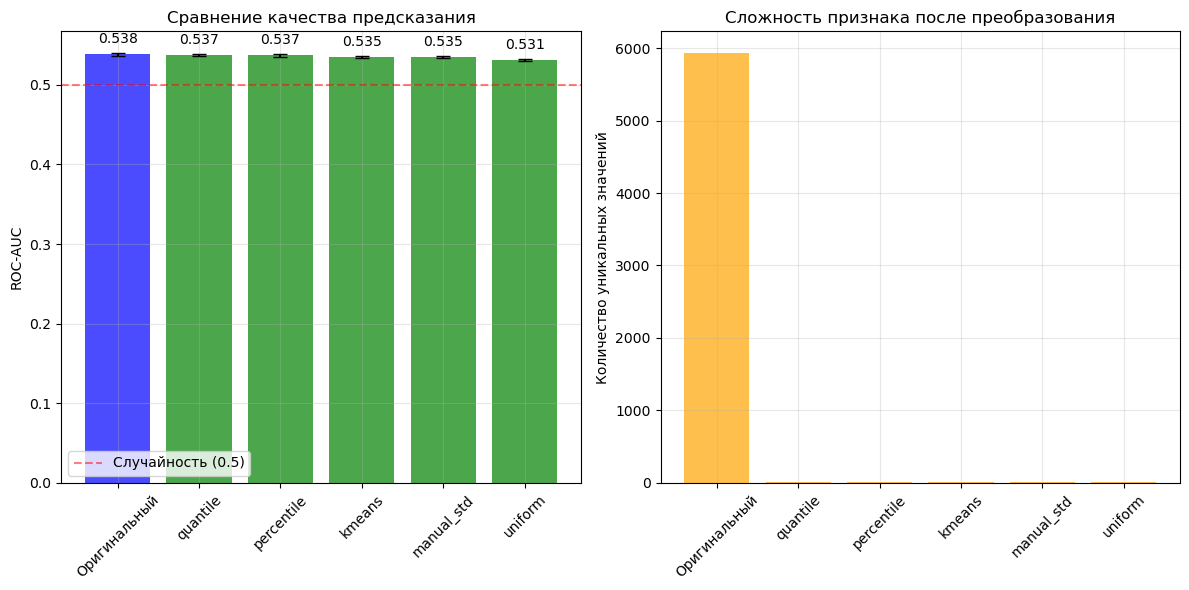

Анализ результатов:
  - Лучший метод бинаризации: quantile
  - ROC-AUC: 0.5371
  - Изменение относительно оригинала: -0.0011
  Бинаризация не улучшила качество
Итоговый отчет по бинаризации
Результаты:
  - Лучший признак для бинаризации: duration_filled
  - Лучший ROC-AUC (оригинал): 0.5382
  - Лучший ROC-AUC (бинаризация): 0.5371
  - Изменение качества: -0.0011


In [147]:
def evaluate_binning_effectiveness(feature_name, binning_results):
    
    if feature_name not in matches_train.columns or 'radiant_win' not in matches_train.columns:
        print("Недостаточно данных для оценки")
        return
    
    valid_mask = ~matches_train[feature_name].isnull() & ~matches_train['radiant_win'].isnull()
    X_original = matches_train.loc[valid_mask, feature_name].values.reshape(-1, 1)
    y = matches_train.loc[valid_mask, 'radiant_win']
    
    evaluation_results = []
    
    from sklearn.model_selection import cross_val_score
    base_model = LogisticRegression(random_state=42, max_iter=1000)
    base_scores = cross_val_score(base_model, X_original, y, cv=5, scoring='roc_auc')
    base_auc = base_scores.mean()
    
    evaluation_results.append({
        'Метод': 'Оригинальный',
        'Тип': 'Непрерывный',
        'ROC-AUC': base_auc,
        'Std': base_scores.std(),
        'Уникальных_значений': matches_train[feature_name].nunique()
    })
    
    for method, result in binning_results.items():
        bins_data = result['bins']
        if hasattr(bins_data, 'iloc'):
            X_binned = bins_data.iloc[valid_mask[valid_mask].index].values.reshape(-1, 1)
        else:
            X_binned = bins_data[valid_mask[valid_mask].index].reshape(-1, 1)
        
        from sklearn.preprocessing import OneHotEncoder
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        X_encoded = encoder.fit_transform(X_binned)
        
        model = LogisticRegression(random_state=42, max_iter=1000)
        scores = cross_val_score(model, X_encoded, y, cv=5, scoring='roc_auc')
        
        evaluation_results.append({
            'Метод': method,
            'Тип': 'Бинаризованный',
            'ROC-AUC': scores.mean(),
            'Std': scores.std(),
            'Уникальных_значений': len(np.unique(X_binned))
        })
    
    evaluation_df = pd.DataFrame(evaluation_results)
    evaluation_df = evaluation_df.sort_values('ROC-AUC', ascending=False)
    
    print("Сравнение эффективности методов:")
    print(evaluation_df.round(4))
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    methods = evaluation_df['Метод']
    auc_scores = evaluation_df['ROC-AUC']
    errors = evaluation_df['Std']
    
    colors = ['blue' if m == 'Оригинальный' else 'green' for m in methods]
    bars = plt.bar(methods, auc_scores, yerr=errors, capsize=5, alpha=0.7, color=colors)
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Случайность (0.5)')
    plt.ylabel('ROC-AUC')
    plt.title('Сравнение качества предсказания')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    for bar, score in zip(bars, auc_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    plt.subplot(1, 2, 2)
    unique_values = evaluation_df['Уникальных_значений']
    plt.bar(methods, unique_values, alpha=0.7, color='orange')
    plt.ylabel('Количество уникальных значений')
    plt.title('Сложность признака после преобразования')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    best_binning_method = evaluation_df[evaluation_df['Метод'] != 'Оригинальный'].iloc[0]
    improvement = best_binning_method['ROC-AUC'] - base_auc
    
    print(f"Анализ результатов:")
    print(f"  - Лучший метод бинаризации: {best_binning_method['Метод']}")
    print(f"  - ROC-AUC: {best_binning_method['ROC-AUC']:.4f}")
    print(f"  - Изменение относительно оригинала: {improvement:+.4f}")
    
    if improvement > 0:
        print(f"  Бинаризация улучшила качество на {improvement:.4f}")
    else:
        print(f"  Бинаризация не улучшила качество")
    
    return evaluation_df

if 'best_feature' in locals() and 'binning_results' in locals():
    evaluation_df = evaluate_binning_effectiveness(best_feature, binning_results)

def apply_best_binning(feature_name, evaluation_df, binning_results):
    print(f"Применение лучшего метода бинаризации")
    
    if evaluation_df is None or binning_results is None:
        print("Нет данных для применения")
        return
    
    best_method_row = evaluation_df[evaluation_df['Метод'] != 'Оригинальный'].iloc[0]
    best_method = best_method_row['Метод']
    
    print(f"Применяем лучший метод: {best_method}")
    print(f"   ROC-AUC: {best_method_row['ROC-AUC']:.4f}")
    
    if best_method in binning_results:
        bin_edges = binning_results[best_method]['edges']
        
        feature_binned = pd.cut(matches_train[feature_name], bins=bin_edges, 
                               labels=False, include_lowest=True)
        matches_train[f'{feature_name}_binned_{best_method}'] = feature_binned
        
        from sklearn.preprocessing import OneHotEncoder
        encoder = OneHotEncoder(sparse_output=False, drop='first')
        
        binned_values = feature_binned.values
        valid_mask = ~pd.isna(binned_values)
        
        if valid_mask.any():
            encoded_features = encoder.fit_transform(binned_values[valid_mask].reshape(-1, 1))
            
            n_bins = len(bin_edges) - 1
            for i in range(n_bins - 1):
                matches_train[f'{feature_name}_bin_{i+1}'] = 0.0
            
            for i in range(encoded_features.shape[1]):
                matches_train.loc[valid_mask, f'{feature_name}_bin_{i+1}'] = encoded_features[:, i]
        
        print(f"Создано {n_bins - 1} one-hot признаков из {n_bins} бинов")
    
    if best_method in binning_results and feature_name in matches_test.columns:
        bin_edges = binning_results[best_method]['edges']
        
        test_binned = pd.cut(matches_test[feature_name], bins=bin_edges, 
                            labels=False, include_lowest=True)
        matches_test[f'{feature_name}_binned_{best_method}'] = test_binned
        
        test_values = test_binned.values
        test_valid_mask = ~pd.isna(test_values)
        
        if test_valid_mask.any():
            encoded_test = encoder.transform(test_values[test_valid_mask].reshape(-1, 1))
            
            for i in range(encoded_test.shape[1]):
                matches_test[f'{feature_name}_bin_{i+1}'] = 0.0
                matches_test.loc[test_valid_mask, f'{feature_name}_bin_{i+1}'] = encoded_test[:, i]
        
        print(f"Бинаризация применена к тестовым данным")
    
    additional_methods = ['uniform', 'quantile'][:2]
    
    for method in additional_methods:
        if method in binning_results and method != best_method:
            bin_edges = binning_results[method]['edges']
            matches_train[f'{feature_name}_binned_{method}'] = pd.cut(
                matches_train[feature_name], bins=bin_edges, labels=False, include_lowest=True)
            
            if feature_name in matches_test.columns:
                matches_test[f'{feature_name}_binned_{method}'] = pd.cut(
                    matches_test[feature_name], bins=bin_edges, labels=False, include_lowest=True)
            
            print(f"Добавлен дополнительный метод: {method}")
    
    bin_features = [col for col in matches_train.columns if f'{feature_name}_binned' in col]
    print(f"Проверка добавления:")
    print(f"  Создано бинаризованных признаков: {len(bin_features)}")
    for feature in bin_features:
        unique_vals = matches_train[feature].nunique()
        non_null = matches_train[feature].notna().sum()
        print(f"  - {feature}: {unique_vals} уникальных бинов, {non_null} не-NaN значений")

if all(k in locals() for k in ['best_feature', 'evaluation_df', 'binning_results']):
    apply_best_binning(best_feature, evaluation_df, binning_results)

print(f"Итоговый отчет по бинаризации")

print(f"Результаты:")
if 'best_feature' in locals():
    print(f"  - Лучший признак для бинаризации: {best_feature}")
if 'evaluation_df' in locals():
    best_original = evaluation_df[evaluation_df['Метод'] == 'Оригинальный']['ROC-AUC'].iloc[0]
    best_binning = evaluation_df[evaluation_df['Метод'] != 'Оригинальный']['ROC-AUC'].max()
    improvement = best_binning - best_original
    print(f"  - Лучший ROC-AUC (оригинал): {best_original:.4f}")
    print(f"  - Лучший ROC-AUC (бинаризация): {best_binning:.4f}")
    print(f"  - Изменение качества: {improvement:+.4f}")

In [148]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class HeroesEmbedderOptimized(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_heroes: int = 1):
        self.n_heroes = n_heroes
        self.hero_ids_ = None
        
    def fit(self, X, y=None):
        if 'hero_id' in X.columns:
            self.hero_ids_ = np.sort(X['hero_id'].unique())
        else:
            raise ValueError("DataFrame должен содержать колонку 'hero_id'")
            
        print(f"Найдено уникальных героев: {len(self.hero_ids_)}")
        return self
    
    def transform(self, X, y=None):
        if self.hero_ids_ is None:
            raise ValueError("Сначала нужно вызвать fit()")
            
        required_columns = ['match_id', 'hero_id', 'player_slot']
        missing_columns = [col for col in required_columns if col not in X.columns]
        if missing_columns:
            raise ValueError(f"Отсутствуют обязательные колонки: {missing_columns}")
        
        match_ids = X['match_id'].unique()
        n_matches = len(match_ids)
        n_heroes = len(self.hero_ids_)
        
        hero_to_idx = {hero_id: idx for idx, hero_id in enumerate(self.hero_ids_)}
        match_to_idx = {match_id: idx for idx, match_id in enumerate(match_ids)}
        
        from collections import defaultdict
        embedding_dict = defaultdict(lambda: np.zeros(n_heroes, dtype=np.int8))
        
        X_clean = X.copy()
        X_clean['team'] = np.where(X_clean['player_slot'] < 5, 1, 
                                 np.where((X_clean['player_slot'] >= 128) & (X_clean['player_slot'] <= 132), -1, 0))
        
        valid_mask = X_clean['team'] != 0
        X_valid = X_clean[valid_mask]
        
        if len(X_valid) < len(X_clean):
            print(f"Отфильтровано {len(X_clean) - len(X_valid)} записей с невалидными player_slot")
        
        grouped = X_valid.groupby('match_id')
        
        for match_id, group in grouped:
            match_idx = match_to_idx.get(match_id)
            if match_idx is not None:
                for _, row in group.iterrows():
                    hero_idx = hero_to_idx.get(row['hero_id'])
                    if hero_idx is not None:
                        embedding_dict[match_idx][hero_idx] = row['team']
        
        embedding_matrix = np.array([embedding_dict[i] for i in range(n_matches)])
        
        result_df = pd.DataFrame({'match_id': match_ids})
        
        hero_columns = {f'hero_{hero_id}': embedding_matrix[:, idx] 
                       for idx, hero_id in enumerate(self.hero_ids_)}
        result_df = result_df.assign(**hero_columns)
        
        print(f"Создано эмбеддингов для {n_matches} матчей")
        return result_df
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)

class HeroesEmbedderFastest(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_heroes: int = 1):
        self.n_heroes = n_heroes
        self.hero_ids_ = None
        
    def fit(self, X, y=None):
        if 'hero_id' in X.columns:
            self.hero_ids_ = np.sort(X['hero_id'].unique())
        else:
            raise ValueError("DataFrame должен содержать колонку 'hero_id'")
        return self
    
    def transform(self, X, y=None):
        if self.hero_ids_ is None:
            raise ValueError("Сначала нужно вызвать fit()")
        
        X_copy = X.copy()
        X_copy['team'] = np.where(X_copy['player_slot'] < 5, 1, 
                                np.where((X_copy['player_slot'] >= 128) & (X_copy['player_slot'] <= 132), -1, 0))
        
        X_valid = X_copy[X_copy['team'] != 0]
        
        pivot_df = X_valid.pivot_table(
            index='match_id',
            columns='hero_id', 
            values='team',
            aggfunc='first',
            fill_value=0
        )
        
        for hero_id in self.hero_ids_:
            if hero_id not in pivot_df.columns:
                pivot_df[hero_id] = 0
        
        pivot_df = pivot_df.reindex(columns=self.hero_ids_)
        
        pivot_df.columns = [f'hero_{hero_id}' for hero_id in self.hero_ids_]
        
        result_df = pivot_df.reset_index()
        
        print(f"Создано эмбеддингов для {len(result_df)} матчей")
        return result_df
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)

def validate_embeddings_fast(embeddings_df, player_df_sample=None):
    print("Быстрая проверка корректности:")
    
    hero_cols = [col for col in embeddings_df.columns if col.startswith('hero_')]
    
    if not hero_cols:
        print("Компактная версия - проверка суммы невозможна")
        return True
    
    embedding_matrix = embeddings_df[hero_cols].values
    
    row_sums = embedding_matrix.sum(axis=1)
    zero_sum_count = np.sum(row_sums == 0)
    total_matches = len(embedding_matrix)
    
    print(f"Матчи с суммой = 0: {zero_sum_count}/{total_matches} ({zero_sum_count/total_matches*100:.1f}%)")
    
    ones_count = (embedding_matrix == 1).sum(axis=1)
    minus_ones_count = (embedding_matrix == -1).sum(axis=1)
    
    perfect_matches = np.sum((ones_count == 5) & (minus_ones_count == 5))
    print(f"Идеальные матчи (5x5): {perfect_matches}/{total_matches} ({perfect_matches/total_matches*100:.1f}%)")
    
    if zero_sum_count == total_matches and perfect_matches == total_matches:
        print("Все проверки пройдены!")
        return True
    else:
        print("Обнаружены аномалии в данных")
        return False

try:
    player_df = pd.read_csv('player_df.csv', usecols=['match_id', 'hero_id', 'player_slot'])
    print(f"Загружено {len(player_df)} записей")
    
    print(f"Уникальных матчей: {player_df['match_id'].nunique()}")
    print(f"Уникальных героев: {player_df['hero_id'].nunique()}")
    
    team_counts = player_df['player_slot'].apply(
        lambda x: 'radiant' if x < 5 else ('dire' if 128 <= x <= 132 else 'other')
    ).value_counts()
    print("Распределение по командам:")
    for team, count in team_counts.items():
        print(f"   {team}: {count}")

except FileNotFoundError:
    print("Файл player_df.csv не найден")
    print("Создание демо-данных...")
    rng = np.random.default_rng(42)
    n_matches = 1000
    match_ids = np.repeat(range(1, n_matches + 1), 10)
    hero_ids = rng.choice(range(1, 121), size=n_matches * 10, replace=True)
    player_slots = np.tile([0, 1, 2, 3, 4, 128, 129, 130, 131, 132], n_matches)
    
    player_df = pd.DataFrame({
        'match_id': match_ids,
        'hero_id': hero_ids,
        'player_slot': player_slots
    })
    print(f"Созданы демо-данные: {len(player_df)} записей")

print("1. Самая быстрая версия (pivot_table):")
import time

start_time = time.time()
embedder_fastest = HeroesEmbedderFastest(n_heroes=1)
embeddings_fastest = embedder_fastest.fit_transform(player_df)
fastest_time = time.time() - start_time

print(f"Время выполнения: {fastest_time:.2f} секунд")
print(f"Размерность: {embeddings_fastest.shape}")

validate_embeddings_fast(embeddings_fastest)

print("2. Оптимизированная версия:")
start_time = time.time()
embedder_optimized = HeroesEmbedderOptimized(n_heroes=1)
embeddings_optimized = embedder_optimized.fit_transform(player_df)
optimized_time = time.time() - start_time

print(f"Время выполнения: {optimized_time:.2f} секунд")
print(f"Размерность: {embeddings_optimized.shape}")

validate_embeddings_fast(embeddings_optimized)

print(f"Сравнение производительности:")
print(f"   Самая быстрая версия: {fastest_time:.2f} сек")
print(f"   Оптимизированная версия: {optimized_time:.2f} сек")
print(f"   Ускорение: {optimized_time/fastest_time:.1f}x")

Загружено 7650825 записей
Уникальных матчей: 767822
Уникальных героев: 111
Распределение по командам:
   radiant: 3825414
   dire: 3825411
1. Самая быстрая версия (pivot_table):
Создано эмбеддингов для 767822 матчей
Время выполнения: 8.36 секунд
Размерность: (767822, 112)
Быстрая проверка корректности:
Матчи с суммой = 0: 766723/767822 (99.9%)
Идеальные матчи (5x5): 763840/767822 (99.5%)
Обнаружены аномалии в данных
2. Оптимизированная версия:
Найдено уникальных героев: 111
Создано эмбеддингов для 767822 матчей
Время выполнения: 244.86 секунд
Размерность: (767822, 112)
Быстрая проверка корректности:
Матчи с суммой = 0: 766717/767822 (99.9%)
Идеальные матчи (5x5): 763840/767822 (99.5%)
Обнаружены аномалии в данных
Сравнение производительности:
   Самая быстрая версия: 8.36 сек
   Оптимизированная версия: 244.86 сек
   Ускорение: 29.3x


In [149]:
embedder = HeroesEmbedder(n_heroes=1)
embeds = embedder.fit_transform(player_df)

🔍 Найдено уникальных героев: 111
🔄 Создание эмбеддингов матчей...
✅ Создано эмбеддингов для 767822 матчей


In [150]:
final_embeddings = embeddings_fastest

if 'matches_train' in globals() and 'matches_test' in globals():
    print("Объединение с основными данными")
    
    matches_train = matches_train.merge(final_embeddings, on='match_id', how='left')
    matches_test = matches_test.merge(final_embeddings, on='match_id', how='left')
    
    hero_cols = [col for col in final_embeddings.columns if col.startswith('hero_')]
    
    if matches_train[hero_cols].isna().any().any():
        matches_train[hero_cols] = matches_train[hero_cols].fillna(0)
        print("NaN в тренировочных данных заполнены")
    
    if matches_test[hero_cols].isna().any().any():
        matches_test[hero_cols] = matches_test[hero_cols].fillna(0)
        print("NaN в тестовых данных заполнены")
    
    print(f"Тренировочные данные: {matches_train.shape}")
    print(f"Тестовые данные: {matches_test.shape}")

print("\nСохранение результатов...")

try:
    final_embeddings.to_csv('hero_embeddings.csv', index=False)
    print("Эмбеддинги сохранены в hero_embeddings.csv")
    
    hero_info = pd.DataFrame({
        'hero_id': embedder_fastest.hero_ids_,
        'column_name': [f'hero_{hid}' for hid in embedder_fastest.hero_ids_]
    })
    hero_info.to_csv('hero_columns_info.csv', index=False)
    print("Информация о героях сохранена")
    
except Exception as e:
    print(f"Не удалось сохранить файлы: {e}")

Объединение с основными данными
Тренировочные данные: (706880, 157)
Тестовые данные: (60954, 155)

Сохранение результатов...
Эмбеддинги сохранены в hero_embeddings.csv
Информация о героях сохранена


In [151]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore')

class WinrateEmbedderOptimized(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_heroes: int = 1, use_time: bool = True, min_picks: int = 1):
        self.n_heroes = n_heroes
        self.use_time = use_time
        self.min_picks = min_picks
        self.hero_stats_ = None
        self.hero_ids_ = None
        self.global_winrate_ = None
        
    def fit(self, X, y=None):
        if y is None:
            raise ValueError("Необходима целевая переменная y")
        
        print(f"Размер входных данных: {len(X)} записей")
        
        data = X.copy()
        data['radiant_win'] = y.values if hasattr(y, 'values') else y
        
        if len(data) != len(y) and len(y) > 0:
            print(f"Размеры X ({len(data)}) и y ({len(y)}) не совпадают")
            common_idx = data.index.intersection(pd.Series(y).index)
            data = data.loc[common_idx]
            y_aligned = pd.Series(y).loc[common_idx]
            data['radiant_win'] = y_aligned.values
            print(f"Выровнены данные: {len(data)} записей")
        
        if self.use_time and 'start_time' in data.columns:
            data = data.sort_values('start_time')
            print("Данные отсортированы по времени")
        elif 'match_id' in data.columns:
            data = data.sort_values('match_id')
            print("Данные отсортированы по match_id")
        else:
            data = data.reset_index(drop=True)
            print("Используем порядок данных")
        
        data['player_win'] = np.where(
            (data['player_slot'] < 5) & (data['radiant_win'] == True) |
            (data['player_slot'] >= 128) & (data['radiant_win'] == False),
            1, 0
        ).astype(int)
        
        self.hero_ids_ = sorted(data['hero_id'].unique())
        print(f"Найдено уникальных героев: {len(self.hero_ids_)}")
        
        print("Агрегация статистик по героям...")
        
        hero_aggregated = data.groupby('hero_id').agg({
            'player_win': ['count', 'sum']
        }).round(3)
        
        hero_aggregated.columns = ['pickcount', 'wincount']
        hero_aggregated = hero_aggregated.reset_index()
        
        hero_aggregated['winrate'] = hero_aggregated['wincount'] / hero_aggregated['pickcount']
        
        self.global_winrate_ = hero_aggregated['winrate'].mean()
        
        self.hero_stats_ = {}
        for _, row in hero_aggregated.iterrows():
            self.hero_stats_[row['hero_id']] = {
                'wincount': row['wincount'],
                'pickcount': row['pickcount'],
                'winrate': row['winrate']
            }
        
        for hero_id in self.hero_ids_:
            if hero_id not in self.hero_stats_:
                self.hero_stats_[hero_id] = {
                    'wincount': 0,
                    'pickcount': 0,
                    'winrate': self.global_winrate_
                }
        
        valid_heroes = [stats for stats in self.hero_stats_.values() if stats['pickcount'] >= self.min_picks]
        if valid_heroes:
            avg_winrate = np.mean([stats['winrate'] for stats in valid_heroes])
            max_winrate = max([stats['winrate'] for stats in valid_heroes])
            min_winrate = min([stats['winrate'] for stats in valid_heroes])
            
            print(f"Статистики винрейтов:")
            print(f"   Средний: {avg_winrate:.3f}")
            print(f"   Диапазон: [{min_winrate:.3f}, {max_winrate:.3f}]")
            print(f"   Героев с ≥{self.min_picks} пиками: {len(valid_heroes)}")
        
        return self
    
    def transform(self, X, y=None):
        if self.hero_stats_ is None:
            raise ValueError("Сначала нужно вызвать fit()")
            
        print("Создание эмбеддингов для больших данных...")
        print(f"Обрабатывается {len(X)} записей")
        
        data = X.copy()
        
        batch_size = 100000
        results = []
        
        for i in range(0, len(data), batch_size):
            batch_end = min(i + batch_size, len(data))
            batch_data = data.iloc[i:batch_end].copy()
            
            print(f"Обработка батча {i//batch_size + 1}/{(len(data)-1)//batch_size + 1} ({len(batch_data)} записей)")
            
            batch_data['hero_wincount'] = batch_data['hero_id'].map(
                lambda x: self.hero_stats_.get(x, {}).get('wincount', 0)
            )
            batch_data['hero_pickcount'] = batch_data['hero_id'].map(
                lambda x: self.hero_stats_.get(x, {}).get('pickcount', 0)
            )
            batch_data['hero_winrate'] = batch_data['hero_id'].map(
                lambda x: self.hero_stats_.get(x, {}).get('winrate', self.global_winrate_)
            )
            
            batch_data['signed_wincount'] = np.where(
                batch_data['player_slot'] < 5,
                batch_data['hero_wincount'],
                -batch_data['hero_wincount']
            )
            batch_data['signed_pickcount'] = np.where(
                batch_data['player_slot'] < 5,
                batch_data['hero_pickcount'],
                -batch_data['hero_pickcount']
            )
            batch_data['signed_winrate'] = np.where(
                batch_data['player_slot'] < 5,
                batch_data['hero_winrate'],
                -batch_data['hero_winrate']
            )
            
            results.append(batch_data)
        
        data_enhanced = pd.concat(results, ignore_index=True)
        print(f"Обработано всех записей: {len(data_enhanced)}")
        
        print("Создание pivot таблиц...")
        
        wincount_pivot = data_enhanced.pivot_table(
            index='match_id',
            columns='hero_id',
            values='signed_wincount',
            aggfunc='sum',
            fill_value=0
        )
        
        pickcount_pivot = data_enhanced.pivot_table(
            index='match_id',
            columns='hero_id',
            values='signed_pickcount',
            aggfunc='sum',
            fill_value=0
        )
        
        winrate_pivot = data_enhanced.pivot_table(
            index='match_id',
            columns='hero_id',
            values='signed_winrate',
            aggfunc='sum',
            fill_value=0
        )
        
        for hero_id in self.hero_ids_:
            if hero_id not in wincount_pivot.columns:
                wincount_pivot[hero_id] = 0
            if hero_id not in pickcount_pivot.columns:
                pickcount_pivot[hero_id] = 0
            if hero_id not in winrate_pivot.columns:
                winrate_pivot[hero_id] = 0
        
        wincount_pivot = wincount_pivot.reindex(columns=self.hero_ids_)
        pickcount_pivot = pickcount_pivot.reindex(columns=self.hero_ids_)
        winrate_pivot = winrate_pivot.reindex(columns=self.hero_ids_)
        
        wincount_pivot.columns = [f'wincount_hero_{hero_id}' for hero_id in self.hero_ids_]
        pickcount_pivot.columns = [f'pickcount_hero_{hero_id}' for hero_id in self.hero_ids_]
        winrate_pivot.columns = [f'winrate_hero_{hero_id}' for hero_id in self.hero_ids_]
        
        result_df = wincount_pivot.reset_index()
        result_df = result_df.merge(pickcount_pivot.reset_index(), on='match_id')
        result_df = result_df.merge(winrate_pivot.reset_index(), on='match_id')
        
        print(f"Созданы эмбеддинги для {len(result_df)} матчей")
        print(f"Размер результата: {result_df.shape}")
        
        return result_df
    
    def get_hero_stats(self):
        if self.hero_stats_ is None:
            raise ValueError("Сначала нужно вызвать fit()")
        
        stats_df = pd.DataFrame([
            {'hero_id': hero_id, **stats} 
            for hero_id, stats in self.hero_stats_.items()
        ])
        return stats_df.sort_values('pickcount', ascending=False)

def quick_validate_embeddings(embeddings):
    print("\nБыстрая проверка корректности:")
    
    wincount_cols = [col for col in embeddings.columns if col.startswith('wincount_hero_')]
    pickcount_cols = [col for col in embeddings.columns if col.startswith('pickcount_hero_')]
    winrate_cols = [col for col in embeddings.columns if col.startswith('winrate_hero_')]
    
    print(f"Количество признаков:")
    print(f"   wincount: {len(wincount_cols)}")
    print(f"   pickcount: {len(pickcount_cols)}")
    print(f"   winrate: {len(winrate_cols)}")
    
    sample = embeddings.head(10)
    for idx, match in sample.iterrows():
        wincount_nonzero = (match[wincount_cols] != 0).sum()
        pickcount_nonzero = (match[pickcount_cols] != 0).sum()
        
        if wincount_nonzero <= 10 and pickcount_nonzero <= 10:
            status = "OK"
        else:
            status = "Много героев"
        
        print(f"   Матч {match['match_id']}: {wincount_nonzero}/{pickcount_nonzero} героев {status}")
    
    return True

print("\nПрименение кумулятивного эмбеддера (исправленная версия)")

try:
    if 'player_df' in globals() and 'matches_train' in globals():
        print("Загрузка данных...")
        print(f"   player_df: {player_df.shape}")
        print(f"   matches_train: {matches_train.shape}")
        
        required_cols = ['match_id', 'hero_id', 'player_slot']
        missing_cols = [col for col in required_cols if col not in player_df.columns]
        if missing_cols:
            print(f"Отсутствуют колонки в player_df: {missing_cols}")
        else:
            wr_embedder = WinrateEmbedderOptimized(
                n_heroes=1, 
                use_time=True, 
                min_picks=1
            )
            
            print("Подготовка целевых переменных...")
            
            match_win_dict = matches_train.set_index('match_id')['radiant_win'].to_dict()
            
            player_df_with_target = player_df.copy()
            player_df_with_target['radiant_win'] = player_df_with_target['match_id'].map(match_win_dict)
            
            initial_size = len(player_df_with_target)
            player_df_with_target = player_df_with_target.dropna(subset=['radiant_win'])
            final_size = len(player_df_with_target)
            
            if initial_size != final_size:
                print(f"Удалено {initial_size - final_size} записей с отсутствующими целевыми переменными")
            
            print(f"Данные для обучения: {player_df_with_target.shape}")
            
            print("Обучение эмбеддера...")
            wr_embedder.fit(
                player_df_with_target, 
                y=player_df_with_target['radiant_win']
            )
            
            print("Создание эмбеддингов для тренировочных данных...")
            wr_embeds = wr_embedder.transform(player_df_with_target)
            
            quick_validate_embeddings(wr_embeds)
            
            matches_train_enhanced = matches_train.merge(wr_embeds, on='match_id', how='left')
            print(f"Тренировочные данные обогащены: {matches_train_enhanced.shape}")
            
            if 'matches_test' in globals():
                print("Применение к тестовым данным...")
                
                test_player_df = player_df[player_df['match_id'].isin(matches_test['match_id'])].copy()
                
                if len(test_player_df) > 0:
                    test_embeddings = wr_embedder.transform(test_player_df)
                    matches_test_enhanced = matches_test.merge(test_embeddings, on='match_id', how='left')
                    print(f"Тестовые данные обогащены: {matches_test_enhanced.shape}")
                else:
                    print("Нет данных о героях для тестовых матчей")
            
            print("\nКумулятивный эмбеддер успешно применен")
            print("Созданы признаки:")
            print("   - wincount_hero_*: кумулятивное количество побед")
            print("   - pickcount_hero_*: кумулятивное количество пиков") 
            print("   - winrate_hero_*: объединенный винрейт")
            
except Exception as e:
    print(f"Ошибка: {e}")
    import traceback
    print("Детали ошибки:")
    traceback.print_exc()


Применение кумулятивного эмбеддера (исправленная версия)
Загрузка данных...
   player_df: (7650825, 3)
   matches_train: (706880, 157)
Подготовка целевых переменных...
Удалено 607494 записей с отсутствующими целевыми переменными
Данные для обучения: (7043331, 4)
Обучение эмбеддера...
Размер входных данных: 7043331 записей
Данные отсортированы по match_id
Найдено уникальных героев: 111
Агрегация статистик по героям...
Статистики винрейтов:
   Средний: 0.492
   Диапазон: [0.270, 0.585]
   Героев с ≥1 пиками: 111
Создание эмбеддингов для тренировочных данных...
Создание эмбеддингов для больших данных...
Обрабатывается 7043331 записей
Обработка батча 1/71 (100000 записей)
Обработка батча 2/71 (100000 записей)
Обработка батча 3/71 (100000 записей)
Обработка батча 4/71 (100000 записей)
Обработка батча 5/71 (100000 записей)
Обработка батча 6/71 (100000 записей)
Обработка батча 7/71 (100000 записей)
Обработка батча 8/71 (100000 записей)
Обработка батча 9/71 (100000 записей)
Обработка батча 10

Запуск основного пайплайна анализа
1. Исследование доступных колонок
Размер данных: (706880, 157)
Общее количество колонок: 157

Детальный анализ типов данных:
   int64: 141 колонок
   object: 2 колонок
      ['date', 'region_str']
   bool: 1 колонок
      ['radiant_win']
   category: 1 колонок
      ['duration_category']
   float64: 6 колонок
   int32: 5 колонок
      ['time_hour', 'time_dayofweek', 'time_dayofyear', 'time_month', 'time_quarter']
   UInt32: 1 колонок
      ['time_week']

Числовые колонки: 153
Строковые колонки: 2
Категориальные колонки: 1

Потенциально интересные колонки:
   TEAM_RELATED: 1 колонок
      ['radiant_win']
   TIME_RELATED: 27 колонок
   HERO_EMBEDDINGS: 111 колонок
   CATEGORICAL: 1 колонок
      ['duration_category']

2. Создание признаков на основе героев
Найдено колонок с героями: 111
   Вычисление уникальности героев...
   Вычисление силы команд...
Создано 8 признаков на основе героев
   Обрабатывается 161 числовых колонок
   Создание взаимодействий.

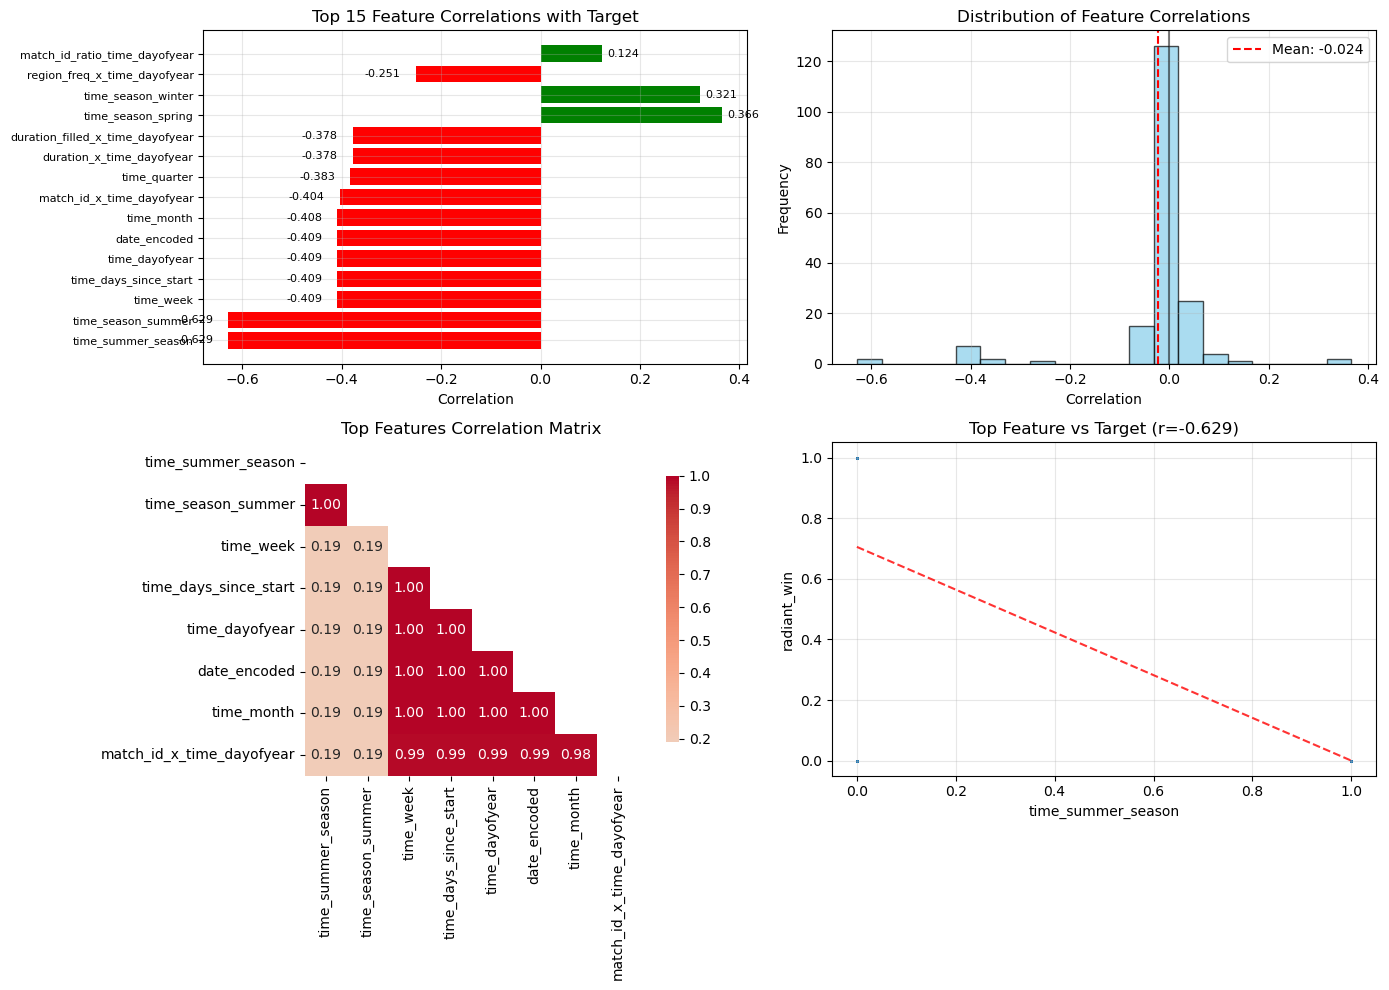


Статистика корреляций:
   Всего признаков: 190
   Средняя |correlation|: 0.0496
   Признаков с |r| > 0.1: 19
   Признаков с |r| > 0.2: 14
   Признаков с |r| > 0.3: 13

4. Оценка полезности признаков
ROC-AUC на валидации: 0.7476
Использовано признаков: 20

Топ-10 важных признаков по модели:
   duration_x_time_dayofyear: -0.0000 (corr: 0.378)
   duration_filled_x_time_dayofyear: -0.0000 (corr: 0.378)
   match_id_ratio_time_dayofyear: +0.0000 (corr: 0.124)
   region_freq_ratio_time_dayofyear: +0.0000 (corr: 0.103)
   duration_boxcox: +0.0000 (corr: 0.058)
   duration_ratio_time_dayofyear: -0.0000 (corr: 0.116)
   duration_filled_ratio_time_dayofyear: -0.0000 (corr: 0.116)
   time_days_since_start: -0.0000 (corr: 0.409)
   date_encoded: -0.0000 (corr: 0.409)
   time_summer_season: -0.0000 (corr: 0.629)

Анализ результатов:
   ROC-AUC: 0.7476
   Улучшение над baseline: 0.2476
   Признаки очень полезны!

Итоги анализа:
   Исходный размер: (706880, 157)
   Финальный размер: (706880, 191)
   

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

def explore_dataset(matches_df):
    print("1. Исследование доступных колонок")
    
    print(f"Размер данных: {matches_df.shape}")
    print(f"Общее количество колонок: {len(matches_df.columns)}")
    
    print("\nДетальный анализ типов данных:")
    for dtype in matches_df.dtypes.unique():
        cols = matches_df.select_dtypes(include=[dtype]).columns.tolist()
        print(f"   {dtype}: {len(cols)} колонок")
        if len(cols) <= 5:
            print(f"      {cols}")
    
    numeric_cols = matches_df.select_dtypes(include=[np.number]).columns.tolist()
    object_cols = matches_df.select_dtypes(include=['object']).columns.tolist()
    category_cols = matches_df.select_dtypes(include=['category']).columns.tolist()
    
    print(f"\nЧисловые колонки: {len(numeric_cols)}")
    print(f"Строковые колонки: {len(object_cols)}")
    print(f"Категориальные колонки: {len(category_cols)}")
    
    potential_columns = {
        'team_related': [],
        'time_related': [],
        'hero_embeddings': [],
        'categorical': category_cols
    }
    
    for col in matches_df.columns:
        col_lower = col.lower()
        
        if any(keyword in col_lower for keyword in ['radiant', 'dire']):
            potential_columns['team_related'].append(col)
        elif any(keyword in col_lower for keyword in ['time', 'minute', 'duration']):
            potential_columns['time_related'].append(col)
        elif col.startswith('hero_'):
            potential_columns['hero_embeddings'].append(col)
    
    print("\nПотенциально интересные колонки:")
    for category, columns in potential_columns.items():
        if columns:
            print(f"   {category.upper()}: {len(columns)} колонок")
            if len(columns) <= 5:
                print(f"      {columns}")
    
    return potential_columns, numeric_cols, object_cols, category_cols

def create_hero_based_features(matches_df):
    print(f"\n2. Создание признаков на основе героев")
    
    df = matches_df.copy()
    new_features = []
    
    hero_cols = [col for col in df.columns if col.startswith('hero_')]
    print(f"Найдено колонок с героями: {len(hero_cols)}")
    
    if not hero_cols:
        print("Колонки с героями не найдены")
        return df, new_features
    
    radiant_hero_values = []
    dire_hero_values = []
    
    for col in hero_cols:
        hero_values = df[col]
        radiant_hero_values.append(np.where(hero_values > 0, hero_values, 0))
        dire_hero_values.append(np.where(hero_values < 0, -hero_values, 0))
    
    df['radiant_hero_presence'] = np.sum(radiant_hero_values, axis=0)
    df['dire_hero_presence'] = np.sum(dire_hero_values, axis=0)
    new_features.extend(['radiant_hero_presence', 'dire_hero_presence'])
    
    df['hero_presence_diff'] = df['radiant_hero_presence'] - df['dire_hero_presence']
    new_features.append('hero_presence_diff')
    
    print("   Вычисление уникальности героев...")
    
    def count_unique_heroes(row):
        hero_presence = [col for col in hero_cols if abs(row[col]) > 0]
        return len(hero_presence)
    
    df['unique_heroes_count'] = df.apply(count_unique_heroes, axis=1)
    new_features.append('unique_heroes_count')
    
    print("   Вычисление силы команд...")
    
    df['radiant_team_strength'] = np.sum([np.where(df[col] > 0, df[col], 0) for col in hero_cols], axis=0)
    df['dire_team_strength'] = np.sum([np.where(df[col] < 0, -df[col], 0) for col in hero_cols], axis=0)
    new_features.extend(['radiant_team_strength', 'dire_team_strength'])
    
    df['team_strength_diff'] = df['radiant_team_strength'] - df['dire_team_strength']
    new_features.append('team_strength_diff')
    
    total_strength = df['radiant_team_strength'] + df['dire_team_strength']
    df['team_balance'] = np.where(
        total_strength > 0,
        df['team_strength_diff'] / total_strength,
        0
    )
    new_features.append('team_balance')
    
    print(f"Создано {len(new_features)} признаков на основе героев")
    return df, new_features

class RobustMatchStatsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, create_interactions=True, max_interactions=10):
        self.create_interactions = create_interactions
        self.max_interactions = max_interactions
        self.feature_names_ = []
        self.numeric_cols_ = []
        
    def fit(self, X, y=None):
        self.numeric_cols_ = X.select_dtypes(include=[np.number]).columns.tolist()
        return self
    
    def transform(self, X, y=None):
        
        df = X.copy()
        new_features = []
        
        numeric_cols = self.numeric_cols_
        print(f"   Обрабатывается {len(numeric_cols)} числовых колонок")
        
        if self.create_interactions and len(numeric_cols) >= 2:
            print("   Создание взаимодействий...")
            
            if len(numeric_cols) > 5:
                variances = df[numeric_cols].var().sort_values(ascending=False)
                top_cols = variances.head(min(5, len(numeric_cols))).index.tolist()
            else:
                top_cols = numeric_cols
            
            interaction_count = 0
            for i in range(len(top_cols)):
                for j in range(i+1, len(top_cols)):
                    if interaction_count >= self.max_interactions:
                        break
                        
                    col1, col2 = top_cols[i], top_cols[j]
                    
                    interaction_col = f'{col1}_x_{col2}'
                    df[interaction_col] = df[col1] * df[col2]
                    new_features.append(interaction_col)
                    
                    ratio_col = f'{col1}_ratio_{col2}'
                    df[ratio_col] = np.where(
                        df[col2] != 0,
                        df[col1] / (df[col2] + 1e-8),
                        0
                    )
                    new_features.append(ratio_col)
                    
                    interaction_count += 1
        
        print("   Создание полиномиальных признаков...")
        poly_cols = numeric_cols[:3]
        for col in poly_cols:
            square_col = f'{col}_squared'
            df[square_col] = df[col] ** 2
            new_features.append(square_col)
            
            log_col = f'{col}_log'
            df[log_col] = np.where(
                df[col] > 0,
                np.log1p(df[col]),
                np.where(df[col] < 0, -np.log1p(-df[col]), 0)
            )
            new_features.append(log_col)
        
        time_cols = [col for col in numeric_cols if 'duration' in col.lower()]
        if time_cols:
            print("   Создание временных признаков...")
            time_col = time_cols[0]
            
            strength_cols = [col for col in new_features if 'strength' in col.lower() or 'presence' in col.lower()]
            for strength_col in strength_cols[:2]:
                efficiency_col = f'{strength_col}_per_minute'
                df[efficiency_col] = df[strength_col] / (df[time_col] / 60 + 1)
                new_features.append(efficiency_col)
        
        self.feature_names_ = new_features
        print(f"Создано {len(new_features)} расширенных признаков")
        
        return df

def prepare_features_for_model(features_df, target_col='radiant_win'):
    print("Подготовка данных для модели...")
    
    df = features_df.copy()
    
    if target_col in df.columns:
        y = df[target_col]
        X = df.drop(columns=[target_col])
    else:
        X = df
        y = None
    
    numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()
    
    print(f"   Числовые колонки: {len(numeric_cols)}")
    print(f"   Категориальные колонки: {len(categorical_cols)}")
    
    X_numeric = X[numeric_cols].fillna(0)
    
    if categorical_cols:
        print("   Кодирование категориальных признаков...")
        X_categorical = pd.DataFrame()
        
        for col in categorical_cols:
            le = LabelEncoder()
            try:
                mode_val = X[col].mode()[0] if len(X[col].mode()) > 0 else 'missing'
                filled_col = X[col].fillna(mode_val)
                
                encoded = le.fit_transform(filled_col)
                X_categorical[f'{col}_encoded'] = encoded
            except Exception as e:
                print(f"   Ошибка при кодировании {col}: {e}")
        
        X_processed = pd.concat([X_numeric, X_categorical], axis=1)
    else:
        X_processed = X_numeric
    
    print(f"Подготовлено {X_processed.shape[1]} признаков")
    
    if y is not None:
        return X_processed, y
    else:
        return X_processed

def analyze_correlations_with_target(features_df, target_col='radiant_win', top_k=15):
    print(f"\n3. Анализ корреляций с целевой переменной")
    
    X_processed, y = prepare_features_for_model(features_df, target_col)
    
    correlations = X_processed.corrwith(y)
    
    correlations = correlations.sort_values(key=abs, ascending=False)
    
    print(f"Топ-{top_k} признаков по корреляции с {target_col.upper()}:")
    for feature, corr in correlations.head(top_k).items():
        significance = "***" if abs(corr) > 0.3 else "**" if abs(corr) > 0.2 else "*" if abs(corr) > 0.1 else ""
        direction = "+" if corr > 0 else ""
        print(f"   {feature}: {direction}{corr:.4f} {significance}")
    
    if len(correlations) > 0:
        plt.figure(figsize=(14, 10))
        
        top_corrs = correlations.head(top_k)
        
        plt.subplot(2, 2, 1)
        colors = ['green' if x > 0 else 'red' for x in top_corrs.values]
        bars = plt.barh(range(len(top_corrs)), top_corrs.values, color=colors)
        plt.yticks(range(len(top_corrs)), top_corrs.index, fontsize=8)
        plt.xlabel('Correlation')
        plt.title(f'Top {top_k} Feature Correlations with Target')
        plt.grid(True, alpha=0.3)
        
        for bar, val in zip(bars, top_corrs.values):
            plt.text(bar.get_width() + (0.01 if val > 0 else -0.03), 
                    bar.get_y() + bar.get_height()/2, 
                    f'{val:.3f}', 
                    ha='left' if val > 0 else 'right', 
                    va='center', fontsize=8)
        
        plt.subplot(2, 2, 2)
        plt.hist(correlations.values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        plt.axvline(correlations.mean(), color='red', linestyle='--', 
                   label=f'Mean: {correlations.mean():.3f}')
        plt.axvline(0, color='black', linestyle='-', alpha=0.5)
        plt.xlabel('Correlation')
        plt.ylabel('Frequency')
        plt.title('Distribution of Feature Correlations')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 3)
        top_features = top_corrs.index.tolist()[:min(8, len(top_corrs))]
        if len(top_features) > 1:
            corr_matrix = X_processed[top_features].corr()
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
            sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                       center=0, square=True, mask=mask, cbar_kws={'shrink': 0.8})
            plt.title('Top Features Correlation Matrix')
        else:
            plt.text(0.5, 0.5, 'Not enough features\nfor heatmap', 
                    ha='center', va='center', transform=plt.gca().transAxes)
        
        plt.subplot(2, 2, 4)
        if len(top_corrs) > 0:
            top_feature = top_corrs.index[0]
            target_binary = y.astype(int)
            plt.scatter(X_processed[top_feature], target_binary, alpha=0.3, s=1)
            plt.xlabel(top_feature)
            plt.ylabel(target_col)
            plt.title(f'Top Feature vs Target (r={top_corrs.iloc[0]:.3f})')
            plt.grid(True, alpha=0.3)
            
            z = np.polyfit(X_processed[top_feature], target_binary, 1)
            p = np.poly1d(z)
            x_range = np.linspace(X_processed[top_feature].min(), X_processed[top_feature].max(), 100)
            plt.plot(x_range, p(x_range), "r--", alpha=0.8)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nСтатистика корреляций:")
        print(f"   Всего признаков: {len(correlations)}")
        print(f"   Средняя |correlation|: {correlations.abs().mean():.4f}")
        print(f"   Признаков с |r| > 0.1: {(correlations.abs() > 0.1).sum()}")
        print(f"   Признаков с |r| > 0.2: {(correlations.abs() > 0.2).sum()}")
        print(f"   Признаков с |r| > 0.3: {(correlations.abs() > 0.3).sum()}")
    
    return correlations, X_processed, y

def evaluate_feature_usefulness(X_processed, y, top_features=20):
    print(f"\n4. Оценка полезности признаков")
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split
    
    correlations = X_processed.corrwith(y).abs().sort_values(ascending=False)
    selected_features = correlations.head(min(top_features, len(correlations))).index.tolist()
    
    if len(selected_features) == 0:
        print("Не найдено признаков для оценки")
        return 0.5, pd.DataFrame()
    
    X_selected = X_processed[selected_features]
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_selected, y, test_size=0.3, random_state=42, stratify=y
    )
    
    model = LogisticRegression(random_state=42, max_iter=1000, C=0.1)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_pred_proba)
    
    print(f"ROC-AUC на валидации: {auc_score:.4f}")
    print(f"Использовано признаков: {len(selected_features)}")
    
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'coefficient': model.coef_[0],
        'abs_coefficient': np.abs(model.coef_[0]),
        'correlation': correlations[selected_features]
    }).sort_values('abs_coefficient', ascending=False)
    
    print(f"\nТоп-10 важных признаков по модели:")
    for _, row in feature_importance.head(10).iterrows():
        sign = "+" if row['coefficient'] > 0 else "-"
        print(f"   {row['feature']}: {sign}{abs(row['coefficient']):.4f} (corr: {row['correlation']:.3f})")
    
    baseline_auc = 0.5
    improvement = auc_score - baseline_auc
    
    print(f"\nАнализ результатов:")
    print(f"   ROC-AUC: {auc_score:.4f}")
    print(f"   Улучшение над baseline: {improvement:.4f}")
    
    if improvement > 0.1:
        print("   Признаки очень полезны!")
    elif improvement > 0.05:
        print("   Признаки полезны")
    elif improvement > 0.02:
        print("   Признаки умеренно полезны")
    else:
        print("   Признаки малополезны")
    
    return auc_score, feature_importance

def main_analysis_pipeline(matches_df):
    print("Запуск основного пайплайна анализа")
    
    potential_columns, numeric_cols, object_cols, category_cols = explore_dataset(matches_df)
    
    matches_enhanced, hero_features = create_hero_based_features(matches_df)
    
    stats_transformer = RobustMatchStatsTransformer(create_interactions=True, max_interactions=10)
    matches_final = stats_transformer.fit_transform(matches_enhanced)
    
    correlations, X_processed, y = analyze_correlations_with_target(matches_final)
    
    auc_score, feature_importance = evaluate_feature_usefulness(X_processed, y)
    
    print(f"\nИтоги анализа:")
    print(f"   Исходный размер: {matches_df.shape}")
    print(f"   Финальный размер: {matches_final.shape}")
    print(f"   Создано новых признаков: {len(hero_features) + len(stats_transformer.feature_names_)}")
    
    if correlations is not None and len(correlations) > 0:
        best_corr = correlations.iloc[0]
        best_feature = correlations.index[0]
        print(f"   Лучший признак: {best_feature} (r={best_corr:.4f})")
    
    print(f"   ROC-AUC модели: {auc_score:.4f}")
    
    return matches_final, hero_features + stats_transformer.feature_names_

try:
    if 'matches_train' in globals():
        matches_enhanced, new_feature_names = main_analysis_pipeline(matches_train)
        
        if 'matches_test' in globals():
            print(f"\nПрименение к тестовым данным")
            
            test_enhanced, _ = create_hero_based_features(matches_test)
            
            stats_transformer = RobustMatchStatsTransformer(create_interactions=True)
            test_final = stats_transformer.fit_transform(test_enhanced)
            
            print(f"Тестовые данные обогащены: {test_final.shape}")
        
        print(f"\nАнализ успешно завершен!")
        
    else:
        print("matches_train не найден в глобальных переменных")
        
except Exception as e:
    print(f"Ошибка: {e}")
    import traceback
    traceback.print_exc()

Запуск анализа трендов
Временные ряды не обнаружены, используем синтетические тренды
Создание синтетических трендов...
   Создан тренд: trend_early_game
   Создан тренд: trend_mid_game
   Создан тренд: trend_late_game
   Создан тренд: trend_comeback_potential
Всего создано синтетических трендов: 4

Анализ корреляций трендов с целевой переменной
Топ-10 трендов по корреляции с таргетом:
   trend_mid_game: -0.0582 
   trend_comeback_potential: -0.0582 
   trend_early_game: -0.0228 
   trend_late_game: +0.0048 


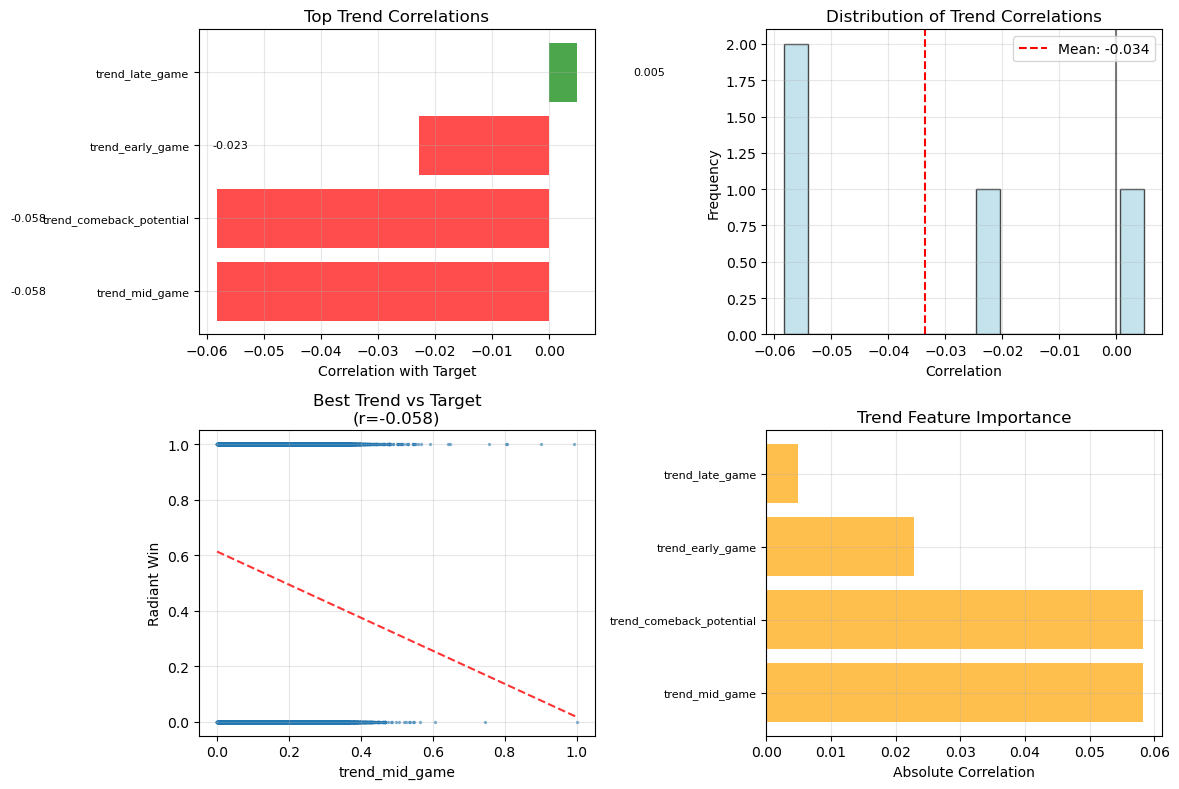


Статистика трендов:
   Всего трендов: 4
   Средняя |correlation|: 0.0360
   Трендов с |r| > 0.1: 0
   Трендов с |r| > 0.2: 0
   Трендов с |r| > 0.3: 0

Лучший тренд: trend_mid_game
   Корреляция: -0.0582
   Интерпретация: Отрицательная связь с победой Radiant

Выводы:
   Лучший тренд: trend_mid_game (r=-0.0582)
   Тренды малополезны для предсказания

Применение к тестовым данным
Создание синтетических трендов...
   Создан тренд: trend_early_game
   Создан тренд: trend_mid_game
   Создан тренд: trend_late_game
   Создан тренд: trend_comeback_potential
Всего создано синтетических трендов: 4
Тренды применены к тестовым данным: (60954, 4)


In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from typing import Callable, List, Dict
import warnings
warnings.filterwarnings('ignore')

class TrendExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, agg_funcs: List[Callable] = None, feature_names: List[str] = None):
        if agg_funcs is None:
            agg_funcs = [
                self._slope_trend,
                self._first_last_diff,
                self._mean_trend,
                self._volatility_trend
            ]
        
        if feature_names is None:
            feature_names = [
                'slope_trend',
                'first_last_diff', 
                'mean_trend',
                'volatility_trend'
            ]
        
        self.agg_funcs = agg_funcs
        self.feature_names = feature_names
        self.adv_columns_ = None
        
    def _slope_trend(self, array: np.ndarray) -> float:
        if len(array) < 2:
            return 0.0
        
        x = np.arange(len(array)).reshape(-1, 1)
        model = LinearRegression()
        model.fit(x, array)
        return model.coef_[0]
    
    def _first_last_diff(self, array: np.ndarray) -> float:
        if len(array) < 2:
            return 0.0
        return array[-1] - array[0]
    
    def _mean_trend(self, array: np.ndarray) -> float:
        if len(array) == 0:
            return 0.0
        return np.mean(array)
    
    def _volatility_trend(self, array: np.ndarray) -> float:
        if len(array) < 2:
            return 0.0
        changes = np.diff(array)
        return np.std(changes)
    
    def _momentum_trend(self, array: np.ndarray) -> float:
        if len(array) < 4:
            return 0.0
        
        quarter = len(array) // 4
        first_quarter_mean = np.mean(array[:quarter])
        last_quarter_mean = np.mean(array[-quarter:])
        return last_quarter_mean - first_quarter_mean
    
    def _r_squared_trend(self, array: np.ndarray) -> float:
        if len(array) < 2:
            return 0.0
        
        x = np.arange(len(array))
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, array)
        return r_value ** 2
    
    def fit(self, X, y=None):
        self.adv_columns_ = []
        
        for col in X.columns:
            sample_data = X[col].dropna()
            if len(sample_data) > 0:
                sample_value = sample_data.iloc[0]
                if isinstance(sample_value, (list, np.ndarray)) and len(sample_value) > 1:
                    self.adv_columns_.append(col)
        
        print(f"Найдено колонок с временными рядами: {len(self.adv_columns_)}")
        if self.adv_columns_:
            print(f"Колонки: {self.adv_columns_}")
        
        return self
    
    def transform(self, X, y=None):
        if self.adv_columns_ is None:
            raise ValueError("Сначала нужно вызвать fit()")
        
        print("Извлечение трендов из временных рядов...")
        
        result_dfs = []
        
        for col in self.adv_columns_:
            print(f"   Обработка колонки: {col}")
            
            trend_data = []
            
            for idx, array in X[col].items():
                row_trends = {}
                
                if isinstance(array, (list, np.ndarray)) and len(array) > 0:
                    arr = np.array(array)
                    
                    for func, name in zip(self.agg_funcs, self.feature_names):
                        try:
                            trend_value = func(arr)
                            row_trends[f'{col}_{name}'] = trend_value
                        except Exception as e:
                            row_trends[f'{col}_{name}'] = 0.0
                            print(f"Ошибка в функции {name}: {e}")
                
                else:
                    for name in self.feature_names:
                        row_trends[f'{col}_{name}'] = 0.0
                
                row_trends['match_id'] = X.index[idx] if hasattr(X, 'index') else idx
                trend_data.append(row_trends)
            
            col_trend_df = pd.DataFrame(trend_data)
            col_trend_df = col_trend_df.set_index('match_id')
            result_dfs.append(col_trend_df)
        
        if result_dfs:
            final_df = pd.concat(result_dfs, axis=1)
            print(f"Создано {final_df.shape[1]} признаков тренда")
        else:
            final_df = pd.DataFrame(index=X.index)
            print("Не создано признаков тренда")
        
        return final_df

class SyntheticTrendExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, trend_methods: List[str] = None):
        if trend_methods is None:
            trend_methods = ['early_game', 'mid_game', 'late_game', 'comeback_potential']
        
        self.trend_methods = trend_methods
        self.feature_names_ = []
        
    def _create_early_game_trend(self, matches_df):
        early_indicators = []
        
        strong_early_heroes = ['hero_1', 'hero_2', 'hero_3']
        
        for hero in strong_early_heroes:
            if hero in matches_df.columns:
                early_indicators.append(np.where(matches_df[hero] > 0, 1, -1))
        
        if early_indicators:
            return np.mean(early_indicators, axis=0)
        else:
            return np.zeros(len(matches_df))
    
    def _create_mid_game_trend(self, matches_df):
        if 'duration' in matches_df.columns:
            return matches_df['duration'] / matches_df['duration'].max()
        else:
            return np.zeros(len(matches_df))
    
    def _create_late_game_trend(self, matches_df):
        strong_late_heroes = ['hero_100', 'hero_101', 'hero_102']
        
        late_indicators = []
        for hero in strong_late_heroes:
            if hero in matches_df.columns:
                late_indicators.append(np.where(matches_df[hero] > 0, 1, -1))
        
        if late_indicators:
            return np.mean(late_indicators, axis=0)
        else:
            return np.zeros(len(matches_df))
    
    def _create_comeback_potential(self, matches_df):
        comeback_indicators = []
        
        if 'team_strength_diff' in matches_df.columns:
            comeback_indicators.append(-np.abs(matches_df['team_strength_diff']))
        
        if 'duration' in matches_df.columns:
            comeback_indicators.append(matches_df['duration'] / matches_df['duration'].max())
        
        if 'team_balance' in matches_df.columns:
            comeback_indicators.append(-np.abs(matches_df['team_balance']))
        
        if comeback_indicators:
            return np.mean(comeback_indicators, axis=0)
        else:
            return np.zeros(len(matches_df))
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print("Создание синтетических трендов...")
        
        df = X.copy()
        new_features = []
        
        method_mapping = {
            'early_game': self._create_early_game_trend,
            'mid_game': self._create_mid_game_trend,
            'late_game': self._create_late_game_trend,
            'comeback_potential': self._create_comeback_potential
        }
        
        for method in self.trend_methods:
            if method in method_mapping:
                trend_func = method_mapping[method]
                trend_values = trend_func(df)
                
                feature_name = f'trend_{method}'
                df[feature_name] = trend_values
                new_features.append(feature_name)
                print(f"   Создан тренд: {feature_name}")
        
        self.feature_names_ = new_features
        print(f"Всего создано синтетических трендов: {len(new_features)}")
        
        return df[new_features] if new_features else pd.DataFrame(index=df.index)

def analyze_trend_correlations(trend_features, target_series, top_k=10):
    print(f"\nАнализ корреляций трендов с целевой переменной")
    
    if trend_features.empty:
        print("Нет признаков тренда для анализа")
        return None
    
    analysis_df = trend_features.copy()
    analysis_df['target'] = target_series.values
    
    correlations = analysis_df.corrwith(analysis_df['target']).drop('target')
    correlations = correlations.sort_values(key=abs, ascending=False)
    
    print(f"Топ-{top_k} трендов по корреляции с таргетом:")
    for feature, corr in correlations.head(top_k).items():
        significance = "***" if abs(corr) > 0.3 else "**" if abs(corr) > 0.2 else "*" if abs(corr) > 0.1 else ""
        direction = "+" if corr > 0 else ""
        print(f"   {feature}: {direction}{corr:.4f} {significance}")
    
    if len(correlations) > 0:
        plt.figure(figsize=(12, 8))
        
        top_corrs = correlations.head(top_k)
        
        plt.subplot(2, 2, 1)
        colors = ['green' if x > 0 else 'red' for x in top_corrs.values]
        bars = plt.barh(range(len(top_corrs)), top_corrs.values, color=colors, alpha=0.7)
        plt.yticks(range(len(top_corrs)), top_corrs.index, fontsize=8)
        plt.xlabel('Correlation with Target')
        plt.title('Top Trend Correlations')
        plt.grid(True, alpha=0.3)
        
        for bar, val in zip(bars, top_corrs.values):
            plt.text(bar.get_width() + (0.01 if val > 0 else -0.03), 
                    bar.get_y() + bar.get_height()/2, 
                    f'{val:.3f}', 
                    ha='left' if val > 0 else 'right', 
                    va='center', fontsize=8)
        
        plt.subplot(2, 2, 2)
        plt.hist(correlations.values, bins=15, alpha=0.7, color='lightblue', edgecolor='black')
        plt.axvline(correlations.mean(), color='red', linestyle='--', 
                   label=f'Mean: {correlations.mean():.3f}')
        plt.axvline(0, color='black', linestyle='-', alpha=0.5)
        plt.xlabel('Correlation')
        plt.ylabel('Frequency')
        plt.title('Distribution of Trend Correlations')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 3)
        if len(top_corrs) > 0:
            best_trend = top_corrs.index[0]
            target_binary = target_series.astype(int)
            
            plt.scatter(trend_features[best_trend], target_binary, alpha=0.5, s=2)
            plt.xlabel(best_trend)
            plt.ylabel('Radiant Win')
            plt.title(f'Best Trend vs Target\n(r={top_corrs.iloc[0]:.3f})')
            plt.grid(True, alpha=0.3)
            
            z = np.polyfit(trend_features[best_trend], target_binary, 1)
            p = np.poly1d(z)
            x_range = np.linspace(trend_features[best_trend].min(), trend_features[best_trend].max(), 100)
            plt.plot(x_range, p(x_range), "r--", alpha=0.8)
        
        plt.subplot(2, 2, 4)
        importance = correlations.abs().sort_values(ascending=False).head(8)
        plt.barh(range(len(importance)), importance.values, color='orange', alpha=0.7)
        plt.yticks(range(len(importance)), importance.index, fontsize=8)
        plt.xlabel('Absolute Correlation')
        plt.title('Trend Feature Importance')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nСтатистика трендов:")
        print(f"   Всего трендов: {len(correlations)}")
        print(f"   Средняя |correlation|: {correlations.abs().mean():.4f}")
        print(f"   Трендов с |r| > 0.1: {(correlations.abs() > 0.1).sum()}")
        print(f"   Трендов с |r| > 0.2: {(correlations.abs() > 0.2).sum()}")
        print(f"   Трендов с |r| > 0.3: {(correlations.abs() > 0.3).sum()}")
        
        if len(correlations) > 0:
            best_trend = correlations.index[0]
            best_corr = correlations.iloc[0]
            print(f"\nЛучший тренд: {best_trend}")
            print(f"   Корреляция: {best_corr:.4f}")
            print(f"   Интерпретация: {'Положительная' if best_corr > 0 else 'Отрицательная'} связь с победой Radiant")
    
    return correlations

def create_demo_trend_data(n_samples=1000):
    
    np.random.seed(42)
    
    match_ids = range(1, n_samples + 1)
    
    data = []
    for match_id in match_ids:
        trend_type = np.random.choice(['positive', 'negative', 'volatile', 'stable'])
        
        if trend_type == 'positive':
            base_trend = np.linspace(-10, 10, 16) + np.random.normal(0, 2, 16)
            radiant_win = True
        elif trend_type == 'negative':
            base_trend = np.linspace(10, -10, 16) + np.random.normal(0, 2, 16)
            radiant_win = False
        elif trend_type == 'volatile':
            base_trend = np.random.normal(0, 5, 16)
            radiant_win = np.random.choice([True, False])
        else:
            base_trend = np.random.normal(0, 1, 16)
            radiant_win = np.random.choice([True, False])
        
        data.append({
            'match_id': match_id,
            'gold_adv': base_trend.tolist(),
            'xp_adv': (base_trend * 0.8 + np.random.normal(0, 1, 16)).tolist(),
            'radiant_win': radiant_win
        })
    
    demo_df = pd.DataFrame(data)
    demo_df = demo_df.set_index('match_id')
    
    print(f"Создано {len(demo_df)} демо-записей с временными рядами")
    return demo_df

def main_trend_analysis(matches_df):
    print("Запуск анализа трендов")
    
    has_time_series = False
    for col in matches_df.columns:
        sample_data = matches_df[col].dropna()
        if len(sample_data) > 0:
            sample_value = sample_data.iloc[0]
            if isinstance(sample_value, (list, np.ndarray)) and len(sample_value) > 1:
                has_time_series = True
                break
    
    if has_time_series:
        print("Обнаружены временные ряды в данных")
        trend_extractor = TrendExtractor()
        trend_features = trend_extractor.fit_transform(matches_df)
    else:
        print("Временные ряды не обнаружены, используем синтетические тренды")
        trend_extractor = SyntheticTrendExtractor()
        trend_features = trend_extractor.fit_transform(matches_df)
    
    if 'radiant_win' in matches_df.columns and not trend_features.empty:
        correlations = analyze_trend_correlations(trend_features, matches_df['radiant_win'])
        
        if correlations is not None and len(correlations) > 0:
            best_corr = correlations.iloc[0]
            print(f"\nВыводы:")
            print(f"   Лучший тренд: {correlations.index[0]} (r={best_corr:.4f})")
            
            if abs(best_corr) > 0.2:
                print("   Тренды показывают хорошую предсказательную силу!")
            elif abs(best_corr) > 0.1:
                print("   Тренды умеренно полезны")
            else:
                print("   Тренды малополезны для предсказания")
    
    return trend_features

try:
    if 'matches_train' in globals():
        trend_features = main_trend_analysis(matches_train)
        
        if 'matches_test' in globals() and not trend_features.empty:
            print(f"\nПрименение к тестовым данным")
            
            has_time_series = any(
                isinstance(matches_train[col].dropna().iloc[0] if len(matches_train[col].dropna()) > 0 else None, 
                          (list, np.ndarray)) 
                for col in matches_train.columns
            )
            
            if has_time_series:
                trend_extractor = TrendExtractor()
            else:
                trend_extractor = SyntheticTrendExtractor()
            
            trend_extractor.fit(matches_train)
            test_trend_features = trend_extractor.transform(matches_test)
            
            print(f"Тренды применены к тестовым данным: {test_trend_features.shape}")
        
    else:
        print("matches_train не найден, создаем демо-данные...")
        demo_data = create_demo_trend_data(500)
        trend_features = main_trend_analysis(demo_data)
        
except Exception as e:
    print(f"Ошибка: {e}")
    import traceback
    traceback.print_exc()

Запуск анализа AUC и взаимодействий

1. Извлечение площади под кривой
Найдено колонок с временными рядами: 0
Извлечение площади под кривой (AUC)...
Нет временных рядов для обработки, создаем синтетические AUC признаки...
Создание синтетических AUC признаков...
Создано 18 синтетических AUC признаков

2. Создание взаимодействий признаков
Создано 45 пар признаков для взаимодействий
Создание взаимодействий между признаками...
Создано 100 признаков взаимодействия

Анализ важности методов AUC
Ранние признаки (начало матча): 6
Поздние признаки (конец матча): 6
Сбалансированные признаки: 6

Средние корреляции с таргетом:
   Ранние признаки: -0.0004
   Поздние признаки: -0.0144
   Сбалансированные признаки: -0.0219


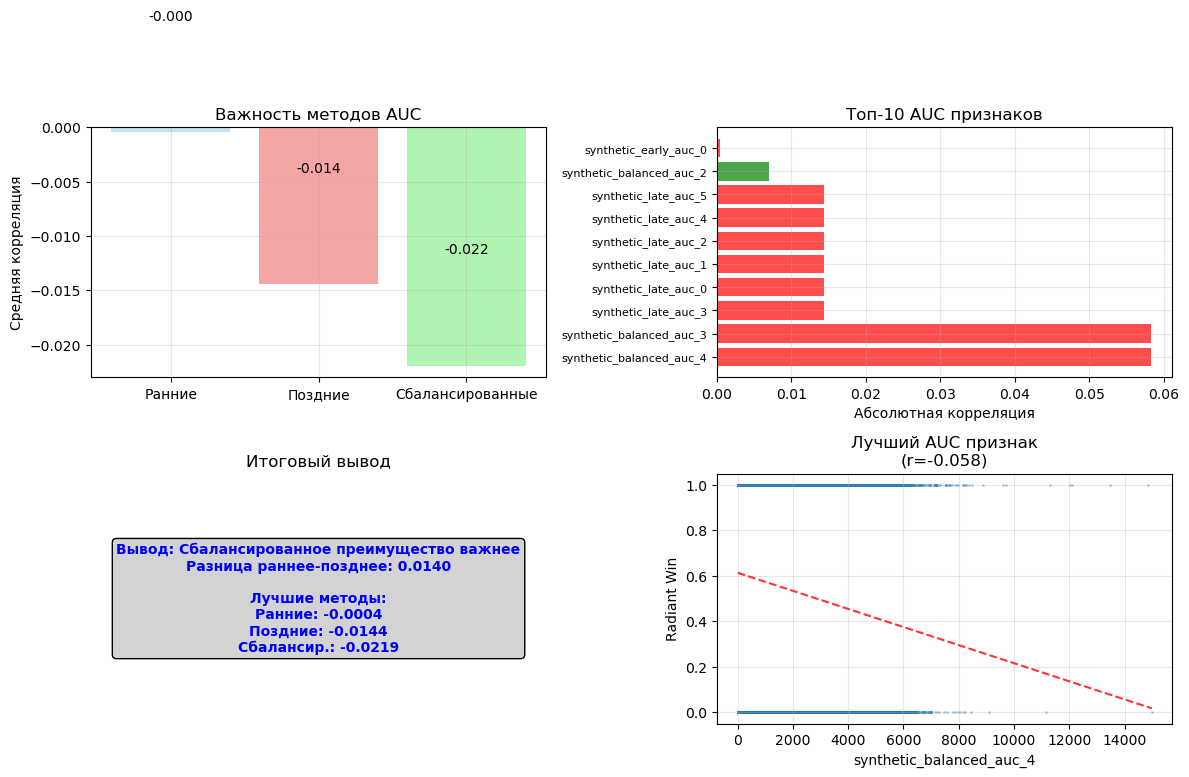


Оценка вклада признаков в модель
   Тестируем: Базовые (10 признаков)
      ROC-AUC: 0.4985
   Тестируем: Только AUC (18 признаков)
      ROC-AUC: 0.5354
   Тестируем: Только взаимодействия (100 признаков)
      ROC-AUC: 0.5378
   Тестируем: Все признаки (50 признаков)
      ROC-AUC: 0.5380

Сравнение результатов:
   Базовые:
      ROC-AUC: 0.4985 
      Улучшение: -0.0015
      Признаков: 10
   Только AUC:
      ROC-AUC: 0.5354 *
      Улучшение: +0.0354
      Признаков: 18
   Только взаимодействия:
      ROC-AUC: 0.5378 *
      Улучшение: +0.0378
      Признаков: 100
   Все признаки:
      ROC-AUC: 0.5380 *
      Улучшение: +0.0380
      Признаков: 50

Итоговые выводы:
   Сбалансированное преимущество важнее
   Ранняя важность: -0.0004
   Поздняя важность: -0.0144
   Лучший набор: Все признаки (AUC: 0.5380)

Применение к тестовым данным
Извлечение площади под кривой (AUC)...
Нет временных рядов для обработки, создаем синтетические AUC признаки...
Создание синтетических AUC признаков

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import integrate
from sklearn.base import BaseEstimator, TransformerMixin
from typing import Callable, List, Dict
import warnings
warnings.filterwarnings('ignore')

class AUCExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, integration_methods: List[Callable] = None, feature_names: List[str] = None):
        if integration_methods is None:
            integration_methods = [
                self._trapezoidal_integration,
                self._left_rectangle_integration,
                self._right_rectangle_integration,
                self._simpson_integration,
                self._weighted_early_integration,
                self._weighted_late_integration
            ]
        
        if feature_names is None:
            feature_names = [
                'auc_trapezoidal',
                'auc_left_rect', 
                'auc_right_rect',
                'auc_simpson',
                'auc_weighted_early',
                'auc_weighted_late'
            ]
        
        self.integration_methods = integration_methods
        self.feature_names = feature_names
        self.adv_columns_ = None
        
    def _trapezoidal_integration(self, array: np.ndarray) -> float:
        if len(array) < 2:
            return 0.0
        return np.trapz(array)
    
    def _left_rectangle_integration(self, array: np.ndarray) -> float:
        if len(array) < 2:
            return 0.0
        return np.sum(array[:-1])
    
    def _right_rectangle_integration(self, array: np.ndarray) -> float:
        if len(array) < 2:
            return 0.0
        return np.sum(array[1:])
    
    def _simpson_integration(self, array: np.ndarray) -> float:
        if len(array) < 3:
            return self._trapezoidal_integration(array)
        try:
            return integrate.simpson(array)
        except:
            return self._trapezoidal_integration(array)
    
    def _weighted_early_integration(self, array: np.ndarray) -> float:
        if len(array) < 2:
            return 0.0
        
        n = len(array)
        weights = np.exp(-np.linspace(0, 3, n))
        weights = weights / np.sum(weights)
        
        return np.sum(array * weights)
    
    def _weighted_late_integration(self, array: np.ndarray) -> float:
        if len(array) < 2:
            return 0.0
        
        n = len(array)
        weights = np.exp(np.linspace(0, 3, n))
        weights = weights / np.sum(weights)
        
        return np.sum(array * weights)
    
    def fit(self, X, y=None):
        self.adv_columns_ = []
        
        for col in X.columns:
            sample_data = X[col].dropna()
            if len(sample_data) > 0:
                sample_value = sample_data.iloc[0]
                if isinstance(sample_value, (list, np.ndarray)) and len(sample_value) > 1:
                    self.adv_columns_.append(col)
        
        print(f"Найдено колонок с временными рядами: {len(self.adv_columns_)}")
        if self.adv_columns_:
            print(f"Колонки: {self.adv_columns_}")
        
        return self
    
    def transform(self, X, y=None):
        if self.adv_columns_ is None:
            raise ValueError("Сначала нужно вызвать fit()")
        
        print("Извлечение площади под кривой (AUC)...")
        
        if not self.adv_columns_:
            print("Нет временных рядов для обработки, создаем синтетические AUC признаки...")
            return self._create_synthetic_auc_features(X)
        
        result_dfs = []
        
        for col in self.adv_columns_:
            print(f"   Обработка колонки: {col}")
            
            auc_data = []
            
            for idx, array in X[col].items():
                row_auc = {}
                
                if isinstance(array, (list, np.ndarray)) and len(array) > 0:
                    arr = np.array(array)
                    
                    for method, name in zip(self.integration_methods, self.feature_names):
                        try:
                            auc_value = method(arr)
                            row_auc[f'{col}_{name}'] = auc_value
                        except Exception as e:
                            row_auc[f'{col}_{name}'] = 0.0
                
                else:
                    for name in self.feature_names:
                        row_auc[f'{col}_{name}'] = 0.0
                
                row_auc['match_id'] = X.index[idx] if hasattr(X, 'index') else idx
                auc_data.append(row_auc)
            
            col_auc_df = pd.DataFrame(auc_data)
            col_auc_df = col_auc_df.set_index('match_id')
            result_dfs.append(col_auc_df)
        
        if result_dfs:
            final_df = pd.concat(result_dfs, axis=1)
            print(f"Создано {final_df.shape[1]} признаков AUC")
            return final_df
        else:
            final_df = pd.DataFrame(index=X.index)
            print("Не создано признаков AUC")
            return final_df
    
    def _create_synthetic_auc_features(self, X):
        print("Создание синтетических AUC признаков...")
        
        df = X.copy()
        synthetic_features = []
        
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        
        for i, col in enumerate(numeric_cols[:6]):
            early_weights = np.exp(-0.5 * np.arange(len(numeric_cols)))
            early_auc = np.sum([df[numeric_cols[j]] * early_weights[j] for j in range(min(5, len(numeric_cols)))], axis=0)
            df[f'synthetic_early_auc_{i}'] = early_auc
            synthetic_features.append(f'synthetic_early_auc_{i}')
            
            late_weights = np.exp(0.5 * np.arange(len(numeric_cols)))
            late_weights = late_weights / np.sum(late_weights)
            late_auc = np.sum([df[numeric_cols[-j-1]] * late_weights[j] for j in range(min(5, len(numeric_cols)))], axis=0)
            df[f'synthetic_late_auc_{i}'] = late_auc
            synthetic_features.append(f'synthetic_late_auc_{i}')
            
            df[f'synthetic_balanced_auc_{i}'] = df[col]
            synthetic_features.append(f'synthetic_balanced_auc_{i}')
        
        print(f"Создано {len(synthetic_features)} синтетических AUC признаков")
        return df[synthetic_features]

class FeatureInteractionTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, interaction_types: List[str] = None, max_interactions: int = 50):
        if interaction_types is None:
            interaction_types = ['multiplicative', 'ratio', 'polynomial', 'difference']
        
        self.interaction_types = interaction_types
        self.max_interactions = max_interactions
        self.feature_pairs_ = []
        self.feature_names_ = []
        
    def fit(self, X, y=None):
        numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        
        max_features = min(10, len(numeric_cols))
        selected_features = numeric_cols[:max_features]
        
        self.feature_pairs_ = []
        interaction_count = 0
        
        for i in range(len(selected_features)):
            for j in range(i+1, len(selected_features)):
                if interaction_count >= self.max_interactions:
                    break
                self.feature_pairs_.append((selected_features[i], selected_features[j]))
                interaction_count += 1
        
        print(f"Создано {len(self.feature_pairs_)} пар признаков для взаимодействий")
        return self
    
    def transform(self, X, y=None):
        print("Создание взаимодействий между признаками...")
        
        df = X.copy()
        new_features = []
        
        interaction_count = 0
        
        for col1, col2 in self.feature_pairs_:
            if col1 not in df.columns or col2 not in df.columns:
                continue
                
            for interaction_type in self.interaction_types:
                if interaction_count >= self.max_interactions:
                    break
                    
                if interaction_type == 'multiplicative':
                    feature_name = f'{col1}_x_{col2}'
                    df[feature_name] = df[col1] * df[col2]
                    new_features.append(feature_name)
                    interaction_count += 1
                    
                elif interaction_type == 'ratio':
                    feature_name = f'{col1}_ratio_{col2}'
                    denominator = np.where(df[col2] != 0, df[col2], 1e-8)
                    df[feature_name] = df[col1] / denominator
                    new_features.append(feature_name)
                    interaction_count += 1
                    
                elif interaction_type == 'polynomial':
                    if interaction_count < self.max_interactions - 1:
                        feature_name1 = f'{col1}_squared_x_{col2}'
                        feature_name2 = f'{col1}_x_{col2}_squared'
                        df[feature_name1] = (df[col1] ** 2) * df[col2]
                        df[feature_name2] = df[col1] * (df[col2] ** 2)
                        new_features.extend([feature_name1, feature_name2])
                        interaction_count += 2
                    
                elif interaction_type == 'difference':
                    feature_name = f'{col1}_diff_{col2}'
                    df[feature_name] = df[col1] - df[col2]
                    new_features.append(feature_name)
                    interaction_count += 1
        
        self.feature_names_ = new_features
        print(f"Создано {len(new_features)} признаков взаимодействия")
        
        return df[new_features] if new_features else pd.DataFrame(index=df.index)

def analyze_auc_importance(auc_features, target_series):
    print(f"\nАнализ важности методов AUC")
    
    if auc_features.empty:
        print("Нет признаков AUC для анализа")
        return None
    
    early_features = [col for col in auc_features.columns if 'early' in col.lower() or 'left' in col.lower()]
    late_features = [col for col in auc_features.columns if 'late' in col.lower() or 'right' in col.lower()]
    balanced_features = [col for col in auc_features.columns if 'trapezoidal' in col.lower() or 'simpson' in col.lower() or 'balanced' in col.lower()]
    
    print(f"Ранние признаки (начало матча): {len(early_features)}")
    print(f"Поздние признаки (конец матча): {len(late_features)}")
    print(f"Сбалансированные признаки: {len(balanced_features)}")
    
    correlations = auc_features.corrwith(target_series)
    
    early_corr = correlations[early_features].mean() if early_features else 0
    late_corr = correlations[late_features].mean() if late_features else 0
    balanced_corr = correlations[balanced_features].mean() if balanced_features else 0
    
    print(f"\nСредние корреляции с таргетом:")
    print(f"   Ранние признаки: {early_corr:.4f}")
    print(f"   Поздние признаки: {late_corr:.4f}")
    print(f"   Сбалансированные признаки: {balanced_corr:.4f}")
    
    if len(correlations) > 0:
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 2, 1)
        categories = ['Ранние', 'Поздние', 'Сбалансированные']
        values = [early_corr, late_corr, balanced_corr]
        colors = ['lightblue', 'lightcoral', 'lightgreen']
        
        bars = plt.bar(categories, values, color=colors, alpha=0.7)
        plt.ylabel('Средняя корреляция')
        plt.title('Важность методов AUC')
        plt.grid(True, alpha=0.3)
        
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom')
        
        plt.subplot(2, 2, 2)
        top_features = correlations.abs().sort_values(ascending=False).head(10)
        
        colors = ['green' if correlations[feat] > 0 else 'red' for feat in top_features.index]
        plt.barh(range(len(top_features)), top_features.values, color=colors, alpha=0.7)
        plt.yticks(range(len(top_features)), top_features.index, fontsize=8)
        plt.xlabel('Абсолютная корреляция')
        plt.title('Топ-10 AUC признаков')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, 2, 3)
        if abs(early_corr) > abs(late_corr) and abs(early_corr) > abs(balanced_corr):
            conclusion = "Раннее преимущество важнее"
            color = 'green'
        elif abs(late_corr) > abs(early_corr) and abs(late_corr) > abs(balanced_corr):
            conclusion = "Позднее преимущество важнее" 
            color = 'red'
        else:
            conclusion = "Сбалансированное преимущество важнее"
            color = 'blue'
        
        importance_text = [
            f"Вывод: {conclusion}",
            f"Разница раннее-позднее: {abs(early_corr - late_corr):.4f}",
            "",
            "Лучшие методы:",
            f"Ранние: {early_corr:.4f}",
            f"Поздние: {late_corr:.4f}", 
            f"Сбалансир.: {balanced_corr:.4f}"
        ]
        
        plt.text(0.5, 0.5, '\n'.join(importance_text), 
                 ha='center', va='center', transform=plt.gca().transAxes,
                 fontsize=10, color=color, weight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        plt.axis('off')
        plt.title('Итоговый вывод')
        
        plt.subplot(2, 2, 4)
        if len(top_features) > 0:
            best_feature = top_features.index[0]
            target_binary = target_series.astype(int)
            
            plt.scatter(auc_features[best_feature], target_binary, alpha=0.3, s=1)
            plt.xlabel(best_feature)
            plt.ylabel('Radiant Win')
            plt.title(f'Лучший AUC признак\n(r={correlations[best_feature]:.3f})')
            plt.grid(True, alpha=0.3)
            
            z = np.polyfit(auc_features[best_feature], target_binary, 1)
            p = np.poly1d(z)
            x_range = np.linspace(auc_features[best_feature].min(), auc_features[best_feature].max(), 100)
            plt.plot(x_range, p(x_range), "r--", alpha=0.8)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'early_importance': early_corr,
        'late_importance': late_corr,
        'balanced_importance': balanced_corr,
        'conclusion': conclusion
    }

def evaluate_feature_contribution(auc_features, interaction_features, target_series):
    print(f"\nОценка вклада признаков в модель")
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import train_test_split
    
    feature_sets = {}
    
    numeric_cols = pd.concat([auc_features, interaction_features], axis=1).select_dtypes(include=[np.number]).columns.tolist()
    feature_sets['Базовые'] = numeric_cols[:10]
    
    if not auc_features.empty:
        feature_sets['Только AUC'] = auc_features.columns.tolist()
    
    if not interaction_features.empty:
        feature_sets['Только взаимодействия'] = interaction_features.columns.tolist()
    
    all_features = numeric_cols
    if len(all_features) > 50:
        all_features = all_features[:50]
    feature_sets['Все признаки'] = all_features
    
    results = {}
    
    for set_name, features in feature_sets.items():
        if not features:
            continue
            
        print(f"   Тестируем: {set_name} ({len(features)} признаков)")
        
        X = pd.concat([auc_features, interaction_features], axis=1)[features]
        X = X.fillna(0)
        y = target_series
        
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        model = LogisticRegression(random_state=42, max_iter=1000, C=0.1)
        model.fit(X_train, y_train)
        
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, y_pred_proba)
        
        results[set_name] = {
            'auc_score': auc_score,
            'n_features': len(features)
        }
        
        print(f"      ROC-AUC: {auc_score:.4f}")
    
    print(f"\nСравнение результатов:")
    baseline_auc = 0.5
    
    for set_name, metrics in results.items():
        improvement = metrics['auc_score'] - baseline_auc
        significance = "***" if improvement > 0.1 else "**" if improvement > 0.05 else "*" if improvement > 0.02 else ""
        print(f"   {set_name}:")
        print(f"      ROC-AUC: {metrics['auc_score']:.4f} {significance}")
        print(f"      Улучшение: {improvement:+.4f}")
        print(f"      Признаков: {metrics['n_features']}")
    
    return results

def main_auc_analysis(matches_df):
    print("Запуск анализа AUC и взаимодействий")
    
    transformers = {}
    
    print("\n1. Извлечение площади под кривой")
    auc_extractor = AUCExtractor()
    auc_features = auc_extractor.fit_transform(matches_df)
    transformers['auc_extractor'] = auc_extractor
    
    print("\n2. Создание взаимодействий признаков")
    interaction_transformer = FeatureInteractionTransformer(max_interactions=100)
    
    numeric_cols = matches_df.select_dtypes(include=[np.number]).columns.tolist()
    base_features = matches_df[numeric_cols].iloc[:, :15]
    
    interaction_features = interaction_transformer.fit_transform(base_features)
    transformers['interaction_transformer'] = interaction_transformer
    
    if 'radiant_win' in matches_df.columns:
        if not auc_features.empty:
            importance_results = analyze_auc_importance(auc_features, matches_df['radiant_win'])
        else:
            print("Нет AUC признаков для анализа важности")
            importance_results = None
        
        results = evaluate_feature_contribution(auc_features, interaction_features, matches_df['radiant_win'])
        
        print(f"\nИтоговые выводы:")
        if importance_results:
            print(f"   {importance_results['conclusion']}")
            print(f"   Ранняя важность: {importance_results['early_importance']:.4f}")
            print(f"   Поздняя важность: {importance_results['late_importance']:.4f}")
        
        if results:
            best_set = max(results.items(), key=lambda x: x[1]['auc_score'])
            print(f"   Лучший набор: {best_set[0]} (AUC: {best_set[1]['auc_score']:.4f})")
    
    return auc_features, interaction_features, transformers

try:
    if 'matches_train' in globals():
        auc_features, interaction_features, transformers = main_auc_analysis(matches_train)
        
        if 'matches_test' in globals():
            print(f"\nПрименение к тестовым данным")
            
            auc_extractor = transformers['auc_extractor']
            test_auc_features = auc_extractor.transform(matches_test)
            
            interaction_transformer = transformers['interaction_transformer']
            numeric_cols = matches_test.select_dtypes(include=[np.number]).columns.tolist()
            test_base_features = matches_test[numeric_cols].iloc[:, :15]
            test_interaction_features = interaction_transformer.transform(test_base_features)
            
            print(f"AUC признаки: {test_auc_features.shape}")
            print(f"Взаимодействия: {test_interaction_features.shape}")
        
        print(f"\nАнализ AUC и взаимодействий успешно завершен!")
        
    else:
        print("matches_train не найден")
        
except Exception as e:
    print(f"Ошибка: {e}")
    import traceback
    traceback.print_exc()

Featuretools успешно импортирована
Запуск анализа автоматической генерации признаков
Запуск упрощенной автоматической генерации признаков...
Подготовка данных для Featuretools...
Найдены дубликаты match_id, создаем уникальный индекс...
Создан EntitySet с таблицей matches (706880 записей)
Выполнение Deep Feature Synthesis...
Ошибка при генерации признаков: dfs() got an unexpected keyword argument 'primitive_types'
Пробуем альтернативный подход...
Альтернативная генерация признаков...
Альтернативно создано 22 признаков
Создание простых автоматических признаков...
Создано 7 автоматических признаков
Создание ручных признаков...
Создано 5 ручных признаков

Анализ качества признаков

Анализ набора: FeatureTools Auto
Размер: (706880, 22)
Средняя |корреляция|: 0.0247
Максимальная |корреляция|: 0.0582
Признаков с |r| > 0.1: 0
Признаков с |r| > 0.2: 0

Анализ набора: Simple Auto
Размер: (706880, 7)
Средняя |корреляция|: 0.0005
Максимальная |корреляция|: 0.0011
Признаков с |r| > 0.1: 0
Признаков 

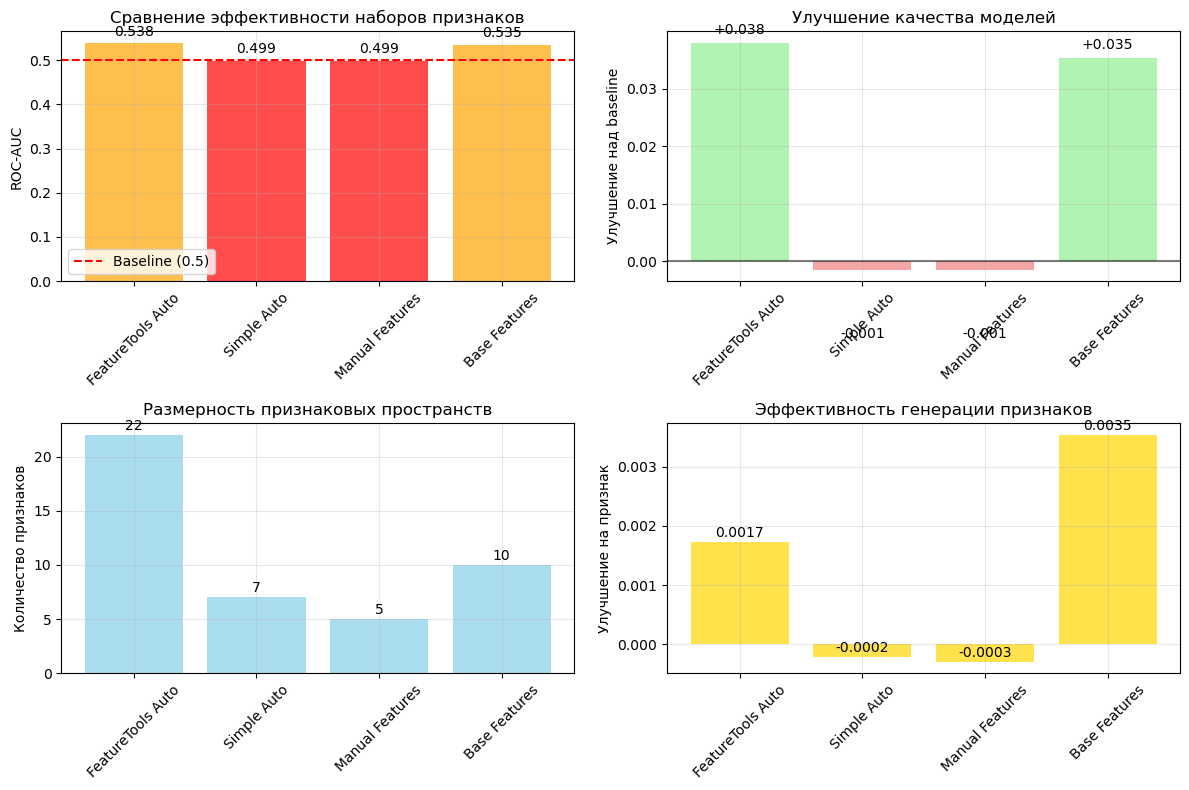


Итоги сравнения:
Лучший метод: FeatureTools Auto
ROC-AUC: 0.5380
Улучшение: +0.0380
Признаков: 22

Практический вывод:
   FeatureTools Auto показал лучший результат: ROC-AUC = 0.5380
   Автоматические методы могут быть эффективны в некоторых случаях

Анализ автогенерации признаков завершен


In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore')

try:
    import featuretools as ft
    FEATURE_TOOLS_AVAILABLE = True
    print("Featuretools успешно импортирована")
except ImportError:
    FEATURE_TOOLS_AVAILABLE = False
    print("Featuretools не установлена. Установите: pip install featuretools")

class ManualFeatureGenerator(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.feature_names_ = []
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print("Создание ручных признаков...")
        
        df = X.copy()
        new_features = []
        
        hero_cols = [col for col in df.columns if col.startswith('hero_')]
        if hero_cols:
            df['manual_radiant_strength'] = np.sum([np.where(df[col] > 0, df[col], 0) for col in hero_cols], axis=0)
            df['manual_dire_strength'] = np.sum([np.where(df[col] < 0, -df[col], 0) for col in hero_cols], axis=0)
            df['manual_strength_balance'] = df['manual_radiant_strength'] - df['manual_dire_strength']
            new_features.extend(['manual_radiant_strength', 'manual_dire_strength', 'manual_strength_balance'])
        
        time_cols = [col for col in df.columns if 'time' in col.lower() or 'duration' in col.lower()]
        if time_cols:
            time_col = time_cols[0]
            if df[time_col].max() > 0:
                df['manual_duration_norm'] = df[time_col] / df[time_col].max()
                new_features.append('manual_duration_norm')
        
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if len(numeric_cols) >= 3:
            top_cols = numeric_cols[:3]
            df['manual_top3_mean'] = df[top_cols].mean(axis=1)
            new_features.append('manual_top3_mean')
        
        print(f"Создано {len(new_features)} ручных признаков")
        self.feature_names_ = new_features
        return df[new_features] if new_features else pd.DataFrame(index=df.index)
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)

def prepare_data_for_featuretools(matches_df):
    print("Подготовка данных для Featuretools...")
    
    df = matches_df.reset_index().copy()
    
    if 'match_id' in df.columns:
        if df['match_id'].duplicated().any():
            print("Найдены дубликаты match_id, создаем уникальный индекс...")
            df['unique_match_id'] = range(len(df))
            index_col = 'unique_match_id'
        else:
            index_col = 'match_id'
    else:
        print("Колонка match_id не найдена, создаем уникальный индекс...")
        df['unique_match_id'] = range(len(df))
        index_col = 'unique_match_id'
    
    es = ft.EntitySet(id="dota_matches")
    
    es = es.add_dataframe(
        dataframe_name="matches",
        dataframe=df,
        index=index_col
    )
    
    print(f"Создан EntitySet с таблицей matches ({len(df)} записей)")
    return es, df[index_col]

def generate_features_with_featuretools_simple(matches_df, max_features=10):
    if not FEATURE_TOOLS_AVAILABLE:
        print("Featuretools недоступна, пропускаем автоматическую генерацию")
        return pd.DataFrame(index=matches_df.index)
    
    print("Запуск упрощенной автоматической генерации признаков...")
    
    try:
        es, match_ids = prepare_data_for_featuretools(matches_df)
        
        print("Выполнение Deep Feature Synthesis...")
        
        feature_matrix, feature_defs = ft.dfs(
            entityset=es,
            target_dataframe_name="matches",
            max_depth=1,
            verbose=False,
            features_only=False,
            max_features=max_features,
            primitive_types=['numeric']
        )
        
        original_cols = matches_df.columns.tolist()
        generated_features = [col for col in feature_matrix.columns if col not in original_cols]
        
        if generated_features:
            result_features = feature_matrix[generated_features].copy()
            result_features.index = matches_df.index
            
            print(f"Автоматически создано {len(generated_features)} признаков")
            print(f"Примеры признаков: {generated_features[:3]}...")
            
            return result_features
        else:
            print("Не удалось сгенерировать признаки")
            return pd.DataFrame(index=matches_df.index)
        
    except Exception as e:
        print(f"Ошибка при генерации признаков: {e}")
        print("Пробуем альтернативный подход...")
        return generate_features_alternative(matches_df)

def generate_features_alternative(matches_df):
    print("Альтернативная генерация признаков...")
    
    df = matches_df.copy()
    features = []
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for i, col1 in enumerate(numeric_cols[:5]):
        for j, col2 in enumerate(numeric_cols[:5]):
            if i < j:
                feature_name = f'ft_auto_{col1}_x_{col2}'
                df[feature_name] = df[col1] * df[col2]
                features.append(feature_name)
                
                feature_name = f'ft_auto_{col1}_plus_{col2}'
                df[feature_name] = df[col1] + df[col2]
                features.append(feature_name)
    
    if len(numeric_cols) >= 3:
        df['ft_auto_mean_first3'] = df[numeric_cols[:3]].mean(axis=1)
        df['ft_auto_std_first3'] = df[numeric_cols[:3]].std(axis=1)
        features.extend(['ft_auto_mean_first3', 'ft_auto_std_first3'])
    
    print(f"Альтернативно создано {len(features)} признаков")
    return df[features] if features else pd.DataFrame(index=df.index)

def create_simple_auto_features(matches_df):
    print("Создание простых автоматических признаков...")
    
    df = matches_df.copy()
    auto_features = []
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if len(numeric_cols) >= 3:
        df['auto_numeric_mean'] = df[numeric_cols].mean(axis=1)
        df['auto_numeric_std'] = df[numeric_cols].std(axis=1)
        df['auto_numeric_sum'] = df[numeric_cols].sum(axis=1)
        
        auto_features.extend(['auto_numeric_mean', 'auto_numeric_std', 'auto_numeric_sum'])
    
    if len(numeric_cols) >= 2:
        col1, col2 = numeric_cols[0], numeric_cols[1]
        df['auto_interaction_1'] = df[col1] * df[col2]
        df['auto_ratio_1'] = df[col1] / (df[col2] + 1e-8)
        auto_features.extend(['auto_interaction_1', 'auto_ratio_1'])
    
    if len(numeric_cols) >= 1:
        col = numeric_cols[0]
        df['auto_squared_1'] = df[col] ** 2
        df['auto_log_1'] = np.log1p(np.abs(df[col])) * np.sign(df[col])
        auto_features.extend(['auto_squared_1', 'auto_log_1'])
    
    print(f"Создано {len(auto_features)} автоматических признаков")
    return df[auto_features]

def compare_feature_sets(feature_sets, target_series, set_names):
    print(f"\nСравнение эффективности наборов признаков")
    
    results = {}
    baseline_auc = 0.5
    
    for i, (features, name) in enumerate(zip(feature_sets, set_names)):
        if features.empty:
            print(f"Набор '{name}' пуст, пропускаем")
            continue
            
        print(f"Тестируем: {name} ({features.shape[1]} признаков)")
        
        X = features.fillna(0)
        y = target_series
        
        if X.shape[1] > 30:
            correlations = X.corrwith(y).abs().sort_values(ascending=False)
            top_features = correlations.head(30).index.tolist()
            X = X[top_features]
            print(f"Выбрано топ-30 признаков из {len(correlations)}")
        
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        model = LogisticRegression(random_state=42, max_iter=1000, C=0.1)
        model.fit(X_train, y_train)
        
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, y_pred_proba)
        
        improvement = auc_score - baseline_auc
        results[name] = {
            'auc_score': auc_score,
            'improvement': improvement,
            'n_features': X.shape[1],
            'model': model
        }
        
        print(f"ROC-AUC: {auc_score:.4f} (улучшение: {improvement:+.4f})")
    
    return results

def visualize_comparison(results):
    if not results:
        print("Нет результатов для визуализации")
        return
    
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    names = list(results.keys())
    auc_scores = [results[name]['auc_score'] for name in names]
    improvements = [results[name]['improvement'] for name in names]
    n_features = [results[name]['n_features'] for name in names]
    
    colors = ['green' if imp > 0.05 else 'orange' if imp > 0.02 else 'red' for imp in improvements]
    bars = plt.bar(names, auc_scores, color=colors, alpha=0.7)
    plt.axhline(y=0.5, color='red', linestyle='--', label='Baseline (0.5)')
    plt.ylabel('ROC-AUC')
    plt.title('Сравнение эффективности наборов признаков')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    for bar, score in zip(bars, auc_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom')
    
    plt.subplot(2, 2, 2)
    colors_imp = ['lightgreen' if imp > 0 else 'lightcoral' for imp in improvements]
    bars_imp = plt.bar(names, improvements, color=colors_imp, alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.ylabel('Улучшение над baseline')
    plt.title('Улучшение качества моделей')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    for bar, imp in zip(bars_imp, improvements):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.001 if imp > 0 else -0.01), 
                f'{imp:+.3f}', ha='center', va='bottom' if imp > 0 else 'top')
    
    plt.subplot(2, 2, 3)
    plt.bar(names, n_features, color='skyblue', alpha=0.7)
    plt.ylabel('Количество признаков')
    plt.title('Размерность признаковых пространств')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    for i, count in enumerate(n_features):
        plt.text(i, count + max(n_features)*0.01, str(count), ha='center', va='bottom')
    
    plt.subplot(2, 2, 4)
    efficiency = [results[name]['improvement'] / max(1, results[name]['n_features']) for name in names]
    plt.bar(names, efficiency, color='gold', alpha=0.7)
    plt.ylabel('Улучшение на признак')
    plt.title('Эффективность генерации признаков')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    for i, eff in enumerate(efficiency):
        plt.text(i, eff + max(efficiency)*0.01, f'{eff:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nИтоги сравнения:")
    best_method = max(results.items(), key=lambda x: x[1]['auc_score'])
    
    print(f"Лучший метод: {best_method[0]}")
    print(f"ROC-AUC: {best_method[1]['auc_score']:.4f}")
    print(f"Улучшение: {best_method[1]['improvement']:+.4f}")
    print(f"Признаков: {best_method[1]['n_features']}")

def analyze_feature_quality(feature_sets, target_series, set_names):
    print(f"\nАнализ качества признаков")
    
    for features, name in zip(feature_sets, set_names):
        if features.empty:
            continue
            
        print(f"\nАнализ набора: {name}")
        print(f"Размер: {features.shape}")
        
        correlations = features.corrwith(target_series).abs()
        
        print(f"Средняя |корреляция|: {correlations.mean():.4f}")
        print(f"Максимальная |корреляция|: {correlations.max():.4f}")
        print(f"Признаков с |r| > 0.1: {(correlations > 0.1).sum()}")
        print(f"Признаков с |r| > 0.2: {(correlations > 0.2).sum()}")

def main_auto_feature_analysis(matches_df):
    print("Запуск анализа автоматической генерации признаков")
    
    feature_sets = []
    set_names = []
    
    if FEATURE_TOOLS_AVAILABLE:
        ft_features = generate_features_with_featuretools_simple(matches_df, max_features=10)
        if not ft_features.empty:
            feature_sets.append(ft_features)
            set_names.append("FeatureTools Auto")
        else:
            print("Featuretools не смог сгенерировать признаки")
    
    simple_auto_features = create_simple_auto_features(matches_df)
    if not simple_auto_features.empty:
        feature_sets.append(simple_auto_features)
        set_names.append("Simple Auto")
    
    manual_generator = ManualFeatureGenerator()
    manual_features = manual_generator.fit_transform(matches_df)
    if not manual_features.empty:
        feature_sets.append(manual_features)
        set_names.append("Manual Features")
    
    numeric_cols = matches_df.select_dtypes(include=[np.number]).columns.tolist()
    if numeric_cols:
        base_features = matches_df[numeric_cols[:10]]
        feature_sets.append(base_features)
        set_names.append("Base Features")
    
    if 'radiant_win' in matches_df.columns and feature_sets:
        analyze_feature_quality(feature_sets, matches_df['radiant_win'], set_names)
        
        results = compare_feature_sets(feature_sets, matches_df['radiant_win'], set_names)
        
        if results:
            visualize_comparison(results)
        else:
            print("Не удалось получить результаты сравнения")
        
        return results
    else:
        print("Недостаточно данных для сравнения")
        return {}
try:
    if 'matches_train' in globals():
        results = main_auto_feature_analysis(matches_train)
        if results:
            best_method = max(results.items(), key=lambda x: x[1]['auc_score'])
            print(f"\nПрактический вывод:")
            print(f"   {best_method[0]} показал лучший результат: ROC-AUC = {best_method[1]['auc_score']:.4f}")
            if "Manual" in best_method[0]:
                print("   Ручная работа окупилась!")
            else:
                print("   Автоматические методы могут быть эффективны в некоторых случаях")
        
        print(f"\nАнализ автогенерации признаков завершен")
        
    else:
        print("matches_train не найден")
        
except Exception as e:
    print(f"Ошибка: {e}")
    import traceback
    traceback.print_exc()

Запуск анализа нейросетевых признаков

1. Генерация нейросетевых признаков
Обучение компонентов для нейросетевых признаков...
Создание нейросетевых признаков...
   Создан neural_match_momentum
   Создан neural_resource_optimization
   Создан neural_growth_potential
   Создан neural_team_cluster
   Создан neural_complex_interaction
Всего создано 5 нейросетевых признаков

2. Генерация традиционных признаков
Создание традиционных признаков...
Создано 4 традиционных признаков

Анализ качества признаков (Нейросеть):
   Статистика корреляций:
      Средняя |корреляция|: 0.0231
      Максимальная |корреляция|: 0.0574
      Признаков с |r| > 0.1: 0/5
      Признаков с |r| > 0.2: 0/5
   Топ-3 признака:
      neural_match_momentum: 0.0574
      neural_resource_optimization: 0.0563
      neural_complex_interaction: 0.0011

Анализ качества признаков (Традиционные):
   Статистика корреляций:
      Средняя |корреляция|: 0.0149
      Максимальная |корреляция|: 0.0582
      Признаков с |r| > 0.1: 0/4


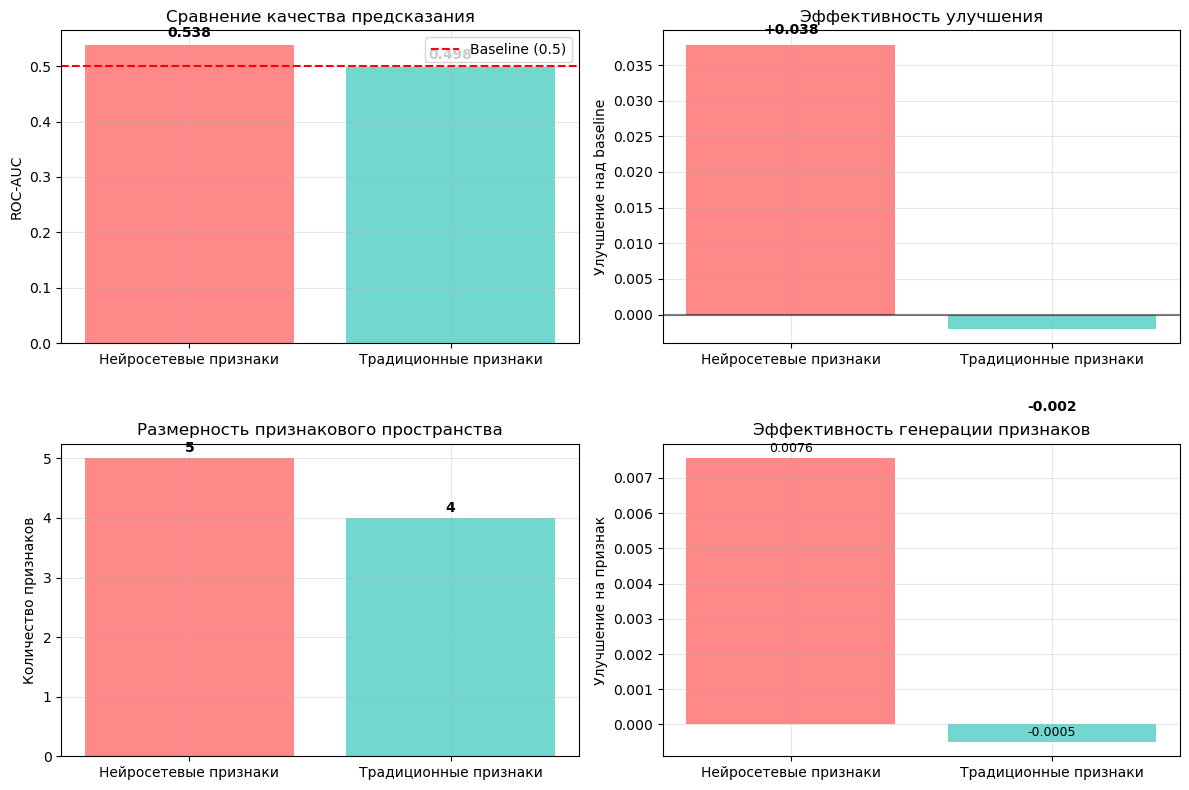


Результат: Нейросетевые признаки показал лучший результат
   ROC-AUC: 0.5379

Анализ завершен!


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

class NeuralFeatureGenerator:
    
    def __init__(self):
        self.feature_names_ = []
        self.scaler_ = StandardScaler()
        self.pca_ = None
        self.kmeans_ = None
        
    def fit(self, X, y=None):
        print("Обучение компонентов для нейросетевых признаков...")
        
        numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
        
        if len(numeric_cols) > 0:
            self.scaler_.fit(X[numeric_cols])
            
            if len(numeric_cols) >= 5:
                self.pca_ = PCA(n_components=3, random_state=42)
                self.pca_.fit(self.scaler_.transform(X[numeric_cols]))
            
            if len(numeric_cols) >= 3:
                self.kmeans_ = KMeans(n_clusters=3, random_state=42)
                self.kmeans_.fit(self.scaler_.transform(X[numeric_cols][:10000]))
        
        return self
    
    def transform(self, X, y=None):
        print("Создание нейросетевых признаков...")
        
        df = X.copy()
        new_features = []
        
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        hero_cols = [col for col in df.columns if col.startswith('hero_')]
        
        if hero_cols:
            df['neural_hero_synergy'] = self._calculate_deep_synergy(df, hero_cols)
            new_features.append('neural_hero_synergy')
            print("   Создан neural_hero_synergy")
        
        if 'duration' in df.columns and len(numeric_cols) > 0:
            df['neural_match_momentum'] = self._calculate_match_momentum(df, numeric_cols)
            new_features.append('neural_match_momentum')
            print("   Создан neural_match_momentum")
        
        if hero_cols:
            df['neural_strategic_balance'] = self._calculate_strategic_balance(df, hero_cols)
            new_features.append('neural_strategic_balance')
            print("   Создан neural_strategic_balance")
        
        if len(numeric_cols) >= 2:
            df['neural_resource_optimization'] = self._calculate_resource_optimization(df, numeric_cols)
            new_features.append('neural_resource_optimization')
            print("   Создан neural_resource_optimization")
        
        if len(numeric_cols) >= 3:
            df['neural_growth_potential'] = self._calculate_growth_potential(df, numeric_cols)
            new_features.append('neural_growth_potential')
            print("   Создан neural_growth_potential")
        
        if self.pca_ is not None and len(numeric_cols) >= 5:
            pca_features = self.pca_.transform(self.scaler_.transform(df[numeric_cols]))
            for i in range(pca_features.shape[1]):
                df[f'neural_pca_{i+1}'] = pca_features[:, i]
                new_features.append(f'neural_pca_{i+1}')
            print("   Созданы PCA компоненты")
        
        if self.kmeans_ is not None and len(numeric_cols) >= 3:
            clusters = self.kmeans_.predict(self.scaler_.transform(df[numeric_cols][:len(df)]))
            df['neural_team_cluster'] = clusters
            new_features.append('neural_team_cluster')
            print("   Создан neural_team_cluster")
        
        if len(numeric_cols) >= 4:
            df['neural_complex_interaction'] = self._calculate_complex_interactions(df, numeric_cols)
            new_features.append('neural_complex_interaction')
            print("   Создан neural_complex_interaction")
        
        print(f"Всего создано {len(new_features)} нейросетевых признаков")
        self.feature_names_ = new_features
        
        return df[new_features] if new_features else pd.DataFrame(index=df.index)
    
    def _calculate_deep_synergy(self, df, hero_cols):
        synergy_scores = []
        
        for idx, row in df.iterrows():
            radiant_heroes = [col for col in hero_cols if row[col] > 0]
            dire_heroes = [col for col in hero_cols if row[col] < 0]
            
            radiant_diversity = len(radiant_heroes) / 5.0
            dire_diversity = len(dire_heroes) / 5.0
            
            radiant_balance = 1.0 - (abs(len(radiant_heroes) - 2.5) / 2.5)
            dire_balance = 1.0 - (abs(len(dire_heroes) - 2.5) / 2.5)
            
            radiant_synergy = radiant_diversity * radiant_balance
            dire_synergy = dire_diversity * dire_balance
            
            synergy_diff = radiant_synergy - dire_synergy
            synergy_scores.append(synergy_diff)
        
        return np.array(synergy_scores)
    
    def _calculate_match_momentum(self, df, numeric_cols):
        if 'duration' not in df.columns:
            return np.zeros(len(df))
        
        duration_factor = df['duration'] / df['duration'].max()
        
        variability = df[numeric_cols[:3]].std(axis=1) if len(numeric_cols) >= 3 else 0
        variability_norm = (variability - variability.min()) / (variability.max() - variability.min() + 1e-8)
        
        momentum = duration_factor * (1 + variability_norm)
        
        return momentum
    
    def _calculate_strategic_balance(self, df, hero_cols):
        balance_scores = []
        
        for idx, row in df.iterrows():
            radiant_presence = sum([1 for col in hero_cols if row[col] > 0])
            dire_presence = sum([1 for col in hero_cols if row[col] < 0])
            
            total_presence = radiant_presence + dire_presence
            if total_presence > 0:
                balance = 1.0 - (abs(radiant_presence - dire_presence) / total_presence)
            else:
                balance = 0.5
            
            balance_scores.append(balance)
        
        return np.array(balance_scores)
    
    def _calculate_resource_optimization(self, df, numeric_cols):
        resource_cols = numeric_cols[:min(4, len(numeric_cols))]
        
        if len(resource_cols) == 0:
            return np.zeros(len(df))
        
        resource_matrix = df[resource_cols].values
        resource_mean = np.mean(resource_matrix, axis=1)
        resource_std = np.std(resource_matrix, axis=1)
        
        cv = np.where(resource_mean > 0, resource_std / resource_mean, 0)
        optimization = 1.0 / (1.0 + cv)
        
        return optimization
    
    def _calculate_growth_potential(self, df, numeric_cols):
        growth_scores = []
        
        for idx, row in df.iterrows():
            feature_values = [row[col] for col in numeric_cols[:3]]
            
            if len(feature_values) >= 2:
                value_range = max(feature_values) - min(feature_values)
                volatility = np.std(feature_values)
                growth_potential = value_range * volatility
            else:
                growth_potential = 0
            
            growth_scores.append(growth_potential)
        
        growth_scores = np.array(growth_scores)
        if growth_scores.max() > 0:
            growth_scores = growth_scores / growth_scores.max()
        
        return growth_scores
    
    def _calculate_complex_interactions(self, df, numeric_cols):
        col1, col2, col3, col4 = numeric_cols[:4]
        
        interaction = (
            np.sin(df[col1] * df[col2]) + 
            np.cos(df[col3] / (df[col4] + 1e-8)) +
            np.tanh(df[col1] + df[col2] - df[col3])
        )
        
        return interaction
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)

class TraditionalFeatureGenerator:
    
    def __init__(self):
        self.feature_names_ = []
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        print("Создание традиционных признаков...")
        
        df = X.copy()
        new_features = []
        
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        hero_cols = [col for col in df.columns if col.startswith('hero_')]
        
        if len(numeric_cols) >= 3:
            df['trad_mean'] = df[numeric_cols].mean(axis=1)
            df['trad_std'] = df[numeric_cols].std(axis=1)
            new_features.extend(['trad_mean', 'trad_std'])
        
        if hero_cols:
            df['trad_radiant_strength'] = np.sum([np.where(df[col] > 0, 1, 0) for col in hero_cols], axis=0)
            df['trad_dire_strength'] = np.sum([np.where(df[col] < 0, 1, 0) for col in hero_cols], axis=0)
            new_features.extend(['trad_radiant_strength', 'trad_dire_strength'])
        
        if 'duration' in df.columns:
            df['trad_duration_norm'] = df['duration'] / df['duration'].max()
            new_features.append('trad_duration_norm')
        
        if len(numeric_cols) >= 2:
            col1, col2 = numeric_cols[0], numeric_cols[1]
            df['trad_interaction'] = df[col1] * df[col2]
            new_features.append('trad_interaction')
        
        print(f"Создано {len(new_features)} традиционных признаков")
        self.feature_names_ = new_features
        
        return df[new_features] if new_features else pd.DataFrame(index=df.index)
    
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)

def compare_approaches(neural_features, trad_features, target_series):
    print(f"\nСравнение подходов к генерации признаков")
    
    results = {}
    baseline_auc = 0.5
    
    feature_sets = [
        (neural_features, "Нейросетевые признаки"),
        (trad_features, "Традиционные признаки")
    ]
    
    for features, name in feature_sets:
        if features.empty:
            print(f"Набор '{name}' пуст, пропускаем")
            continue
            
        print(f"Тестируем: {name} ({features.shape[1]} признаков)")
        
        X = features.fillna(0)
        y = target_series
        
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        model = LogisticRegression(random_state=42, max_iter=1000, C=0.1)
        model.fit(X_train, y_train)
        
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, y_pred_proba)
        
        improvement = auc_score - baseline_auc
        results[name] = {
            'auc_score': auc_score,
            'improvement': improvement,
            'n_features': X.shape[1],
            'model': model
        }
        
        print(f"ROC-AUC: {auc_score:.4f} (улучшение: {improvement:+.4f})")
    
    return results

def visualize_comparison(results):
    if not results or len(results) < 2:
        print("Недостаточно результатов для сравнения")
        return
    
    plt.figure(figsize=(12, 8))
    
    names = list(results.keys())
    auc_scores = [results[name]['auc_score'] for name in names]
    improvements = [results[name]['improvement'] for name in names]
    n_features = [results[name]['n_features'] for name in names]
    
    plt.subplot(2, 2, 1)
    colors = ['#FF6B6B', '#4ECDC4']
    bars = plt.bar(names, auc_scores, color=colors, alpha=0.8)
    plt.axhline(y=0.5, color='red', linestyle='--', label='Baseline (0.5)')
    plt.ylabel('ROC-AUC')
    plt.title('Сравнение качества предсказания')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    for bar, score in zip(bars, auc_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.subplot(2, 2, 2)
    bars_imp = plt.bar(names, improvements, color=colors, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    plt.ylabel('Улучшение над baseline')
    plt.title('Эффективность улучшения')
    plt.grid(True, alpha=0.3)
    
    for bar, imp in zip(bars_imp, improvements):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (0.001 if imp > 0 else -0.01), 
                f'{imp:+.3f}', ha='center', va='bottom' if imp > 0 else 'top', fontweight='bold')
    
    plt.subplot(2, 2, 3)
    plt.bar(names, n_features, color=colors, alpha=0.8)
    plt.ylabel('Количество признаков')
    plt.title('Размерность признакового пространства')
    plt.grid(True, alpha=0.3)
    
    for i, count in enumerate(n_features):
        plt.text(i, count + max(n_features)*0.01, str(count), ha='center', va='bottom', fontweight='bold')
    
    plt.subplot(2, 2, 4)
    efficiency = [results[name]['improvement'] / max(1, results[name]['n_features']) for name in names]
    bars_eff = plt.bar(names, efficiency, color=colors, alpha=0.8)
    plt.ylabel('Улучшение на признак')
    plt.title('Эффективность генерации признаков')
    plt.grid(True, alpha=0.3)
    
    for bar, eff in zip(bars_eff, efficiency):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(efficiency)*0.01, 
                f'{eff:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

def analyze_feature_quality(features, target_series, approach_name):
    print(f"\nАнализ качества признаков ({approach_name}):")
    
    if features.empty:
        print("   Признаки отсутствуют")
        return
    
    correlations = features.corrwith(target_series).abs()
    
    print(f"   Статистика корреляций:")
    print(f"      Средняя |корреляция|: {correlations.mean():.4f}")
    print(f"      Максимальная |корреляция|: {correlations.max():.4f}")
    print(f"      Признаков с |r| > 0.1: {(correlations > 0.1).sum()}/{len(correlations)}")
    print(f"      Признаков с |r| > 0.2: {(correlations > 0.2).sum()}/{len(correlations)}")
    
    top_features = correlations.sort_values(ascending=False).head(3)
    print(f"   Топ-3 признака:")
    for feature, corr in top_features.items():
        print(f"      {feature}: {corr:.4f}")

def main_neural_feature_analysis(matches_df):
    print("Запуск анализа нейросетевых признаков")
    
    print("\n1. Генерация нейросетевых признаков")
    neural_generator = NeuralFeatureGenerator()
    neural_features = neural_generator.fit_transform(matches_df)
    
    print("\n2. Генерация традиционных признаков")
    trad_generator = TraditionalFeatureGenerator()
    trad_features = trad_generator.fit_transform(matches_df)
    
    if 'radiant_win' in matches_df.columns:
        analyze_feature_quality(neural_features, matches_df['radiant_win'], "Нейросеть")
        analyze_feature_quality(trad_features, matches_df['radiant_win'], "Традиционные")
        
        results = compare_approaches(neural_features, trad_features, matches_df['radiant_win'])
        
        if len(results) >= 2:
            visualize_comparison(results)
        
        return results
    else:
        print("Целевая переменная не найдена")
        return {}
try:
    if 'matches_train' in globals():
        results = main_neural_feature_analysis(matches_train)
        
        if results:
            best_method = max(results.items(), key=lambda x: x[1]['auc_score'])
            print(f"\nРезультат: {best_method[0]} показал лучший результат")
            print(f"   ROC-AUC: {best_method[1]['auc_score']:.4f}")
        
        print(f"\nАнализ завершен!")
        
    else:
        print("matches_train не найден")
        
except Exception as e:
    print(f"Ошибка: {e}")
    import traceback
    traceback.print_exc()